In [1]:
import random
import re
import pandas as pd
import json
from tqdm import tqdm
import pprint
from collections import defaultdict
# from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
# from torch_kmeans import KMeans as TorchKMeans
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
import numpy as np
import os
from transformers import RobertaTokenizer
# import faiss


filename = "pyedur_full.jsonl"

c:\Users\ovane\miniconda3\envs\dl2-code-io\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Analyze Dataset

In [2]:
def print_line(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        for i in range(random.randint(0,1630607)):
            f.readline()
        pprint.pp(f.readline())

def num_rows(file_path):
    count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for _ in f:
            count += 1

    print(f'Total number of rows: {count}')
    return count

In [ ]:
total_datapoints = num_rows('ast-pyedur_full.jsonl')

Total number of rows: 1630607


In [ ]:
print_line(filename)

{"prompt": "You are given a question that requires some input and output variables as follows:\n\nGiven a list of integers, how can we determine the smallest number using different divide-and-conquer strategies, or calculate the sum of elements at positions that are multiples of 3, or find the r-th root of a number with a specified precision?\n\nThe input and output requirements are as follows:\n\nInput:\n  `data` (list): A list of integers. For the 'root' operation, the list should contain exactly three elements: the number `n`, the root `r`, and the precision `p`.\n  `operation` (str): A string indicating the operation to perform. Valid values are 'min', 'minChip', 'sumMultiples', and 'root'.\n\nOutput:\n  `return` (int or float): The result of the specified operation. For 'min', 'minChip', and 'sumMultiples', it returns an integer. For 'root', it returns a float.\n\nGiven the following input:\n\n{'data': [-52, 83, 78, -31, -100, -56, 33, -32, -93, 38], 'operation': 'sumMultiples'}\n

In [ ]:
import json
import tiktoken

def average_prompt_tokens(file_path, model="gpt-3.5-turbo"):
    enc = tiktoken.encoding_for_model(model)
    total_tokens = 0
    total_prompts = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
                prompt = obj.get("prompt", "")
                token_count = len(enc.encode(prompt))
                total_tokens += token_count
                total_prompts += 1
            except json.JSONDecodeError:
                continue  # Skip malformed lines

    if total_prompts == 0:
        print("No valid prompts found.")
        return

    average = total_tokens / total_prompts
    print(f"Average number of tokens in 'prompt': {average:.2f}")


In [ ]:
average_prompt_tokens(filename)


Average number of tokens in 'prompt': 809.38


In [ ]:
def analyze_code_tokens_codebert(file_path, model_name="microsoft/codebert-base"):
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    total_tokens = 0
    total_codes = 0
    max_tokens = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
                code = obj.get("code", "")
                tokenized = tokenizer.encode(code, add_special_tokens=True)
                token_count = len(tokenized)
                total_tokens += token_count
                total_codes += 1
                max_tokens = max(max_tokens, token_count)
            except json.JSONDecodeError:
                continue  # Skip malformed lines

    if total_codes == 0:
        print("No valid code entries found.")
        return

    average = total_tokens / total_codes
    print(f"Average number of CodeBERT tokens in 'code': {average:.2f}")
    print(f"Maximum number of CodeBERT tokens in 'code': {max_tokens}")

In [ ]:
analyze_code_tokens_codebert('/content/drive/MyDrive/DL2/subset.jsonl')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1167 > 512). Running this sequence through the model will result in indexing errors


Average number of CodeBERT tokens in 'code': 898.05
Maximum number of CodeBERT tokens in 'code': 7125


### Extract code, create asts

In [ ]:
import json
import ast

# Extract code after the marker
def extract_code(prompt):
    marker = "You can refer to this code to guide your reasoning but not copy spans of code directly."
    if marker in prompt:
        return prompt.split(marker, 1)[-1].strip()
    return ""

# Convert code to AST
def code_to_ast(code):
    try:
        tree = ast.parse(code)
        return ast.dump(tree)
    except SyntaxError as e:
        print(f"SyntaxError in parsing code: {e}")
        return None

def process_jsonl(input_path, output_path, buffer_size=5000):
    buffer = []

    # First, count total lines for tqdm
    with open(input_path, 'r', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)

    with open(input_path, 'r', encoding='utf-8') as infile, \
         open(output_path, 'w', encoding='utf-8') as outfile:

        for idx, line in enumerate(tqdm(infile, total=total_lines, desc="Processing JSONL")):
            try:
                data = json.loads(line)

                # Phase 1: Extract code
                prompt = data.get("prompt", "")
                code = extract_code(prompt)
                data["code"] = code

                # Phase 2: Convert to AST
                ast_representation = code_to_ast(code)
                if ast_representation is not None:
                    data["ast"] = ast_representation

                buffer.append(json.dumps(data))

                # Write in chunks
                if len(buffer) >= buffer_size:
                    outfile.write("\n".join(buffer) + "\n")
                    buffer.clear()

            except Exception as e:
                print(f"[Line {idx}] Error: {e}")
                continue

        # Write any remaining lines
        if buffer:
            outfile.write("\n".join(buffer) + "\n")


In [ ]:
ast_dataset = "ast-pyedur_full.jsonl"
# process_jsonl(filename,ast_dataset)

In [ ]:
print_line(ast_dataset)
num_rows(ast_dataset)

('{"prompt": "You are given a question that requires some input and output '
 'variables as follows:\\n\\nGiven the dimensions of a 3D volume in pixels, '
 'the A/pixel for the generated map, and the type of model to create (random '
 'or specified), how many Gaussian blobs are used to construct the model, and '
 'what are the dimensions of the resulting model?\\n\\nThe input and output '
 'requirements are as follows:\\n\\nInput:\\n- `dimensions` (list of int): The '
 'dimensions of the volume in pixels [x, y, z].\\n- `apix` (float): The '
 'A/pixel for the generated map.\\n- `model_type` (str): The type of model to '
 "create, either 'r' for random or 's' for specified.\\n- `blobs` (list of "
 'list of float): The parameters for each blob. For random models, this is '
 'generated internally. For specified models, this is provided by the user. '
 'Each blob is a list of 6 floats representing [r, theta, z, dx, dy, '
 'dz].\\n\\nOutput:\\n- `return` (dict): A dictionary containing the '

### Calculate complexity based on asts

In [45]:
def calculate_complexity(ast_str):
    metrics = {
        'functions': r'FunctionDef\(',
        'loops': r'(For\()|(While\()',
        'conditionals': r'If\(',
        'calls': r'Call\(',
        'assignments': r'(Assign\()|(AugAssign\()'
    }
    return sum(len(re.findall(pattern, ast_str)) for pattern in metrics.values())

def process_large_dataset(jsonl_path, target_size=6000):
    # First pass: Calculate complexity distribution
    complexities = []
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="First pass - analyzing complexity"):
            entry = json.loads(line)
            complexities.append(calculate_complexity(entry['ast']))

    # Calculate quantile boundaries
    low_cut, high_cut = np.percentile(complexities, [33, 66])

    # Second pass: Stratified sampling
    samples = {'low': [], 'medium': [], 'high': []}
    sample_size = target_size // 3
    current_counts = {'low': 0, 'medium': 0, 'high': 0}

    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Second pass - sampling"):
            entry = json.loads(line)
            complexity = calculate_complexity(entry['ast'])

            # Determine tier
            if complexity <= low_cut:
                tier = 'low'
            elif complexity <= high_cut:
                tier = 'medium'
            else:
                tier = 'high'

            # Reservoir sampling for each tier
            if current_counts[tier] < sample_size:
                samples[tier].append(entry)
                current_counts[tier] += 1
            else:
                # Random replacement to maintain randomness
                r = np.random.randint(0, current_counts[tier])
                if r < sample_size:
                    samples[tier][r] = entry

    # Combine and shuffle results
    final_sample = samples['low'] + samples['medium'] + samples['high']
    np.random.shuffle(final_sample)
    return final_sample[:target_size]

### Old approach: make subset based on ast distribution

In [ ]:
# Usage
# filtered_dataset = process_large_dataset('ast-pyedur_full.jsonl', 6000)

In [ ]:
def save_sampled_data(sampled_entries, output_path):
    """Save sampled entries to a JSONL file"""
    with open(output_path, 'w') as f:
        for entry in tqdm(sampled_entries, desc="Saving sampled data"):
            json_line = json.dumps(entry, ensure_ascii=False)
            f.write(json_line + '\n')

save_sampled_data(filtered_dataset, 'subset.jsonl')

Saving sampled data: 100%|██████████| 6000/6000 [00:00<00:00, 6646.77it/s]


### analyze complexity distribution

In [53]:
def analyze_complexity_distribution(jsonl_path, num_buckets=20):
    """Analyze complexity distribution for smaller datasets"""
    # Single pass to calculate all complexities
    complexities = []
    
    try:
        with open(jsonl_path) as f:
            for line in tqdm(f, desc="Calculating complexities"):
                try:
                    entry = json.loads(line)
                    complexities.append(calculate_complexity(entry['ast']))
                except (json.JSONDecodeError, KeyError):
                    continue  # Skip invalid entries
    except FileNotFoundError:
        print(f"Error: File '{jsonl_path}' not found")
        return None
        
    # Handle empty file case
    if not complexities:
        print(f"Error: No valid entries found in '{jsonl_path}'")
        return None
    
    # Calculate percentiles based on actual data
    percentiles = np.unique(np.percentile(complexities, np.linspace(0, 100, num_buckets+1)))
    
    # For small datasets, we might get fewer unique percentiles than requested buckets
    actual_buckets = len(percentiles) - 1
    bucket_counts = {i: 0 for i in range(actual_buckets)}
    
    # Count entries in each bucket
    for c in complexities:
        bucket = np.searchsorted(percentiles, c, side='right') - 1
        bucket = min(max(bucket, 0), actual_buckets-1)
        bucket_counts[bucket] += 1
    
    return {
        'percentiles': percentiles.tolist(),
        'counts': bucket_counts,
        'statistics': {
            'mean': np.mean(complexities),
            'median': np.median(complexities),
            'std_dev': np.std(complexities),
            'min': min(complexities),
            'max': max(complexities),
            'total': len(complexities)
        }
    }

In [ ]:
distribution = analyze_complexity_distribution('ast-pyedur_full.jsonl')


Estimating distribution: 1630607it [13:31, 2009.60it/s]
Counting distribution: 1630607it [13:37, 1994.58it/s]


In [49]:
def plot_complexity_distribution(distribution):
    if distribution is None:
        print("Cannot plot: distribution data is None")
        return
        
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(distribution['counts'])), distribution['counts'].values())
    plt.xlabel('Complexity Percentile Bucket')
    plt.ylabel('Entry Count')
    plt.title('Code Problem Complexity Distribution')
    
    if len(distribution['percentiles']) > 1:
        plt.xticks(ticks=range(len(distribution['percentiles'])-1),
                  labels=[f"{int(distribution['percentiles'][i])}-{int(distribution['percentiles'][i+1])}"
                          for i in range(len(distribution['percentiles'])-1)],
                  rotation=45)
    plt.show()

# plot_complexity_distribution(distribution)

### Generate code embeddings

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import numpy as np
import os
from tqdm import tqdm

# 1. Embedding Generation with CodeBERT
def generate_code_embeddings(jsonl_path, embedding_path='embeddings.npy', batch_size=64, max_length=512, chunk_strategy="mean"):
    if os.path.exists(embedding_path):
        print(f"Loading existing embeddings from {embedding_path}")
        return np.load(embedding_path)

    # Add length tracking
    length_stats = {
        'total': 0,
        'chunked': 0,
        'max_length': 0
    }

    tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
    model = AutoModel.from_pretrained("microsoft/codebert-base").cuda()
    embeddings = []

    def num_rows(filepath):
        with open(filepath) as f:
            return sum(1 for _ in f)

    total = num_rows(jsonl_path)

    def process_code_chunk(batch):
        inputs = tokenizer(
            batch, return_tensors="pt", padding=True,
            truncation=True, max_length=max_length
        ).to('cuda')

        with torch.no_grad():
            outputs = model(**inputs)

        return torch.mean(outputs.last_hidden_state, dim=1).cpu()

    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Generating embeddings", total=total):
            entry = json.loads(line)
            code = entry['code']

            # Track original length
            tokens = tokenizer.tokenize(code)
            length_stats['total'] += 1
            length_stats['max_length'] = max(length_stats['max_length'], len(tokens))

            if len(tokens) <= max_length:
                # Code fits within limit - process normally
                chunk_embeddings = process_code_chunk([code])
                embeddings.append(chunk_embeddings[0].numpy())
            else:
                # Code exceeds limit - use chunking
                length_stats['chunked'] += 1

                # Split into overlapping chunks with stride
                stride = max_length // 2
                chunk_inputs = []

                for i in range(0, len(tokens), stride):
                    chunk_tokens = tokens[i:i+max_length]
                    if len(chunk_tokens) < max_length // 4:  # Skip very small final chunks
                        continue
                    chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
                    chunk_inputs.append(chunk_text)

                if not chunk_inputs:  # Ensure we have at least one chunk
                    chunk_inputs = [tokenizer.convert_tokens_to_string(tokens[:max_length])]

                # Process each chunk in batches
                all_chunk_embeddings = []
                for i in range(0, len(chunk_inputs), batch_size):
                    batch_chunks = chunk_inputs[i:i+batch_size]
                    batch_embs = process_code_chunk(batch_chunks)
                    all_chunk_embeddings.extend([emb for emb in batch_embs])

                # Aggregate the chunk embeddings
                all_chunk_embeddings = torch.stack(all_chunk_embeddings)
                if chunk_strategy == "mean":
                    final_embedding = torch.mean(all_chunk_embeddings, dim=0).numpy()
                elif chunk_strategy == "max":
                    final_embedding = torch.max(all_chunk_embeddings, dim=0)[0].numpy()
                else:  # Default to mean
                    final_embedding = torch.mean(all_chunk_embeddings, dim=0).numpy()

                embeddings.append(final_embedding)

    # Print chunking stats
    print("Chunking Report:\n",
          f"- Total samples: {length_stats['total']}\n",
          f"- Chunked samples: {length_stats['chunked']} ",
          f"({length_stats['chunked']/length_stats['total']:.1%})\n",
          f"- Max token length: {length_stats['max_length']}")

    embeddings = np.array(embeddings)
    np.save(embedding_path, embeddings)
    print(f"Saved embeddings to {embedding_path}")
    return embeddings

# 2. Dimensionality Reduction
def reduce_dimensions(embeddings, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

# 3. Clustering
def cluster_embeddings(reduced_embeddings, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(reduced_embeddings)

# 4. Visualization and Analysis
def analyze_clusters(reduced_embeddings, cluster_labels):
    # UMAP Visualization
    umap_embeddings = UMAP().fit_transform(reduced_embeddings)

    plt.figure(figsize=(12, 8))
    plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1],
                c=cluster_labels, cmap='Spectral', alpha=0.6)
    plt.colorbar()
    plt.title("Code Embedding Clusters")
    plt.show()

# 5. Academic Cluster Interpretation Methods
def interpret_clusters(jsonl_path, cluster_labels, n_samples=5):
    # Load data with clusters
    data = []
    with open(jsonl_path) as f:
        for i, line in enumerate(tqdm(f, desc="Loading data")):
            entry = json.loads(line)
            entry['cluster'] = cluster_labels[i]
            data.append(entry)

    df = pd.DataFrame(data)

    # Academic Analysis Techniques:
    for cluster_id in df['cluster'].unique():
        cluster_df = df[df['cluster'] == cluster_id]
        cluster_size = len(cluster_df)

        print(f"\nCluster {cluster_id} (Size: {cluster_size}) Characteristics:")

        # Handle small clusters
        sample_size = min(n_samples, cluster_size)
        replace = cluster_size < n_samples

        samples = cluster_df.sample(n=sample_size, replace=replace)['code']

        # b. Keyword Frequency Analysis
        from collections import Counter
        keywords = Counter()
        for code in samples:
            keywords.update(code.split())

        print("Top Keywords:", keywords.most_common(5))

        # c. Code Structure Analysis
        print("Sample Code Snippets:")
        for code in samples:
            print("-", code[:100] + "...")

# Full Pipeline
def analyze_code_dataset(jsonl_path,embedding_path):
    # 1. Generate embeddings
    embeddings = generate_code_embeddings(jsonl_path, embedding_path)

    # 2. Reduce dimensionality
    reduced_emb = reduce_dimensions(embeddings)

    # 3. Cluster data
    clusters = cluster_embeddings(reduced_emb)

    # 4. Visualize
    analyze_clusters(reduced_emb, clusters)

    # 5. Interpret clusters
    interpret_clusters(jsonl_path, clusters)

# Usage
# analyze_code_dataset(jsonl_path ='/content/drive/MyDrive/DL2/subset.jsonl', embedding_path='subset_embeddings.npy')

In [ ]:
# generate_code_embeddings(jsonl_path ='ast-pyedur_full.jsonl', embedding_path='all_embeddings.npy')

In [4]:
# embeddings = np.load('/content/drive/MyDrive/DL2/all_embeddings.npy')
embeddings = np.load('clusters/all_embeddings.npy')

### Normalize, then reduce embedding dimension to 10

In [5]:
import numpy as np
from sklearn.preprocessing import normalize

# Assuming `embeddings` is a numpy array of shape (n_samples, n_features)
normalized_embeddings = normalize(embeddings, norm='l2', axis=1)

In [6]:
# 2. Dimensionality Reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def reduce_dimensions(embeddings, n_components=10, plot_variance=False):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Get explained variance ratios
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    print(f"Explained variance by each component: {explained_variance}")
    print(f"Cumulative explained variance: {cumulative_variance}")
    
    # Optional: Plot the variance
    if plot_variance:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, n_components+1), cumulative_variance, marker='o')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("PCA Explained Variance")
        plt.grid()
        plt.show()
    
    return reduced_embeddings

Explained variance by each component: [0.2663236  0.20797318 0.11065899 0.0440102  0.03510777 0.02829361
 0.024458   0.02293255 0.01478187 0.01320335 0.01290017 0.01075785
 0.00883709 0.00763545 0.00642026 0.00633482 0.00583957 0.00481044
 0.0045747  0.00423134 0.00391617 0.00375202 0.00359571 0.00348224
 0.00314025 0.00282099 0.00274121 0.00265367 0.00261353 0.00246339
 0.00242423 0.00228554]
Cumulative explained variance: [0.2663236  0.47429678 0.58495575 0.628966   0.66407377 0.6923674
 0.71682537 0.7397579  0.7545398  0.7677432  0.78064334 0.7914012
 0.8002383  0.8078738  0.81429404 0.8206289  0.82646847 0.8312789
 0.83585364 0.84008497 0.8440011  0.8477531  0.8513488  0.85483104
 0.8579713  0.8607923  0.8635335  0.86618716 0.8688007  0.8712641
 0.87368834 0.8759739 ]


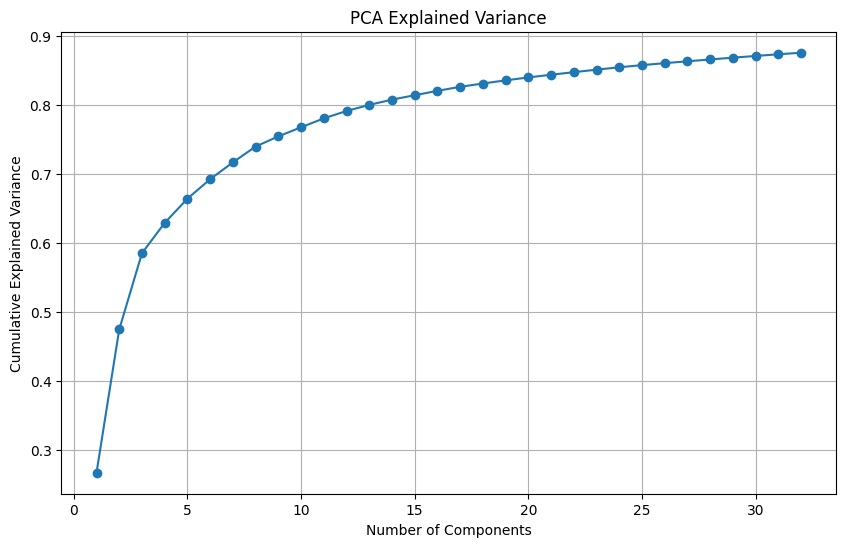

In [35]:
reduced_normalized_embeddings_32 = reduce_dimensions(normalized_embeddings,32, plot_variance = True)
# embeddings = torch.from_numpy(reduced_embeddings)

Explained variance by each component: [0.26632363 0.20797323 0.11065903 0.04401016 0.03510781 0.02829362
 0.02445799 0.02293256 0.01478183 0.01320337 0.01290015 0.01075785
 0.00883707 0.00763544 0.00642027 0.00633481 0.00583956 0.00481044
 0.00457469 0.00423134 0.00391615 0.00375202 0.00359572 0.00348223
 0.00314026 0.00282098 0.00274121 0.00265366 0.00261352 0.00246337
 0.00242423 0.00228555 0.00218751 0.00214293 0.00211406 0.00196482
 0.00193255 0.0017956  0.00176465 0.00168792 0.00164982 0.00161848
 0.00154271 0.00149645 0.00146619 0.00137573 0.00135518 0.00134752
 0.0013122  0.00125353]
Cumulative explained variance: [0.26632363 0.47429687 0.5849559  0.62896603 0.6640738  0.69236743
 0.7168254  0.73975796 0.7545398  0.7677432  0.78064334 0.7914012
 0.80023825 0.80787367 0.8142939  0.82062876 0.82646835 0.8312788
 0.8358535  0.84008485 0.844001   0.847753   0.8513487  0.8548309
 0.8579712  0.86079216 0.8635334  0.86618704 0.8688006  0.871264
 0.8736882  0.87597376 0.87816125 0.88030

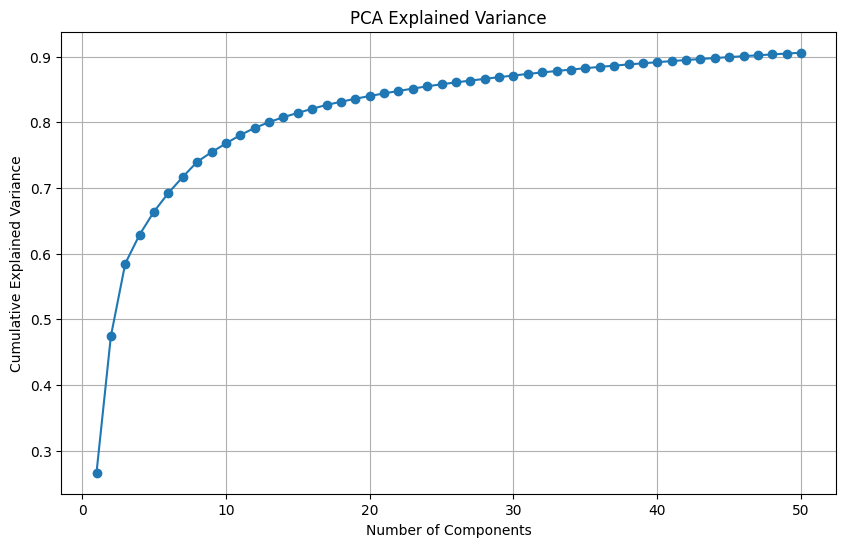

In [ ]:
reduced_normalized_embeddings_50 = reduce_dimensions(normalized_embeddings,50, plot_variance = True)
# embeddings = torch.from_numpy(reduced_embeddings)

### Import reduced embeddings

In [7]:
# reduced_normalized_embeddings_10 = reduce_dimensions(normalized_embeddings,10, plot_variance = True)
# np.save('reduced_embeddings', reduced_normalized_embeddings_10)
reduced_normalized_embeddings_10 = np.load('clusters/reduced_embeddings.npy')


### Test a bunch of clustering parameters

In [12]:
import hdbscan
import numpy as np
from joblib import Memory
from time import time
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Create a memory cachedir
memory = Memory(location='./hdbscan_cache', verbose=1)

@memory.cache
def cached_hdbscan_fit(data, min_cluster_size = 5, min_samples=None):
    """
    Cached version of HDBSCAN fitting using the standalone library
    """
    print(f"Computing HDBSCAN with min_cluster_size={min_cluster_size}, min_samples={min_samples}")
    start_time = time()
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        core_dist_n_jobs=-1,
        cluster_selection_method='eom'
    )
    
    labels = clusterer.fit_predict(data)
    
    print(f"Computation took {time() - start_time:.2f} seconds")
    return clusterer, labels

def calculate_clustering_metrics(data, labels):
    """
    Calculate clustering quality metrics
    """
    # Filter out noise points for metric calculation
    mask = labels != -1
    if len(np.unique(labels[mask])) < 2:
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None
        }
    
    try:
        # Use sample for silhouette score if dataset is large
        if len(data) > 10000:
            silhouette = silhouette_score(data[mask], labels[mask], sample_size=10000, random_state=42)
        else:
            silhouette = silhouette_score(data[mask], labels[mask])
            
        calinski = calinski_harabasz_score(data[mask], labels[mask])
        davies = davies_bouldin_score(data[mask], labels[mask])
        
        return {
            'silhouette': silhouette,
            'calinski_harabasz': calinski,
            'davies_bouldin': davies
        }
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None
        }

# Print statistics with metrics
def print_clustering_stats(data, labels, include_metrics=True, max_sample_size=50000):
    """
    Print statistics about the clustering results
    Uses a random subset for metrics calculation to avoid memory issues
    """
    n_clusters = len(np.unique(labels)) - 1  # -1 for noise
    noise_points = np.sum(labels == -1)
    noise_ratio = noise_points / len(labels)

    print(f"\nClustering Statistics:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Noise points: {noise_points} ({noise_ratio:.2%})")
    if n_clusters > 0:
        cluster_sizes = [np.sum(labels == i) for i in range(n_clusters)]
        print(f"Largest cluster: {max(cluster_sizes)} points")
        print(f"Smallest cluster: {min(cluster_sizes)} points")
        print(f"Average cluster size: {np.mean(cluster_sizes):.1f} points")
        
        if include_metrics:
            # Create a random subset for metrics calculation
            np.random.seed(42)  # For reproducibility
            
            # Determine subset size (capped at max_sample_size)
            subset_size = min(max_sample_size, len(data))
            
            # Sample indices, ensuring we have points from different clusters
            indices = []
            
            # First add some points from each cluster to ensure representation
            if n_clusters <= 100:  # If reasonable number of clusters
                for i in range(n_clusters):
                    cluster_indices = np.where(labels == i)[0]
                    if len(cluster_indices) > 0:
                        # Take up to 100 points from each cluster
                        sample_count = min(100, len(cluster_indices))
                        indices.extend(np.random.choice(cluster_indices, sample_count, replace=False))
            
            # Then fill the rest with random sampling
            if len(indices) < subset_size:
                remaining = subset_size - len(indices)
                # Avoid duplicate indices
                remaining_indices = np.setdiff1d(np.arange(len(data)), indices)
                if len(remaining_indices) > 0:
                    indices.extend(np.random.choice(remaining_indices, min(remaining, len(remaining_indices)), replace=False))
            
            # Make sure we don't exceed the desired size
            indices = indices[:subset_size]
            
            # Create the subset data and labels
            subset_data = data[indices]
            subset_labels = labels[indices]
            
            print(f"\nCalculating metrics on a random subset of {len(indices)} points...")
            
            # Filter to non-noise points for metrics calculation
            mask = subset_labels != -1
            subset_data_clean = subset_data[mask]
            subset_labels_clean = subset_labels[mask]
            
            # Check if we have at least 2 clusters in the subset
            if len(np.unique(subset_labels_clean)) >= 2:
                try:
                    # Calculate metrics on the subset
                    silhouette = silhouette_score(subset_data_clean, subset_labels_clean, sample_size=min(10000, len(subset_data_clean)))
                    print(f"Silhouette Score (-1 to 1, higher is better): {silhouette:.3f}")
                except Exception as e:
                    print(f"Could not calculate Silhouette Score: {str(e)}")
                
                try:
                    calinski = calinski_harabasz_score(subset_data_clean, subset_labels_clean)
                    print(f"Calinski-Harabasz Score (higher is better): {calinski:.1f}")
                except Exception as e:
                    print(f"Could not calculate Calinski-Harabasz Score: {str(e)}")
                
                try:
                    davies = davies_bouldin_score(subset_data_clean, subset_labels_clean)
                    print(f"Davies-Bouldin Score (lower is better): {davies:.3f}")
                except Exception as e:
                    print(f"Could not calculate Davies-Bouldin Score: {str(e)}")
            else:
                print("Not enough clusters in the sample to calculate metrics")
    
    print("-" * 50)

# Uncomment to test different parameters
# results = test_different_parameters()

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap
import numpy as np

# Option 1: Visualize using t-SNE (better for preserving local structure)
def plot_tsne_clusters(data, labels, n_samples=50000, perplexity=30, random_state=42):
    """
    Visualize clusters using t-SNE for dimensionality reduction
    
    Parameters:
    - data: High-dimensional data array
    - labels: Cluster labels
    - n_samples: Number of points to sample (t-SNE is slow for large datasets)
    - perplexity: t-SNE perplexity parameter
    - random_state: Random seed for reproducibility
    """
    # Sample data if needed
    if len(data) > n_samples:
        # Stratified sampling to maintain cluster proportions
        sampled_indices = []
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            label_indices = np.where(labels == label)[0]
            # Calculate proportion for this cluster
            sample_size = int(n_samples * (len(label_indices) / len(labels)))
            # Ensure at least some points from each cluster
            sample_size = max(sample_size, min(100, len(label_indices)))
            # Sample indices
            sampled_from_label = np.random.choice(label_indices, 
                                                 size=sample_size, 
                                                 replace=False)
            sampled_indices.extend(sampled_from_label)
            
        # Make sure we don't exceed n_samples
        if len(sampled_indices) > n_samples:
            sampled_indices = np.random.choice(sampled_indices, size=n_samples, replace=False)
            
        sampled_data = data[sampled_indices]
        sampled_labels = labels[sampled_indices]
    else:
        sampled_data = data
        sampled_labels = labels
    
    # Apply t-SNE
    print("Computing t-SNE projection...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    projection = tsne.fit_transform(sampled_data)
    
    # Create colormap
    cmap = plt.cm.get_cmap('viridis', len(np.unique(sampled_labels)))
    
    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(projection[:, 0], projection[:, 1], 
                         c=sampled_labels, cmap=cmap, alpha=0.7, s=5)
    
    # Add legend with cluster counts
    unique_labels = np.unique(sampled_labels)
    handles, _ = scatter.legend_elements()
    
    legend_labels = []
    for label in unique_labels:
        if label == -1:
            count = np.sum(labels == -1)
            percent = 100 * count / len(labels)
            legend_labels.append(f"Noise: {count} ({percent:.1f}%)")
        else:
            count = np.sum(labels == label)
            percent = 100 * count / len(labels)
            legend_labels.append(f"Cluster {label}: {count} ({percent:.1f}%)")
    
    plt.legend(handles, legend_labels, title="Clusters")
    plt.title(f"t-SNE Visualization of HDBSCAN Clusters (sample size: {len(sampled_data)})")
    plt.tight_layout()
    plt.show()

# Option 2: Visualize using UMAP (faster and better for preserving global structure)
def plot_umap_clusters(data, labels, n_samples=50000, n_neighbors=15, min_dist=0.1, random_state=42):
    """
    Visualize clusters using UMAP for dimensionality reduction
    
    Parameters:
    - data: High-dimensional data array
    - labels: Cluster labels
    - n_samples: Number of points to sample
    - n_neighbors: UMAP neighbors parameter
    - min_dist: UMAP minimum distance parameter
    - random_state: Random seed for reproducibility
    """
    # Sample data if needed (same approach as in t-SNE)
    if len(data) > n_samples:
        sampled_indices = []
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            label_indices = np.where(labels == label)[0]
            sample_size = int(n_samples * (len(label_indices) / len(labels)))
            sample_size = max(sample_size, min(100, len(label_indices)))
            sampled_from_label = np.random.choice(label_indices, 
                                                 size=sample_size, 
                                                 replace=False)
            sampled_indices.extend(sampled_from_label)
            
        if len(sampled_indices) > n_samples:
            sampled_indices = np.random.choice(sampled_indices, size=n_samples, replace=False)
            
        sampled_data = data[sampled_indices]
        sampled_labels = labels[sampled_indices]
    else:
        sampled_data = data
        sampled_labels = labels
    
    # Apply UMAP
    print("Computing UMAP projection...")
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       n_components=2, random_state=random_state)
    projection = reducer.fit_transform(sampled_data)
    
    # Create colormap
    cmap = plt.cm.get_cmap('viridis', len(np.unique(sampled_labels)))
    
    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(projection[:, 0], projection[:, 1], 
                         c=sampled_labels, cmap=cmap, alpha=0.7, s=5)
    
    # Add legend with cluster counts
    unique_labels = np.unique(sampled_labels)
    handles, _ = scatter.legend_elements()
    
    legend_labels = []
    for label in unique_labels:
        if label == -1:
            count = np.sum(labels == -1)
            percent = 100 * count / len(labels)
            legend_labels.append(f"Noise: {count} ({percent:.1f}%)")
        else:
            count = np.sum(labels == label)
            percent = 100 * count / len(labels)
            legend_labels.append(f"Cluster {label}: {count} ({percent:.1f}%)")
    
    plt.legend(handles, legend_labels, title="Clusters")
    plt.title(f"UMAP Visualization of HDBSCAN Clusters (sample size: {len(sampled_data)})")
    plt.tight_layout()
    plt.show()

# Option 3: 3D Visualization using UMAP
def plot_3d_umap_clusters(data, labels, n_samples=50000, n_neighbors=15, min_dist=0.1, random_state=42):
    """Visualize clusters in 3D using UMAP"""
    from mpl_toolkits.mplot3d import Axes3D
    
    # Sample data if needed (same approach as before)
    if len(data) > n_samples:
        # Stratified sampling
        sampled_indices = []
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            label_indices = np.where(labels == label)[0]
            sample_size = int(n_samples * (len(label_indices) / len(labels)))
            sample_size = max(sample_size, min(100, len(label_indices)))
            sampled_from_label = np.random.choice(label_indices, 
                                                 size=sample_size, 
                                                 replace=False)
            sampled_indices.extend(sampled_from_label)
            
        if len(sampled_indices) > n_samples:
            sampled_indices = np.random.choice(sampled_indices, size=n_samples, replace=False)
            
        sampled_data = data[sampled_indices]
        sampled_labels = labels[sampled_indices]
    else:
        sampled_data = data
        sampled_labels = labels
    
    # Apply UMAP for 3D
    print("Computing 3D UMAP projection...")
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       n_components=3, random_state=random_state)
    projection = reducer.fit_transform(sampled_data)
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create colormap
    cmap = plt.cm.get_cmap('viridis', len(np.unique(sampled_labels)))
    
    # Plot each cluster
    for label in np.unique(sampled_labels):
        mask = sampled_labels == label
        if label == -1:
            ax.scatter(projection[mask, 0], projection[mask, 1], projection[mask, 2], 
                      c='gray', label=f"Noise", alpha=0.5, s=3)
        else:
            ax.scatter(projection[mask, 0], projection[mask, 1], projection[mask, 2], 
                      c=cmap(label), label=f"Cluster {label}", alpha=0.7, s=5)
    
    ax.set_title(f"3D UMAP Visualization of HDBSCAN Clusters")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Choose one or more visualization methods
# Note: Run only one at a time for large datasets

# 1. t-SNE visualization
# plot_tsne_clusters(reduced_normalized_embeddings_10, labels, n_samples=100000)

# 2. UMAP visualization (usually faster than t-SNE and often better at preserving global structure)
# plot_umap_clusters(reduced_normalized_embeddings_10, labels, n_samples=50000)

# 3. 3D UMAP visualization
# plot_3d_umap_clusters(reduced_normalized_embeddings_10, labels, n_samples=50000)

c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Run in a new cell to test different parameters
print("Testing with min_cluster_size=50, min_samples=10")
clusterer, labels = cached_hdbscan_fit(reduced_normalized_embeddings_10, min_cluster_size=50, min_samples=10)

# Save the results if you want
np.save('hdbscan_labels_reduced15_mcs50_ms10.npy', labels)
np.save('hdbscan_probabilities_reduced15_mcs50_ms10.npy', clusterer.probabilities_)

# Print statistics with metrics
print_clustering_stats(reduced_normalized_embeddings_10, labels, max_sample_size=50000)

Testing with min_cluster_size=50, min_samples=10
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-Oliver-AppData-Local-Temp-ipykernel-2969980735.cached_hdbscan_fit...
cached_hdbscan_fit(array([[-0.063863, ..., -0.025949],
       ...,
       [-0.003731, ...,  0.008829]], shape=(1630607, 10), dtype=float32), min_cluster_size=50, min_samples=10)
Computing HDBSCAN with min_cluster_size=50, min_samples=10
Computation took 2420.99 seconds
___________________________________________cached_hdbscan_fit - 2421.1s, 40.4min

Clustering Statistics:
Number of clusters: 5041
Noise points: 1154341 (70.79%)
Largest cluster: 1128 points
Smallest cluster: 50 points
Average cluster size: 94.5 points

Calculating metrics on a random subset of 50000 points...
Silhouette Score (-1 to 1, higher is better): 0.152
Calinski-Harabasz Score (higher is better): 111.4
Davies-Bouldin Score (lower is better): 1.053
-----------------------------------

In [82]:
# Run in a new cell to test different parameters
# print("Testing with min_cluster_size=50, min_samples=10")
# clusterer, labels = cached_hdbscan_fit(reduced_normalized_embeddings_10, min_cluster_size=500, min_samples=5)

# # # Save the results if you want
# np.save('hdbscan_labels_reduced10_mcs500_ms5.npy', labels)
# np.save('hdbscan_probabilities_reduced10_mcs500_ms5.npy', clusterer.probabilities_)

labels = np.load('clusters/hdbscan_labels_reduced10_mcs500_ms5.npy')
probabilities = np.load('clusters/hdbscan_probabilities_reduced10_mcs500_ms5.npy')

# Print statistics with metrics
print_clustering_stats(reduced_normalized_embeddings_10, labels, max_sample_size=50000)


Clustering Statistics:
Number of clusters: 3
Noise points: 197126 (12.09%)



Calculating metrics on a random subset of 50000 points...
Silhouette Score (-1 to 1, higher is better): 0.456
Calinski-Harabasz Score (higher is better): 819.5
Davies-Bouldin Score (lower is better): 1.158
--------------------------------------------------


Computing UMAP projection...


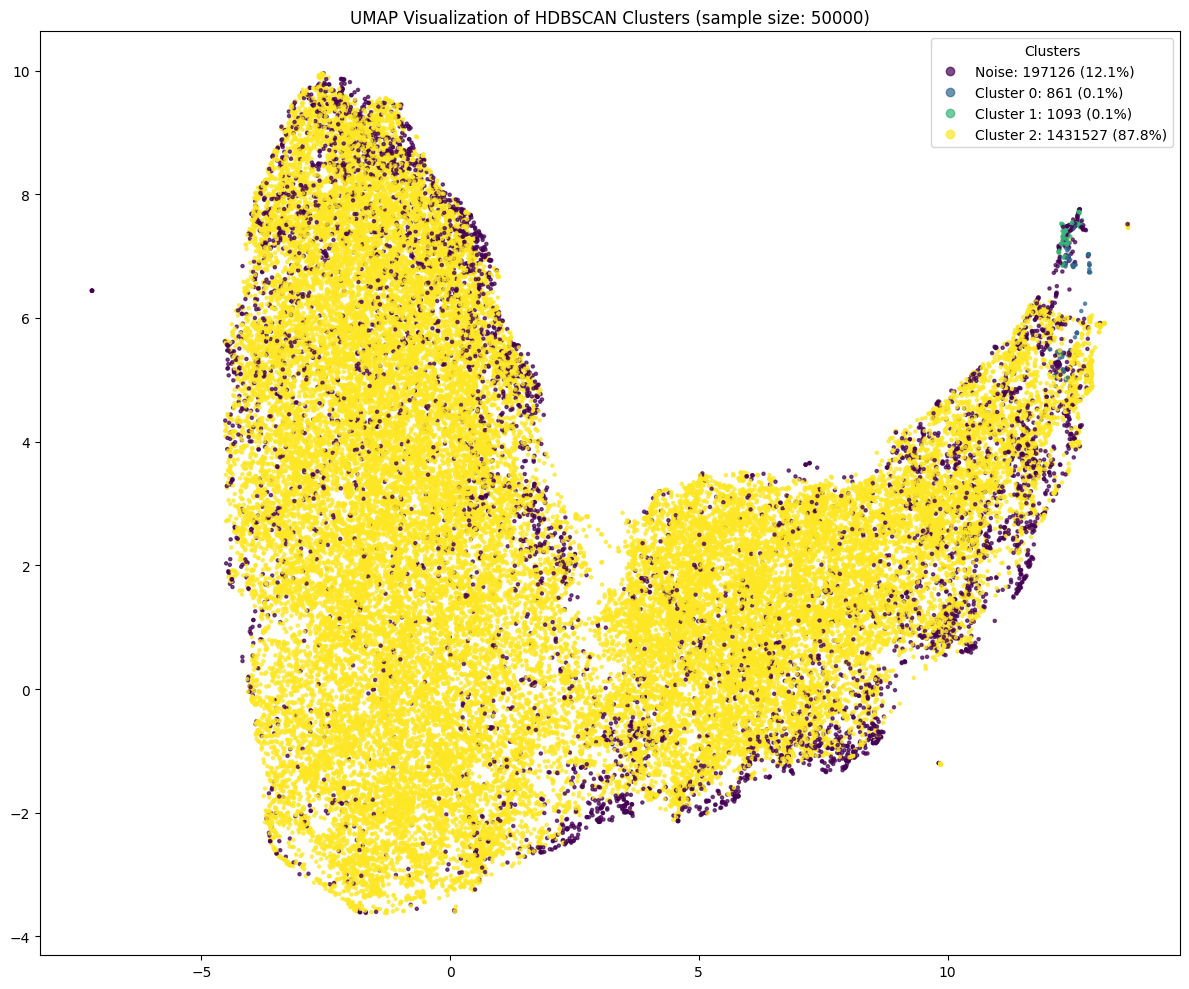

In [83]:
labels = np.load('clusters/hdbscan_labels_reduced10_mcs500_ms5.npy')

# 1. t-SNE visualization
# plot_tsne_clusters(reduced_normalized_embeddings_10, labels, n_samples=50000)

# 2. UMAP visualization (usually faster than t-SNE and often better at preserving global structure)
plot_umap_clusters(reduced_normalized_embeddings_10, labels, n_samples=50000)

# 3. 3D UMAP visualization
# plot_3d_umap_clusters(reduced_normalized_embeddings_10, labels, n_samples=50000)


In [9]:
# Run in a new cell to test different parameters
# # print("Testing with min_cluster_size=50, min_samples=10")
# clusterer, labels_100_5 = cached_hdbscan_fit(reduced_normalized_embeddings_10, min_cluster_size=100, min_samples=5)

# # # Save the results if you want
# np.save('clusters/hdbscan_labels_reduced10_mcs100_ms5.npy', labels_100_5)
# np.save('clusters/hdbscan_probabilities_reduced10_mcs100_ms5.npy', clusterer.probabilities_)

labels_100_5 = np.load('clusters/hdbscan_labels_reduced10_mcs100_ms5.npy')
# probabilities = np.load('clusters/hdbscan_probabilities_reduced10_mcs100_ms5.npy')

# Print statistics with metrics
# print_clustering_stats(reduced_normalized_embeddings_10, labels_100_5, max_sample_size=50000)

In [60]:
# Run in a new cell to test different parameters
# print("Testing with min_cluster_size=50, min_samples=10")
clusterer, labels = cached_hdbscan_fit(reduced_normalized_embeddings_10, min_cluster_size=500, min_samples=10)

# # Save the results if you want
np.save('hdbscan_labels_reduced10_mcs500_ms10.npy', labels)
np.save('hdbscan_probabilities_reduced10_mcs500_ms10.npy', clusterer.probabilities_)

labels = np.load('hdbscan_labels_reduced10_mcs500_ms10.npy')
probabilities = np.load('hdbscan_probabilities_reduced10_mcs500_ms10.npy')

# Print statistics with metrics
print_clustering_stats(reduced_normalized_embeddings_10, labels, max_sample_size=50000)

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-Oliver-AppData-Local-Temp-ipykernel-2969980735.cached_hdbscan_fit...
cached_hdbscan_fit(array([[-0.063863, ..., -0.025949],
       ...,
       [-0.003731, ...,  0.008829]], shape=(1630607, 10), dtype=float32), min_cluster_size=500, min_samples=10)
Computing HDBSCAN with min_cluster_size=500, min_samples=10
Computation took 2235.52 seconds
___________________________________________cached_hdbscan_fit - 2235.6s, 37.3min

Clustering Statistics:
Number of clusters: 3
Noise points: 197252 (12.10%)
Largest cluster: 1431401 points
Smallest cluster: 861 points
Average cluster size: 477785.0 points

Calculating metrics on a random subset of 50000 points...
Silhouette Score (-1 to 1, higher is better): 0.456
Calinski-Harabasz Score (higher is better): 772.5
Davies-Bouldin Score (lower is better): 1.191
--------------------------------------------------


In [ ]:
# Run in a new cell to test different parameters
# print("Testing with min_cluster_size=50, min_samples=10")
clusterer, labels = cached_hdbscan_fit(reduced_normalized_embeddings_10, min_cluster_size=500, min_samples=20)

# # Save the results if you want
np.save('hdbscan_labels_reduced10_mcs500_ms20.npy', labels)
np.save('hdbscan_probabilities_reduced10_mcs500_ms20.npy', clusterer.probabilities_)

labels = np.load('hdbscan_labels_reduced10_mcs500_ms20.npy')
probabilities = np.load('hdbscan_probabilities_reduced10_mcs500_ms20.npy')

# Print statistics with metrics
print_clustering_stats(reduced_normalized_embeddings_10, labels, max_sample_size=50000)

In [10]:
def test_hdbscan_params(data, min_cluster_size, min_samples=None, cluster_selection_epsilon=0.0):
    """
    Test HDBSCAN with parameters and print detailed statistics
    """
    global clusterer  # Make accessible for relative validity calculation
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon,
        metric='euclidean',
        cluster_selection_method='eom',
        core_dist_n_jobs=-1,
        leaf_size=100,
    )
    
    labels = clusterer.fit_predict(data)
    
    # Basic clustering statistics
    n_clusters = len(np.unique(labels)) - 1  # -1 for noise
    noise_points = np.sum(labels == -1)
    noise_ratio = noise_points / len(labels)
    
    # Cluster size statistics
    unique_labels = np.unique(labels)
    cluster_sizes = [np.sum(labels == label) for label in unique_labels if label != -1]
    
    if cluster_sizes:
        max_cluster = max(cluster_sizes)
        min_cluster = min(cluster_sizes)
        avg_cluster = np.mean(cluster_sizes)
    else:
        max_cluster = min_cluster = avg_cluster = 0
    
    print(f"\nResults for min_cluster_size={min_cluster_size}, min_samples={min_samples}")
    print(f"Number of points: {len(labels)}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Noise points: {noise_points} ({noise_ratio:.2%})")
    if cluster_sizes:
        print(f"Largest cluster: {max_cluster} points")
        print(f"Smallest cluster: {min_cluster} points")
        print(f"Average cluster size: {avg_cluster:.1f} points")
    
    # Only calculate metrics if we have more than one cluster and non-noise points
    metrics = {}
    if n_clusters > 1 and len(labels[labels != -1]) > 0:
        try:
            # Filter out noise points for metric calculation
            mask = labels != -1
            data_clean = data[mask]
            labels_clean = labels[mask]
            
            if len(np.unique(labels_clean)) > 1:
                # Silhouette Score
                try:
                    silhouette = silhouette_score(data_clean, labels_clean, sample_size=min(10000, len(data_clean)))
                    metrics['silhouette'] = silhouette
                except:
                    metrics['silhouette'] = None
                
                # Calinski-Harabasz Score
                try:
                    calinski = calinski_harabasz_score(data_clean, labels_clean)
                    metrics['calinski_harabasz'] = calinski
                except:
                    metrics['calinski_harabasz'] = None
                
                # Davies-Bouldin Score
                try:
                    davies = davies_bouldin_score(data_clean, labels_clean)
                    metrics['davies_bouldin'] = davies
                except:
                    metrics['davies_bouldin'] = None
                
                # HDBSCAN's relative validity
                try:
                    metrics['relative_validity'] = np.mean(clusterer.relative_validity_)
                except:
                    metrics['relative_validity'] = None
            else:
                metrics = {
                    'silhouette': None,
                    'calinski_harabasz': None,
                    'davies_bouldin': None,
                    'relative_validity': None
                }
        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
            metrics = {
                'silhouette': None,
                'calinski_harabasz': None,
                'davies_bouldin': None,
                'relative_validity': None
            }
    else:
        metrics = {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None,
            'relative_validity': None
        }
    
    print("\nClustering Quality Metrics:")
    print(f"Silhouette Score: {metrics.get('silhouette', 'N/A')}")
    print(f"Calinski-Harabasz Score: {metrics.get('calinski_harabasz', 'N/A')}")
    print(f"Davies-Bouldin Score: {metrics.get('davies_bouldin', 'N/A')}")
    print(f"HDBSCAN Relative Validity: {metrics.get('relative_validity', 'N/A')}")
    print("-" * 50)
    
    return labels, metrics


In [11]:
import numpy as np

# Assuming `reduced_normalized_embeddings_10` is a numpy array of shape (1.6e6, d)
n = len(reduced_normalized_embeddings_10)

# Compute sum of all embeddings
sum_embeddings = np.sum(reduced_normalized_embeddings_10, axis=0)

# Compute squared magnitude of the sum
sum_squared = np.dot(sum_embeddings, sum_embeddings)

# Calculate mean cosine similarity (for normalized embeddings)
mean_cosine_sim = (sum_squared - n) / (n * (n - 1))

# Convert to mean Euclidean distance (if needed)
mean_euclidean_sq = 2 - 2 * mean_cosine_sim
mean_distance = np.sqrt(mean_euclidean_sq)

print(f"Mean distance: {mean_distance:.4f}")

Mean distance: 1.4142


In [12]:
from scipy.spatial.distance import pdist

# Sample 1000 points (adjust based on memory)
sample_size = 1000
sample_indices = np.random.choice(n, size=sample_size, replace=False)
sample = reduced_normalized_embeddings_10[sample_indices]

# Compute pairwise distances within the sample
sample_distances = pdist(sample, metric='cosine')  # Use 'cosine' for BERT embeddings

# Get max and mean of the sample
max_distance_estimate = np.max(sample_distances)
mean_distance_estimate = np.mean(sample_distances)

print(f"Sampled Max Distance: {max_distance_estimate:.4f}")
print(f"Sampled Mean Distance: {mean_distance_estimate:.4f}")

Sampled Max Distance: 1.9744
Sampled Mean Distance: 0.9923


In [38]:
import hdbscan
import numpy as np
from joblib import Memory
from time import time
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm

# Test combinations focusing on min_samples 10 and 20 with different epsilon values
param_combinations = [
    # Baseline with min_samples=10
    {'min_cluster_size': 10, 'min_samples': 5, 'cluster_selection_epsilon': 0.0},
    
    # Testing different epsilon values with min_samples=10
    {'min_cluster_size': 20, 'min_samples': 5, 'cluster_selection_epsilon': 0.00},
    {'min_cluster_size': 50, 'min_samples': 5, 'cluster_selection_epsilon': 0.00},
    {'min_cluster_size': 100, 'min_samples': 5, 'cluster_selection_epsilon': 0.0},
    
    # Baseline with min_samples=20
    {'min_cluster_size': 200, 'min_samples': 5, 'cluster_selection_epsilon': 0.0},
    
    # Testing different epsilon values with min_samples=20
    {'min_cluster_size': 500, 'min_samples': 5, 'cluster_selection_epsilon': 0.00},
    {'min_cluster_size': 1000, 'min_samples': 5, 'cluster_selection_epsilon': 0.00},
    {'min_cluster_size': 2000, 'min_samples': 5, 'cluster_selection_epsilon': 0.0},
]

# Store results
results = {}

# Run tests with progress bar
print("Testing parameter combinations on sample data...")
for params in tqdm(param_combinations):
    key = f"mcs_{params['min_cluster_size']}_ms_{params['min_samples']}_eps_{params['cluster_selection_epsilon']}"
    labels, metrics = test_hdbscan_params(
        reduced_normalized_embeddings_10, 
        min_cluster_size=params['min_cluster_size'],
        min_samples=params['min_samples'],
        cluster_selection_epsilon=params['cluster_selection_epsilon']
    )
    
    results[key] = {
        'labels': labels,
        'metrics': metrics,
        'params': params
    }

# Analyze and compare results
print("\nSummary of Best Parameters:")
metric_rankings = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

for key, result in results.items():
    metrics = result['metrics']
    if metrics['silhouette'] is not None:
        metric_rankings['silhouette'].append((metrics['silhouette'], key))
    if metrics['calinski_harabasz'] is not None:
        metric_rankings['calinski_harabasz'].append((metrics['calinski_harabasz'], key))
    if metrics['davies_bouldin'] is not None:
        metric_rankings['davies_bouldin'].append((metrics['davies_bouldin'], key))

print("\nNoise Ratio Comparison:")
for key, result in results.items():
    labels = result['labels']
    noise_ratio = np.sum(labels == -1) / len(labels)
    print(f"{key}: {noise_ratio:.2%} noise")

print("\nBest parameters according to different metrics:")
print("\nSilhouette Score (higher is better):")
for score, key in sorted(metric_rankings['silhouette'], reverse=True)[:3]:
    print(f"{key}: {score:.3f}")

print("\nCalinski-Harabasz Score (higher is better):")
for score, key in sorted(metric_rankings['calinski_harabasz'], reverse=True)[:3]:
    print(f"{key}: {score:.1f}")

print("\nDavies-Bouldin Score (lower is better):")
for score, key in sorted(metric_rankings['davies_bouldin'])[:3]:
    print(f"{key}: {score:.3f}")

Testing parameter combinations on sample data...


  0%|          | 0/8 [00:00<?, ?it/s]


Results for min_cluster_size=10, min_samples=5
Number of points: 1630607
Number of clusters: 133226
Noise points: 21461 (1.32%)
Largest cluster: 252 points
Smallest cluster: 10 points
Average cluster size: 12.1 points


 12%|█▎        | 1/8 [1:21:01<9:27:08, 4861.26s/it]


Clustering Quality Metrics:
Silhouette Score: 0.06867315620183945
Calinski-Harabasz Score: 69851.8984375
Davies-Bouldin Score: None
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=5
Number of points: 1630607
Number of clusters: 28948
Noise points: 671880 (41.20%)
Largest cluster: 252 points
Smallest cluster: 20 points
Average cluster size: 33.1 points


 25%|██▌       | 2/8 [2:12:19<6:21:13, 3812.33s/it]


Clustering Quality Metrics:
Silhouette Score: 0.13848012685775757
Calinski-Harabasz Score: 2789.906005859375
Davies-Bouldin Score: 0.9797935434238085
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=50, min_samples=5
Number of points: 1630607
Number of clusters: 5041
Noise points: 1154649 (70.81%)
Largest cluster: 1128 points
Smallest cluster: 50 points
Average cluster size: 94.4 points


 38%|███▊      | 3/8 [2:50:07<4:18:56, 3107.31s/it]


Clustering Quality Metrics:
Silhouette Score: 0.15915682911872864
Calinski-Harabasz Score: 3420.25439453125
Davies-Bouldin Score: 1.3801269325479744
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=100, min_samples=5
Number of points: 1630607
Number of clusters: 1576
Noise points: 1349327 (82.75%)
Largest cluster: 1224 points
Smallest cluster: 100 points
Average cluster size: 178.5 points


 50%|█████     | 4/8 [3:27:19<3:04:06, 2761.54s/it]


Clustering Quality Metrics:
Silhouette Score: 0.1522960662841797
Calinski-Harabasz Score: 4717.7265625
Davies-Bouldin Score: 1.549136287662748
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=200, min_samples=5
Number of points: 1630607
Number of clusters: 23
Noise points: 484123 (29.69%)
Largest cluster: 1138673 points
Smallest cluster: 202 points
Average cluster size: 49847.1 points


 62%|██████▎   | 5/8 [4:04:12<2:08:11, 2563.70s/it]


Clustering Quality Metrics:
Silhouette Score: -0.1632358878850937
Calinski-Harabasz Score: 1746.5179443359375
Davies-Bouldin Score: 1.1591693276691277
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=500, min_samples=5
Number of points: 1630607
Number of clusters: 3
Noise points: 197126 (12.09%)
Largest cluster: 1431527 points
Smallest cluster: 861 points
Average cluster size: 477827.0 points


 75%|███████▌  | 6/8 [4:41:12<1:21:34, 2447.04s/it]


Clustering Quality Metrics:
Silhouette Score: 0.49407559633255005
Calinski-Harabasz Score: 6167.134765625
Davies-Bouldin Score: 1.1571102394992112
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=1000, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 197987 (12.14%)
Largest cluster: 1431527 points
Smallest cluster: 1093 points
Average cluster size: 716310.0 points


 88%|████████▊ | 7/8 [5:18:10<39:32, 2372.20s/it]  


Clustering Quality Metrics:
Silhouette Score: 0.5108039379119873
Calinski-Harabasz Score: 7386.55859375
Davies-Bouldin Score: 0.5028804940327203
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=2000, min_samples=5
Number of points: 1630607
Number of clusters: 5
Noise points: 1153832 (70.76%)
Largest cluster: 466710 points
Smallest cluster: 2102 points
Average cluster size: 95355.0 points


100%|██████████| 8/8 [5:55:10<00:00, 2663.78s/it]


Clustering Quality Metrics:
Silhouette Score: 0.2222326099872589
Calinski-Harabasz Score: 14782.166015625
Davies-Bouldin Score: 1.0739088480733057
HDBSCAN Relative Validity: None
--------------------------------------------------

Summary of Best Parameters:

Noise Ratio Comparison:
mcs_10_ms_5_eps_0.0: 1.32% noise
mcs_20_ms_5_eps_0.0: 41.20% noise
mcs_50_ms_5_eps_0.0: 70.81% noise
mcs_100_ms_5_eps_0.0: 82.75% noise
mcs_200_ms_5_eps_0.0: 29.69% noise
mcs_500_ms_5_eps_0.0: 12.09% noise
mcs_1000_ms_5_eps_0.0: 12.14% noise
mcs_2000_ms_5_eps_0.0: 70.76% noise

Best parameters according to different metrics:

Silhouette Score (higher is better):
mcs_1000_ms_5_eps_0.0: 0.511
mcs_500_ms_5_eps_0.0: 0.494
mcs_2000_ms_5_eps_0.0: 0.222

Calinski-Harabasz Score (higher is better):
mcs_10_ms_5_eps_0.0: 69851.9
mcs_2000_ms_5_eps_0.0: 14782.2
mcs_1000_ms_5_eps_0.0: 7386.6

Davies-Bouldin Score (lower is better):
mcs_1000_ms_5_eps_0.0: 0.503
mcs_20_ms_5_eps_0.0: 0.980
mcs_2000_ms_5_eps_0.0: 1.074


In [5]:
import hdbscan
import numpy as np
from joblib import Memory
from time import time
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm

# Test combinations focusing on min_samples 5 with different epsilon values
param_combinations = [
    # Testing different epsilon values with min_cluster_size=50
    {'min_cluster_size': 50, 'min_samples': 5, 'cluster_selection_epsilon': 0.1},
    {'min_cluster_size': 50, 'min_samples': 5, 'cluster_selection_epsilon': 0.2},
    {'min_cluster_size': 50, 'min_samples': 5, 'cluster_selection_epsilon': 0.3},
    {'min_cluster_size': 50, 'min_samples': 5, 'cluster_selection_epsilon': 0.4},
    {'min_cluster_size': 50, 'min_samples': 5, 'cluster_selection_epsilon': 0.5},
    {'min_cluster_size': 50, 'min_samples': 5, 'cluster_selection_epsilon': 0.6},
    
    # Testing different epsilon values with min_cluster_size=100
    {'min_cluster_size': 100, 'min_samples': 5, 'cluster_selection_epsilon': 0.1},
    {'min_cluster_size': 100, 'min_samples': 5, 'cluster_selection_epsilon': 0.2},
    {'min_cluster_size': 100, 'min_samples': 5, 'cluster_selection_epsilon': 0.3},
    {'min_cluster_size': 100, 'min_samples': 5, 'cluster_selection_epsilon': 0.4},
    {'min_cluster_size': 100, 'min_samples': 5, 'cluster_selection_epsilon': 0.5},
    {'min_cluster_size': 100, 'min_samples': 5, 'cluster_selection_epsilon': 0.6},
    
    # Testing different epsilon values with min_cluster_size=200
    {'min_cluster_size': 200, 'min_samples': 5, 'cluster_selection_epsilon': 0.1},
    {'min_cluster_size': 200, 'min_samples': 5, 'cluster_selection_epsilon': 0.2},
    {'min_cluster_size': 200, 'min_samples': 5, 'cluster_selection_epsilon': 0.3},
    {'min_cluster_size': 200, 'min_samples': 5, 'cluster_selection_epsilon': 0.4},
    {'min_cluster_size': 200, 'min_samples': 5, 'cluster_selection_epsilon': 0.5},
    {'min_cluster_size': 200, 'min_samples': 5, 'cluster_selection_epsilon': 0.6},
    
    # Testing different epsilon values with min_cluster_size=500
    {'min_cluster_size': 500, 'min_samples': 5, 'cluster_selection_epsilon': 0.1},
    {'min_cluster_size': 500, 'min_samples': 5, 'cluster_selection_epsilon': 0.2},
    {'min_cluster_size': 500, 'min_samples': 5, 'cluster_selection_epsilon': 0.3},
    {'min_cluster_size': 500, 'min_samples': 5, 'cluster_selection_epsilon': 0.4},
    {'min_cluster_size': 500, 'min_samples': 5, 'cluster_selection_epsilon': 0.5},
    {'min_cluster_size': 500, 'min_samples': 5, 'cluster_selection_epsilon': 0.6},
    
    # Testing different epsilon values with min_cluster_size=1000
    {'min_cluster_size': 1000, 'min_samples': 5, 'cluster_selection_epsilon': 0.1},
    {'min_cluster_size': 1000, 'min_samples': 5, 'cluster_selection_epsilon': 0.2},
    {'min_cluster_size': 1000, 'min_samples': 5, 'cluster_selection_epsilon': 0.3},
    {'min_cluster_size': 1000, 'min_samples': 5, 'cluster_selection_epsilon': 0.4},
    {'min_cluster_size': 1000, 'min_samples': 5, 'cluster_selection_epsilon': 0.5},
    {'min_cluster_size': 1000, 'min_samples': 5, 'cluster_selection_epsilon': 0.6},
]

# Store results
results = {}

# Run tests with progress bar
print("Testing parameter combinations on sample data...")
for params in tqdm(param_combinations):
    key = f"mcs_{params['min_cluster_size']}_ms_{params['min_samples']}_eps_{params['cluster_selection_epsilon']}"
    labels, metrics = test_hdbscan_params(
        reduced_normalized_embeddings_10, 
        min_cluster_size=params['min_cluster_size'],
        min_samples=params['min_samples'],
        cluster_selection_epsilon=params['cluster_selection_epsilon']
    )
    
    results[key] = {
        'labels': labels,
        'metrics': metrics,
        'params': params
    }

# Analyze and compare results
print("\nSummary of Best Parameters:")
metric_rankings = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

for key, result in results.items():
    metrics = result['metrics']
    if metrics['silhouette'] is not None:
        metric_rankings['silhouette'].append((metrics['silhouette'], key))
    if metrics['calinski_harabasz'] is not None:
        metric_rankings['calinski_harabasz'].append((metrics['calinski_harabasz'], key))
    if metrics['davies_bouldin'] is not None:
        metric_rankings['davies_bouldin'].append((metrics['davies_bouldin'], key))

print("\nNoise Ratio Comparison:")
for key, result in results.items():
    labels = result['labels']
    noise_ratio = np.sum(labels == -1) / len(labels)
    print(f"{key}: {noise_ratio:.2%} noise")

print("\nBest parameters according to different metrics:")
print("\nSilhouette Score (higher is better):")
for score, key in sorted(metric_rankings['silhouette'], reverse=True)[:3]:
    print(f"{key}: {score:.3f}")

print("\nCalinski-Harabasz Score (higher is better):")
for score, key in sorted(metric_rankings['calinski_harabasz'], reverse=True)[:3]:
    print(f"{key}: {score:.1f}")

print("\nDavies-Bouldin Score (lower is better):")
for score, key in sorted(metric_rankings['davies_bouldin'])[:3]:
    print(f"{key}: {score:.3f}")

Testing parameter combinations on sample data...


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=50, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 800 (0.05%)
Largest cluster: 1629735 points
Smallest cluster: 72 points
Average cluster size: 814903.5 points


  3%|▎         | 1/30 [38:13<18:28:34, 2293.60s/it]


Clustering Quality Metrics:
Silhouette Score: 0.4936554729938507
Calinski-Harabasz Score: 476.20916748046875
Davies-Bouldin Score: 0.45954845879946166
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=50, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 800 (0.05%)
Largest cluster: 1629735 points
Smallest cluster: 72 points
Average cluster size: 814903.5 points


  7%|▋         | 2/30 [1:16:03<17:43:45, 2279.47s/it]


Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: 476.20916748046875
Davies-Bouldin Score: 0.45954845879946166
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=50, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 800 (0.05%)
Largest cluster: 1629735 points
Smallest cluster: 72 points
Average cluster size: 814903.5 points


 10%|█         | 3/30 [1:53:45<17:02:19, 2271.84s/it]


Clustering Quality Metrics:
Silhouette Score: 0.4983639717102051
Calinski-Harabasz Score: 476.20916748046875
Davies-Bouldin Score: 0.45954845879946166
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=50, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 800 (0.05%)
Largest cluster: 1629735 points
Smallest cluster: 72 points
Average cluster size: 814903.5 points


 13%|█▎        | 4/30 [2:31:25<16:22:26, 2267.18s/it]


Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: 476.20916748046875
Davies-Bouldin Score: 0.45954845879946166
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=50, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 800 (0.05%)
Largest cluster: 1629735 points
Smallest cluster: 72 points
Average cluster size: 814903.5 points


 17%|█▋        | 5/30 [3:09:16<15:45:13, 2268.53s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5044466853141785
Calinski-Harabasz Score: 476.20916748046875
Davies-Bouldin Score: 0.45954845879946166
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=50, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 800 (0.05%)
Largest cluster: 1629735 points
Smallest cluster: 72 points
Average cluster size: 814903.5 points


 20%|██        | 6/30 [3:46:49<15:05:18, 2263.26s/it]


Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: 476.20916748046875
Davies-Bouldin Score: 0.45954845879946166
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=100, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 8994 (0.55%)
Largest cluster: 1621505 points
Smallest cluster: 108 points
Average cluster size: 810806.5 points


 23%|██▎       | 7/30 [4:24:01<14:23:40, 2253.06s/it]


Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: 572.6455688476562
Davies-Bouldin Score: 0.5364138158645401
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=100, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 8994 (0.55%)
Largest cluster: 1621505 points
Smallest cluster: 108 points
Average cluster size: 810806.5 points


 27%|██▋       | 8/30 [5:01:10<13:43:15, 2245.24s/it]


Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: 572.6455688476562
Davies-Bouldin Score: 0.5364138158645401
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=100, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 8994 (0.55%)
Largest cluster: 1621505 points
Smallest cluster: 108 points
Average cluster size: 810806.5 points


 30%|███       | 9/30 [5:38:22<13:04:22, 2241.05s/it]


Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: 572.6455688476562
Davies-Bouldin Score: 0.5364138158645401
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=100, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 8994 (0.55%)
Largest cluster: 1621505 points
Smallest cluster: 108 points
Average cluster size: 810806.5 points


 33%|███▎      | 10/30 [6:15:47<12:27:24, 2242.23s/it]


Clustering Quality Metrics:
Silhouette Score: 0.449521005153656
Calinski-Harabasz Score: 572.6455688476562
Davies-Bouldin Score: 0.5364138158645401
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=100, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 8994 (0.55%)
Largest cluster: 1621505 points
Smallest cluster: 108 points
Average cluster size: 810806.5 points


 37%|███▋      | 11/30 [6:53:04<11:49:36, 2240.85s/it]


Clustering Quality Metrics:
Silhouette Score: 0.4494103491306305
Calinski-Harabasz Score: 572.6455688476562
Davies-Bouldin Score: 0.5364138158645401
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=100, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 8994 (0.55%)
Largest cluster: 1621505 points
Smallest cluster: 108 points
Average cluster size: 810806.5 points


 40%|████      | 12/30 [7:30:32<11:12:50, 2242.82s/it]


Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: 572.6455688476562
Davies-Bouldin Score: 0.5364138158645401
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=200, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 81851 (5.02%)
Largest cluster: 1548552 points
Smallest cluster: 204 points
Average cluster size: 774378.0 points


 43%|████▎     | 13/30 [8:08:02<10:36:07, 2245.17s/it]


Clustering Quality Metrics:
Silhouette Score: 0.3164338171482086
Calinski-Harabasz Score: 666.6766967773438
Davies-Bouldin Score: 0.6717256504145201
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=200, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 81851 (5.02%)
Largest cluster: 1548552 points
Smallest cluster: 204 points
Average cluster size: 774378.0 points


 47%|████▋     | 14/30 [8:45:35<9:59:18, 2247.43s/it] 


Clustering Quality Metrics:
Silhouette Score: 0.27446988224983215
Calinski-Harabasz Score: 666.6766967773438
Davies-Bouldin Score: 0.6717256504145201
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=200, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 81851 (5.02%)
Largest cluster: 1548552 points
Smallest cluster: 204 points
Average cluster size: 774378.0 points


 50%|█████     | 15/30 [9:23:03<9:21:55, 2247.73s/it]


Clustering Quality Metrics:
Silhouette Score: 0.29644423723220825
Calinski-Harabasz Score: 666.6766967773438
Davies-Bouldin Score: 0.6717256504145201
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=200, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 81851 (5.02%)
Largest cluster: 1548552 points
Smallest cluster: 204 points
Average cluster size: 774378.0 points


 53%|█████▎    | 16/30 [10:00:33<8:44:35, 2248.24s/it]


Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: 666.6766967773438
Davies-Bouldin Score: 0.6717256504145201
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=200, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 81851 (5.02%)
Largest cluster: 1548552 points
Smallest cluster: 204 points
Average cluster size: 774378.0 points


 57%|█████▋    | 17/30 [10:38:02<8:07:11, 2248.57s/it]


Clustering Quality Metrics:
Silhouette Score: 0.31275156140327454
Calinski-Harabasz Score: 666.6766967773438
Davies-Bouldin Score: 0.6717256504145201
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=200, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 81851 (5.02%)
Largest cluster: 1548552 points
Smallest cluster: 204 points
Average cluster size: 774378.0 points


 60%|██████    | 18/30 [11:15:30<7:29:41, 2248.44s/it]


Clustering Quality Metrics:
Silhouette Score: 0.3291429579257965
Calinski-Harabasz Score: 666.6766967773438
Davies-Bouldin Score: 0.6717256504145201
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=500, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 185700 (11.39%)
Largest cluster: 1444046 points
Smallest cluster: 861 points
Average cluster size: 722453.5 points


 63%|██████▎   | 19/30 [11:52:50<6:51:43, 2245.74s/it]


Clustering Quality Metrics:
Silhouette Score: 0.4786940813064575
Calinski-Harabasz Score: 4886.1318359375
Davies-Bouldin Score: 0.5632998043064799
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=500, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 185700 (11.39%)
Largest cluster: 1444046 points
Smallest cluster: 861 points
Average cluster size: 722453.5 points


 67%|██████▋   | 20/30 [12:30:11<6:14:04, 2244.43s/it]


Clustering Quality Metrics:
Silhouette Score: 0.46305596828460693
Calinski-Harabasz Score: 4886.1318359375
Davies-Bouldin Score: 0.5632998043064799
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=500, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 185700 (11.39%)
Largest cluster: 1444046 points
Smallest cluster: 861 points
Average cluster size: 722453.5 points


 70%|███████   | 21/30 [13:08:04<5:37:55, 2252.83s/it]


Clustering Quality Metrics:
Silhouette Score: 0.4616103172302246
Calinski-Harabasz Score: 4886.1318359375
Davies-Bouldin Score: 0.5632998043064799
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=500, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 185700 (11.39%)
Largest cluster: 1444046 points
Smallest cluster: 861 points
Average cluster size: 722453.5 points


 73%|███████▎  | 22/30 [13:45:57<5:01:11, 2258.88s/it]


Clustering Quality Metrics:
Silhouette Score: 0.47089725732803345
Calinski-Harabasz Score: 4886.1318359375
Davies-Bouldin Score: 0.5632998043064799
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=500, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 185700 (11.39%)
Largest cluster: 1444046 points
Smallest cluster: 861 points
Average cluster size: 722453.5 points


 77%|███████▋  | 23/30 [14:23:40<4:23:42, 2260.39s/it]


Clustering Quality Metrics:
Silhouette Score: 0.49796587228775024
Calinski-Harabasz Score: 4886.1318359375
Davies-Bouldin Score: 0.5632998043064799
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=500, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 185700 (11.39%)
Largest cluster: 1444046 points
Smallest cluster: 861 points
Average cluster size: 722453.5 points


 80%|████████  | 24/30 [15:01:19<3:45:58, 2259.77s/it]


Clustering Quality Metrics:
Silhouette Score: 0.46215391159057617
Calinski-Harabasz Score: 4886.1318359375
Davies-Bouldin Score: 0.5632998043064799
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=1000, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 197987 (12.14%)
Largest cluster: 1431527 points
Smallest cluster: 1093 points
Average cluster size: 716310.0 points


 83%|████████▎ | 25/30 [15:39:02<3:08:24, 2260.85s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5013607144355774
Calinski-Harabasz Score: 7386.55859375
Davies-Bouldin Score: 0.5028804940327203
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=1000, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 197987 (12.14%)
Largest cluster: 1431527 points
Smallest cluster: 1093 points
Average cluster size: 716310.0 points


 87%|████████▋ | 26/30 [16:17:27<2:31:35, 2273.95s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5075041055679321
Calinski-Harabasz Score: 7386.55859375
Davies-Bouldin Score: 0.5028804940327203
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=1000, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 197987 (12.14%)
Largest cluster: 1431527 points
Smallest cluster: 1093 points
Average cluster size: 716310.0 points


 90%|█████████ | 27/30 [16:55:29<1:53:49, 2276.40s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5061149597167969
Calinski-Harabasz Score: 7386.55859375
Davies-Bouldin Score: 0.5028804940327203
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=1000, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 197987 (12.14%)
Largest cluster: 1431527 points
Smallest cluster: 1093 points
Average cluster size: 716310.0 points


 93%|█████████▎| 28/30 [17:33:43<1:16:03, 2281.78s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5220732688903809
Calinski-Harabasz Score: 7386.55859375
Davies-Bouldin Score: 0.5028804940327203
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=1000, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 197987 (12.14%)
Largest cluster: 1431527 points
Smallest cluster: 1093 points
Average cluster size: 716310.0 points


 97%|█████████▋| 29/30 [18:11:18<37:53, 2273.81s/it]  


Clustering Quality Metrics:
Silhouette Score: 0.5083399415016174
Calinski-Harabasz Score: 7386.55859375
Davies-Bouldin Score: 0.5028804940327203
HDBSCAN Relative Validity: None
--------------------------------------------------


c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size=1000, min_samples=5
Number of points: 1630607
Number of clusters: 2
Noise points: 197987 (12.14%)
Largest cluster: 1431527 points
Smallest cluster: 1093 points
Average cluster size: 716310.0 points


100%|██████████| 30/30 [18:48:46<00:00, 2257.57s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5015627145767212
Calinski-Harabasz Score: 7386.55859375
Davies-Bouldin Score: 0.5028804940327203
HDBSCAN Relative Validity: None
--------------------------------------------------

Summary of Best Parameters:

Noise Ratio Comparison:
mcs_50_ms_5_eps_0.1: 0.05% noise
mcs_50_ms_5_eps_0.2: 0.05% noise
mcs_50_ms_5_eps_0.3: 0.05% noise
mcs_50_ms_5_eps_0.4: 0.05% noise
mcs_50_ms_5_eps_0.5: 0.05% noise
mcs_50_ms_5_eps_0.6: 0.05% noise
mcs_100_ms_5_eps_0.1: 0.55% noise
mcs_100_ms_5_eps_0.2: 0.55% noise
mcs_100_ms_5_eps_0.3: 0.55% noise
mcs_100_ms_5_eps_0.4: 0.55% noise
mcs_100_ms_5_eps_0.5: 0.55% noise
mcs_100_ms_5_eps_0.6: 0.55% noise
mcs_200_ms_5_eps_0.1: 5.02% noise
mcs_200_ms_5_eps_0.2: 5.02% noise
mcs_200_ms_5_eps_0.3: 5.02% noise
mcs_200_ms_5_eps_0.4: 5.02% noise
mcs_200_ms_5_eps_0.5: 5.02% noise
mcs_200_ms_5_eps_0.6: 5.02% noise
mcs_500_ms_5_eps_0.1: 11.39% noise
mcs_500_ms_5_eps_0.2: 11.39% noise
mcs_500_ms_5_eps_0.3: 11.39% noise
mcs_50

In [68]:
# Run in a new cell to test different parameters
# print("Testing with min_cluster_size=50, min_samples=10")
clusterer, labels = cached_hdbscan_fit(reduced_normalized_embeddings_10, min_cluster_size=5000, min_samples=5)

# # Save the results if you want
np.save('hdbscan_labels_reduced10_mcs5000_ms5.npy', labels)
np.save('hdbscan_probabilities_reduced10_mcs5000_ms5.npy', clusterer.probabilities_)

labels = np.load('hdbscan_labels_reduced10_mcs5000_ms5.npy')
probabilities = np.load('hdbscan_probabilities_reduced10_mcs5000_ms5.npy')

# Print statistics with metrics
print_clustering_stats(reduced_normalized_embeddings_10, labels, max_sample_size=50000)

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-Oliver-AppData-Local-Temp-ipykernel-2969980735.cached_hdbscan_fit...
cached_hdbscan_fit(array([[-0.063863, ..., -0.025949],
       ...,
       [-0.003731, ...,  0.008829]], shape=(1630607, 10), dtype=float32), min_cluster_size=5000, min_samples=5)
Computing HDBSCAN with min_cluster_size=5000, min_samples=5
Computation took 2263.66 seconds
___________________________________________cached_hdbscan_fit - 2263.7s, 37.7min

Clustering Statistics:
Number of clusters: 2
Noise points: 805052 (49.37%)
Largest cluster: 816698 points
Smallest cluster: 8857 points
Average cluster size: 412777.5 points

Calculating metrics on a random subset of 50000 points...
Silhouette Score (-1 to 1, higher is better): 0.505
Calinski-Harabasz Score (higher is better): 2233.4
Davies-Bouldin Score (lower is better): 0.563
--------------------------------------------------


### Use Diversity metric to sample from clusters to create subset

In [5]:
import numpy as np
from tqdm import tqdm

def diversity_sampling(
    embeddings, 
    labels, 
    query_ratio=0.1,              # Controls how many points to compare against
    target_samples=10000,         # Absolute target sample count
    min_cluster_samples=1         # Minimum samples per cluster
):
    """
    Sample points from clusters using diversity scores, targeting a specific number of samples.
    Implements methodology from Section 3.3.1 of the paper.
    """
    # Get non-noise clusters and their sizes
    unique_clusters = np.unique(labels)
    unique_clusters = unique_clusters[unique_clusters != -1]
    cluster_sizes = {cid: np.sum(labels == cid) for cid in unique_clusters}
    total_non_noise = sum(cluster_sizes.values())
    
    # Calculate effective compression ratio
    effective_ratio = target_samples / total_non_noise
    print(f"Target samples: {target_samples}")
    print(f"Non-noise points: {total_non_noise}")
    print(f"Effective compression ratio: {effective_ratio:.4f}")
    
    # Calculate quota for each cluster
    quotas = {}
    for cid, size in cluster_sizes.items():
        quota = max(
            min_cluster_samples,
            int(effective_ratio * size)
        )
        quotas[cid] = quota
    
    # Adjust quotas to match target_samples
    quota_sum = sum(quotas.values())
    remaining = target_samples - quota_sum
    
    if remaining != 0:
        # Distribute remaining samples proportionally to cluster size
        sorted_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)
        for i in range(abs(remaining)):
            cid = sorted_clusters[i % len(sorted_clusters)][0]
            quotas[cid] += 1 if remaining > 0 else -1
            if quotas[cid] <= 0:  # Ensure no negative quotas
                quotas[cid] = 1
    
    # Process clusters
    selected_indices = []
    cluster_stats = {}
    
    for cluster_id in tqdm(unique_clusters, desc="Processing clusters"):
        quota = quotas[cluster_id]
        cluster_mask = (labels == cluster_id)
        cluster_indices = np.where(cluster_mask)[0]
        cluster_embeddings = embeddings[cluster_mask]
        n_points = len(cluster_embeddings)
        
        cluster_stats[cluster_id] = {
            'size': n_points, 
            'quota': quota,
            'status': 'processed'
        }
        
        if n_points <= quota:
            # Take all points if quota >= cluster size
            selected_indices.extend(cluster_indices)
            cluster_stats[cluster_id]['status'] = 'full_cluster'
            continue
            
        # Select query set
        query_size = max(1, min(int(query_ratio * n_points), n_points // 2))
        query_indices = np.random.choice(n_points, size=query_size, replace=False)
        K = cluster_embeddings[query_indices]
        
        try:
            # Compute diversity scores
            similarity_matrix = np.dot(cluster_embeddings, K.T)
            distance_matrix = 1 - similarity_matrix  # Convert similarity to distance
            diversity_scores = np.min(distance_matrix, axis=1)
            
            # Handle points with zero diversity (typically query points themselves)
            if np.any(diversity_scores == 0):
                mean_diversity = np.mean(diversity_scores[diversity_scores > 0]) if np.any(diversity_scores > 0) else 0.1
                diversity_scores[diversity_scores == 0] = mean_diversity / 2
            
            # Sample points proportionally to diversity
            probabilities = diversity_scores / np.sum(diversity_scores)
            probabilities = probabilities / np.sum(probabilities)  # Ensure exact sum to 1
            
            # Determine whether to use probability-based sampling or just take top-K
            if n_points > 5 * quota:  # For large clusters, probability sampling
                selected = np.random.choice(
                    n_points, 
                    size=quota, 
                    replace=False, 
                    p=probabilities
                )
                cluster_stats[cluster_id]['status'] = 'diversity_sampled_prob'
            else:
                # For smaller clusters, just take the top-K most diverse points
                selected = np.argsort(-diversity_scores)[:quota]
                cluster_stats[cluster_id]['status'] = 'diversity_sampled_top'
                
            selected_indices.extend(cluster_indices[selected])
            
        except Exception as e:
            # Fallback to random sampling on error
            selected = np.random.choice(n_points, size=quota, replace=False)
            selected_indices.extend(cluster_indices[selected])
            cluster_stats[cluster_id]['status'] = f'error_fallback'
            print(f"Error in cluster {cluster_id}: {str(e)}")

    # Final validation
    selected_indices = np.array(selected_indices)
    actual_samples = len(selected_indices)
    
    # Trim if needed to match exact target
    if actual_samples > target_samples:
        excess = actual_samples - target_samples
        print(f"Trimming {excess} excess samples...")
        # Remove points randomly
        to_remove = np.random.choice(actual_samples, size=excess, replace=False)
        mask = np.ones(actual_samples, dtype=bool)
        mask[to_remove] = False
        selected_indices = selected_indices[mask]
    
    # Print statistics
    status_counts = {}
    samples_by_status = {}
    for cid, stats in cluster_stats.items():
        status = stats['status']
        if status not in status_counts:
            status_counts[status] = 0
            samples_by_status[status] = 0
        status_counts[status] += 1
        samples_by_status[status] += stats['quota']
    
    print(f"\nSampling Summary (Target: {target_samples} samples):")
    print(f"- Total clusters: {len(unique_clusters)}")
    for status, count in status_counts.items():
        print(f"  - {status}: {count} clusters, {samples_by_status[status]} samples")
    print(f"- Final sample count: {len(selected_indices)}")
    
    return selected_indices

In [17]:
# labels_100_ms5 = np.load('clusters/hdbscan_labels_reduced10_mcs100_ms5.npy')
# subset_indices_100_5 = diversity_sampling(reduced_normalized_embeddings_10, labels_100_5, query_ratio=0.1, target_samples=7000, min_cluster_samples=1)
create_subset_jsonl_efficient(r'subsets\ast-pyedur_full.jsonl', subset_indices_100_5, 'ast-pyedur_full_subset_100_5_7000.jsonl')

Processing chunks: 100%|██████████| 17/17 [10:40<00:00, 37.69s/it]

Subset created with 7000 samples
Saved to: ast-pyedur_full_subset_100_5_7000.jsonl


In [10]:
labels_20_ms5 = np.load('clusters/hdbscan_labels_reduced10_mcs20_ms5.npy')
subset_indices_20_5 = diversity_sampling(reduced_normalized_embeddings_10, labels_20_ms5, query_ratio=0.1, target_samples=10000, min_cluster_samples=1)

Target samples: 10000
Non-noise points: 958727
Effective compression ratio: 0.0104


Processing clusters: 100%|██████████| 28948/28948 [02:42<00:00, 178.04it/s]

Trimming 18948 excess samples...

Sampling Summary (Target: 10000 samples):
- Total clusters: 28948
  - diversity_sampled_prob: 28948 clusters, 28948 samples
- Final sample count: 10000


In [ ]:
labels_500_ms5 = np.load('hdbscan_labels_reduced10_mcs500_ms5.npy')
subset_indices_500_5 = diversity_sampling(reduced_normalized_embeddings_10, labels, query_ratio=0.1, target_samples=10000, min_cluster_samples=1)


Target samples: 10000
Non-noise points: 1433481
Effective compression ratio: 0.0070


Processing clusters: 100%|██████████| 3/3 [00:00<00:00, 11.62it/s]

Error in cluster 2: Unable to allocate 763. GiB for an array with shape (1431527, 143152) and data type float32

Sampling Summary (Target: 10000 samples):
- Total clusters: 3
  - diversity_sampled_prob: 2 clusters, 13 samples
  - error_fallback: 1 clusters, 9987 samples
- Final sample count: 10000


In [25]:
labels_kmeans_elbow = np.load('kmeans_labels_reduced10_k7.npy')
subset_indices_elbow = diversity_sampling(reduced_normalized_embeddings_10, labels_kmeans_elbow, query_ratio=0.01, target_samples=10000, min_cluster_samples=1)

Target samples: 10000
Non-noise points: 1630607
Effective compression ratio: 0.0061


Processing clusters:   0%|          | 0/7 [00:00<?, ?it/s]

Processing clusters: 100%|██████████| 7/7 [01:54<00:00, 16.32s/it]



Sampling Summary (Target: 10000 samples):
- Total clusters: 7
  - diversity_sampled_prob: 7 clusters, 10000 samples
- Final sample count: 10000


In [6]:
def create_subset_jsonl_efficient(original_jsonl_path, sampled_indices, output_jsonl_path, chunk_size=100000):
    """
    Memory-efficient creation of a subset JSONL file using sampled indices.
    Processes the file in chunks to avoid loading everything into memory.
    
    Args:
        original_jsonl_path: Path to the original JSONL file
        sampled_indices: Array of indices to include in the subset
        output_jsonl_path: Path to save the subset JSONL file
        chunk_size: Number of lines to process at once
    """
    # Sort indices for efficient processing
    sorted_indices = np.sort(sampled_indices)
    
    # Count total lines in file
    total_lines = 0
    with open(original_jsonl_path, 'r') as f:
        for _ in f:
            total_lines += 1
    
    # Convert indices to set for faster lookup
    indices_set = set(sampled_indices)
    
    # Process file in chunks
    selected_count = 0
    with open(original_jsonl_path, 'r') as infile, open(output_jsonl_path, 'w') as outfile:
        for chunk_start in tqdm(range(0, total_lines, chunk_size), desc="Processing chunks"):
            # Check if any indices fall in this chunk
            chunk_end = min(chunk_start + chunk_size, total_lines)
            chunk_range = set(range(chunk_start, chunk_end))
            if not chunk_range.intersection(indices_set):
                continue  # Skip chunk if no indices fall in it
            
            # Process lines in this chunk
            infile.seek(0)  # Reset file position
            for _ in range(chunk_start):  # Skip to chunk start
                next(infile)
                
            for i in range(chunk_start, chunk_end):
                line = next(infile)
                if i in indices_set:
                    outfile.write(line)
                    selected_count += 1
                    
                    # Early termination if we've found all indices
                    if selected_count == len(sampled_indices):
                        break
    
    print(f"Subset created with {selected_count} samples")
    print(f"Saved to: {output_jsonl_path}")

In [26]:
def resample_from_subset(
    subset_jsonl_path,           # Path to 10k subset JSONL file
    all_embeddings_path,         # Path to ALL embeddings (full dataset)
    original_subset_indices,     # Original 10k indices into the full dataset
    original_labels,             # Original cluster labels for the full dataset
    target_samples=2000,         # Target number of samples for resampling
    query_ratio=0.2              # Query ratio for diversity sampling
):
    """
    Resample a smaller subset from an existing subset using diversity sampling.
    Works with the original full embeddings and original clustering.
    
    Args:
        subset_jsonl_path: Path to the existing 10k subset JSONL file
        all_embeddings_path: Path to ALL embeddings (full dataset)
        original_subset_indices: Indices of the 10k subset in the full dataset
        original_labels: Original cluster labels for the full dataset
        target_samples: Number of samples to select (default: 2000)
        query_ratio: Ratio for query points in diversity sampling (default: 0.2)
        
    Returns:
        Original indices of selected samples (relative to the full dataset)
        Path to the new JSONL file
    """
    import os
    import numpy as np
    
    # 1. Load ALL embeddings
    print(f"Loading all embeddings from {all_embeddings_path}")
    all_embeddings = np.load(all_embeddings_path)
    
    # 2. Extract embeddings and labels for just the 10k subset
    print("Extracting subset embeddings and labels...")
    subset_embeddings = all_embeddings[original_subset_indices]
    subset_labels = original_labels[original_subset_indices]
    
    # Print subset clustering statistics
    unique_labels = np.unique(subset_labels)
    unique_labels = unique_labels[unique_labels >= 0]  # Exclude noise points
    n_clusters = len(unique_labels)
    n_noise = np.sum(subset_labels == -1)
    print(f"Subset has {n_clusters} clusters, {n_noise} noise points ({n_noise/len(subset_labels):.2%})")
    
    # 3. Perform diversity sampling on the subset using original labels
    print(f"Sampling {target_samples} points from the {len(subset_embeddings)} subset points...")
    subset_selected_indices = diversity_sampling(
        embeddings=subset_embeddings,
        labels=subset_labels,
        query_ratio=query_ratio,
        target_samples=target_samples,
        min_cluster_samples=1
    )
    
    # 4. Map selected indices back to original dataset indices
    original_selected_indices = original_subset_indices[subset_selected_indices]
    
    # 5. Create a new JSONL file for the resampled data
    output_base = os.path.splitext(subset_jsonl_path)[0]
    output_jsonl_path = f"{output_base}_{target_samples}.jsonl"
    
    # 6. Create the final resampled subset
    create_subset_jsonl_efficient(
        original_jsonl_path=subset_jsonl_path,
        sampled_indices=subset_selected_indices,  # These are relative to the subset
        output_jsonl_path=output_jsonl_path
    )
    
    print(f"Resampling complete. {target_samples} examples saved to {output_jsonl_path}")
    return original_selected_indices, output_jsonl_path

In [29]:
create_subset_jsonl_efficient('ast-pyedur_full.jsonl', subset_indices, 'ast-pyedur_full_subset.jsonl')

Processing chunks: 100%|██████████| 17/17 [08:11<00:00, 28.93s/it]

Subset created with 10000 samples
Saved to: ast-pyedur_full_subset.jsonl


In [41]:
create_subset_jsonl_efficient('ast-pyedur_full.jsonl', subset_indices_500_5, 'ast-pyedur_full_subset_500_5.jsonl')

Processing chunks: 100%|██████████| 17/17 [06:41<00:00, 23.62s/it]

Subset created with 10000 samples
Saved to: ast-pyedur_full_subset_500_5.jsonl


In [ ]:
create_subset_jsonl_efficient('ast-pyedur_full.jsonl', subset_indices_elbow, 'ast-pyedur_full_subset_elbow.jsonl')

In [24]:
subset_jsonl_path = 'ast-pyedur_full_subset_elbow.jsonl'        # Your 10k subset JSONL
all_embeddings_path = 'clusters/all_embeddings.npy'       # Full embeddings

# These should be available from your earlier processing
original_subset_indices = subset_indices_100_5            # 10k indices into full dataset
original_labels = labels_100_ms5                                  # Original cluster labels

# Perform resampling
resampled_indices, resampled_jsonl_path = resample_from_subset(
    subset_jsonl_path=subset_jsonl_path,
    all_embeddings_path=all_embeddings_path,
    original_subset_indices=original_subset_indices,
    original_labels=original_labels,
    target_samples=2000,
    query_ratio=0.02  # Higher query ratio for smaller dataset
)

print(f"Selected {len(resampled_indices)} examples from the original dataset")
print(f"New subset saved to: {resampled_jsonl_path}")

NameError: name 'resample_from_subset' is not defined

In [27]:
subset_jsonl_path = 'ast-pyedur_full_subset_100_5.jsonl'        # Your 10k subset JSONL
all_embeddings_path = 'clusters/all_embeddings.npy'       # Full embeddings

# These should be available from your earlier processing
original_subset_indices = subset_indices_100_5            # 10k indices into full dataset
original_labels = labels_100_ms5                                  # Original cluster labels

# Perform resampling
resampled_indices, resampled_jsonl_path = resample_from_subset(
    subset_jsonl_path=subset_jsonl_path,
    all_embeddings_path=all_embeddings_path,
    original_subset_indices=original_subset_indices,
    original_labels=original_labels,
    target_samples=2000,
    query_ratio=0.02  # Higher query ratio for smaller dataset
)

print(f"Selected {len(resampled_indices)} examples from the original dataset")
print(f"New subset saved to: {resampled_jsonl_path}")

Loading all embeddings from clusters/all_embeddings.npy
Extracting subset embeddings and labels...
Subset has 1576 clusters, 0 noise points (0.00%)
Sampling 2000 points from the 10000 subset points...
Target samples: 2000
Non-noise points: 10000
Effective compression ratio: 0.2000


Processing clusters: 100%|██████████| 1576/1576 [00:00<00:00, 7610.39it/s]



Sampling Summary (Target: 2000 samples):
- Total clusters: 1576
  - diversity_sampled_top: 886 clusters, 1243 samples
  - diversity_sampled_prob: 690 clusters, 757 samples
- Final sample count: 2000


Processing chunks: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Subset created with 2000 samples
Saved to: ast-pyedur_full_subset_100_5_2000.jsonl
Resampling complete. 2000 examples saved to ast-pyedur_full_subset_100_5_2000.jsonl
Selected 2000 examples from the original dataset
New subset saved to: ast-pyedur_full_subset_100_5_2000.jsonl


### Compare our three subsets based on complexity of the asts

500_5


Calculating complexities: 10000it [00:06, 1526.01it/s]


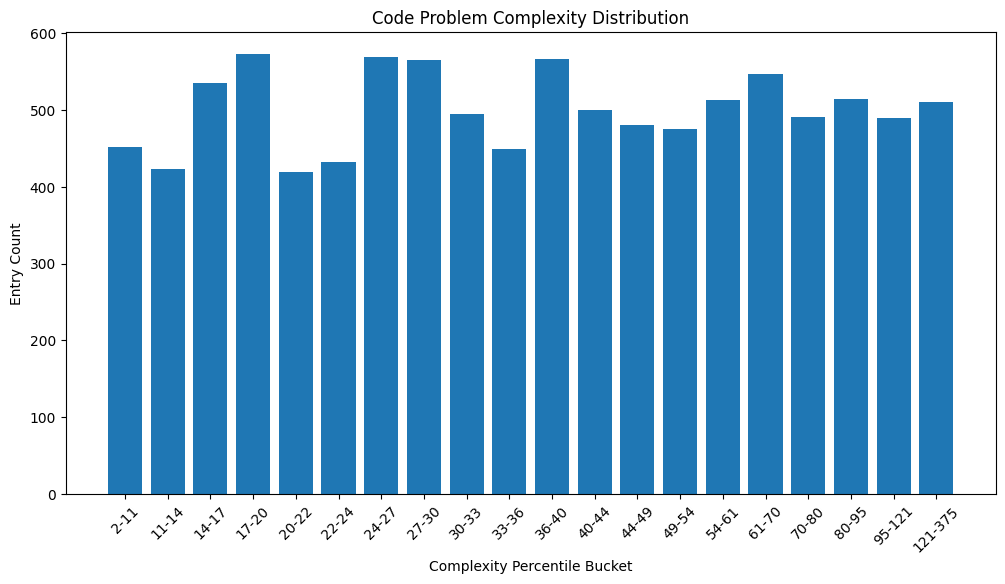

Evenness metrics for 500_5:
  coefficient_of_variation: 0.0956
  gini_coefficient: 0.0546
  shannon_entropy: 4.3153
  max_entropy: 4.3219
  normalized_entropy: 0.9985

20_5


Calculating complexities: 10000it [00:07, 1397.68it/s]


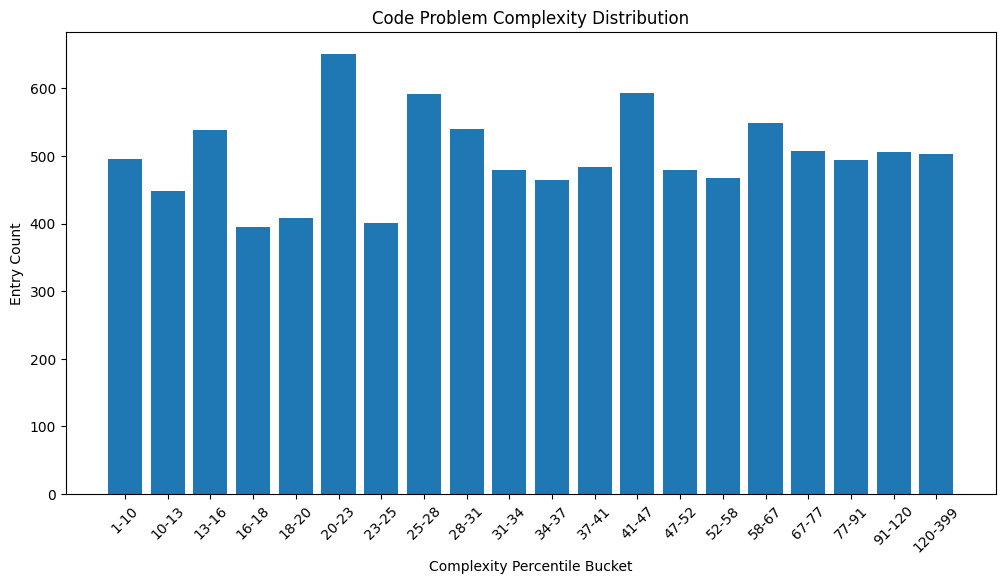

Evenness metrics for 20_5:
  coefficient_of_variation: 0.1270
  gini_coefficient: 0.0702
  shannon_entropy: 4.3104
  max_entropy: 4.3219
  normalized_entropy: 0.9973

KMeans Elbow


Calculating complexities: 10000it [00:07, 1300.29it/s]


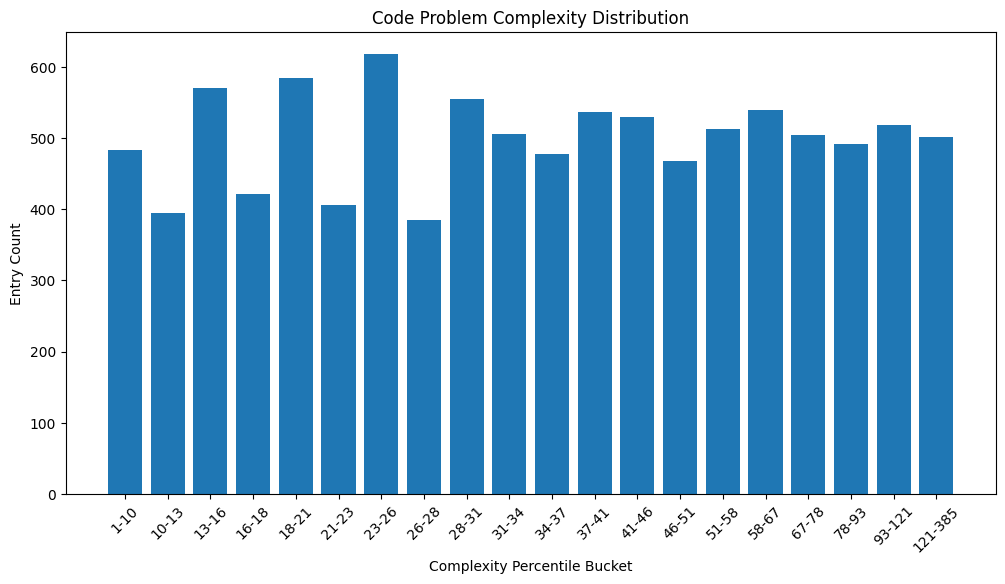

Evenness metrics for KMeans Elbow:
  coefficient_of_variation: 0.1219
  gini_coefficient: 0.0683
  shannon_entropy: 4.3110
  max_entropy: 4.3219
  normalized_entropy: 0.9975

Comparison (which is more even):
Based on normalized entropy: 500_5 is most evenly distributed
  Ranking: [('500_5', np.float64(0.998467879933743)), ('KMeans Elbow', np.float64(0.9974764260808474)), ('20_5', np.float64(0.9973339316271442))]
Based on coefficient of variation: 500_5 is most evenly distributed
  Ranking: [('500_5', np.float64(0.09558242516278817)), ('KMeans Elbow', np.float64(0.12194424955691842)), ('20_5', np.float64(0.1270370024835284))]
Based on Gini coefficient: 500_5 is most evenly distributed
  Ranking: [('500_5', np.float64(0.05455000000000006)), ('KMeans Elbow', np.float64(0.06828000000000004)), ('20_5', np.float64(0.07017000000000007))]

Overall ranking summary:
Average ranks across all metrics (lower is better):
  500_5: 1.00
  KMeans Elbow: 2.00
  20_5: 3.00

Best overall distribution: 500

In [89]:
def calculate_evenness_metrics(distribution):
    counts = list(distribution['counts'].values())
    total = sum(counts)
    
    # Normalize counts to probabilities
    probs = [c/total for c in counts]
    
    # Coefficient of variation (lower is more even)
    cv = np.std(counts) / np.mean(counts) if np.mean(counts) > 0 else float('inf')
    
    # Gini coefficient (lower is more even)
    sorted_counts = sorted(counts)
    cumsum = np.cumsum(sorted_counts)
    gini = (len(counts) + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / len(counts) if cumsum[-1] > 0 else 1
    
    # Shannon entropy (higher is more even)
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    
    # Theoretical maximum entropy for this number of buckets
    max_entropy = np.log2(len(counts))
    
    # Normalized entropy (closer to 1 is more even)
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    
    return {
        'coefficient_of_variation': cv,
        'gini_coefficient': gini,
        'shannon_entropy': entropy,
        'max_entropy': max_entropy,
        'normalized_entropy': normalized_entropy
    }

# Calculate metrics for all three distributions
print("500_5")
distribution1 = analyze_complexity_distribution('ast-pyedur_full_subset_500_5.jsonl')
plot_complexity_distribution(distribution1)
metrics1 = calculate_evenness_metrics(distribution1)
print("Evenness metrics for 500_5:")
for metric, value in metrics1.items():
    print(f"  {metric}: {value:.4f}")

print("\n20_5")
distribution2 = analyze_complexity_distribution('ast-pyedur_full_subset.jsonl')
plot_complexity_distribution(distribution2)
metrics2 = calculate_evenness_metrics(distribution2)
print("Evenness metrics for 20_5:")
for metric, value in metrics2.items():
    print(f"  {metric}: {value:.4f}")

print("\nKMeans Elbow")
distribution3 = analyze_complexity_distribution('ast-pyedur_full_subset_elbow.jsonl')
plot_complexity_distribution(distribution3)
metrics3 = calculate_evenness_metrics(distribution3)
print("Evenness metrics for KMeans Elbow:")
for metric, value in metrics3.items():
    print(f"  {metric}: {value:.4f}")

# Compare which distribution is more even (pairwise comparisons)
print("\nComparison (which is more even):")

# Normalized entropy (higher is better)
distributions = {
    "500_5": metrics1['normalized_entropy'],
    "20_5": metrics2['normalized_entropy'],
    "KMeans Elbow": metrics3['normalized_entropy']
}
best = max(distributions.items(), key=lambda x: x[1])[0]
print(f"Based on normalized entropy: {best} is most evenly distributed")
print(f"  Ranking: {sorted(distributions.items(), key=lambda x: x[1], reverse=True)}")

# Coefficient of variation (lower is better)
distributions = {
    "500_5": metrics1['coefficient_of_variation'],
    "20_5": metrics2['coefficient_of_variation'],
    "KMeans Elbow": metrics3['coefficient_of_variation']
}
best = min(distributions.items(), key=lambda x: x[1])[0]
print(f"Based on coefficient of variation: {best} is most evenly distributed")
print(f"  Ranking: {sorted(distributions.items(), key=lambda x: x[1])}")

# Gini coefficient (lower is better)
distributions = {
    "500_5": metrics1['gini_coefficient'],
    "20_5": metrics2['gini_coefficient'],
    "KMeans Elbow": metrics3['gini_coefficient']
}
best = min(distributions.items(), key=lambda x: x[1])[0]
print(f"Based on Gini coefficient: {best} is most evenly distributed")
print(f"  Ranking: {sorted(distributions.items(), key=lambda x: x[1])}")

# Overall summary
print("\nOverall ranking summary:")
metrics = ['normalized_entropy', 'coefficient_of_variation', 'gini_coefficient']
all_metrics = {
    "500_5": [metrics1[m] for m in metrics],
    "20_5": [metrics2[m] for m in metrics],
    "KMeans Elbow": [metrics3[m] for m in metrics]
}

# For each metric, assign ranks (1 = best, 3 = worst)
ranks = {}
for i, metric in enumerate(metrics):
    if i == 0:  # normalized_entropy (higher is better)
        sorted_dist = sorted([(name, all_metrics[name][i]) for name in all_metrics], 
                            key=lambda x: x[1], reverse=True)
    else:  # coefficient_of_variation and gini_coefficient (lower is better)
        sorted_dist = sorted([(name, all_metrics[name][i]) for name in all_metrics], 
                            key=lambda x: x[1])
    
    for rank, (name, _) in enumerate(sorted_dist):
        if name not in ranks:
            ranks[name] = []
        ranks[name].append(rank + 1)  # 1-based ranking

# Calculate average rank
avg_ranks = {name: sum(rank_list)/len(rank_list) for name, rank_list in ranks.items()}
best_overall = min(avg_ranks.items(), key=lambda x: x[1])[0]

print("Average ranks across all metrics (lower is better):")
for name, avg_rank in sorted(avg_ranks.items(), key=lambda x: x[1]):
    print(f"  {name}: {avg_rank:.2f}")
print(f"\nBest overall distribution: {best_overall}")

Overall, based on clustering metrics and looking at the distribution of asts in the final subset, the best is HDBSCAN with min cluster size 100 (min_sample = 5)

In [21]:
def calculate_evenness_metrics(distribution):
    """
    Calculate evenness metrics for the distribution.
    
    Parameters:
    distribution (dict): Contains 'counts' key with value counts
    
    Returns:
    dict: Dictionary of evenness metrics
    """
    # Extract counts from the distribution dict
    if isinstance(distribution, dict) and 'counts' in distribution:
        counts = list(distribution['counts'].values())
    else:
        counts = list(distribution.values())
    
    total = sum(counts)
    
    # Handle empty distribution
    if total == 0:
        return {
            'coefficient_of_variation': float('inf'),
            'gini_coefficient': 1.0,
            'shannon_entropy': 0.0,
            'max_entropy': 0.0,
            'normalized_entropy': 0.0
        }
    
    # Normalize counts to probabilities
    probs = [c/total for c in counts]
    
    # Coefficient of variation (lower is more even)
    cv = np.std(counts) / np.mean(counts) if np.mean(counts) > 0 else float('inf')
    
    # Gini coefficient (lower is more even)
    sorted_counts = sorted(counts)
    cumsum = np.cumsum(sorted_counts)
    gini = (len(counts) + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / len(counts) if cumsum[-1] > 0 else 1
    
    # Shannon entropy (higher is more even)
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    
    # Theoretical maximum entropy for this number of buckets
    max_entropy = np.log2(len(counts))
    
    # Normalized entropy (closer to 1 is more even)
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    
    return {
        'coefficient_of_variation': cv,
        'gini_coefficient': gini,
        'shannon_entropy': entropy,
        'max_entropy': max_entropy,
        'normalized_entropy': normalized_entropy
    }

def analyze_ast_complexity(jsonl_paths, num_buckets=20, use_fixed_bins=True):
    """
    Analyze code complexity based on AST features using fixed-width bins.
    
    Parameters:
    jsonl_paths (list): List of paths to jsonl files to analyze
    num_buckets (int): Number of complexity buckets to use
    use_fixed_bins (bool): Whether to use fixed-width bins instead of percentiles
    
    Returns:
    dict: Results for each dataset including complexity distributions and metrics
    """
    results = {}
    
    # Define AST patterns for measuring complexity
    ast_metrics = {
        'functions': r'FunctionDef\(',
        'loops': r'(For\()|(While\()',
        'conditionals': r'If\(',
        'calls': r'Call\(',
        'assignments': r'(Assign\()|(AugAssign\()'
    }
    
    # Process each dataset
    for path in jsonl_paths:
        dataset_name = path.split('/')[-1].split('.')[0]
        print(f"\nAnalyzing {dataset_name} with AST-based complexity...")
        
        # Calculate complexities from AST
        complexities = []
        try:
            with open(path) as f:
                for line in tqdm(f, desc=f"Calculating AST complexity for {dataset_name}"):
                    try:
                        entry = json.loads(line)
                        if 'ast' in entry:
                            # Sum counts of all AST patterns
                            complexity = sum(len(re.findall(pattern, entry['ast'])) 
                                            for pattern in ast_metrics.values())
                            complexities.append(complexity)
                    except (json.JSONDecodeError, KeyError) as e:
                        continue  # Skip invalid entries
        except FileNotFoundError:
            print(f"Error: File '{path}' not found")
            continue
            
        # Handle empty dataset case
        if not complexities:
            print(f"Error: No valid entries found in '{path}'")
            continue
        
        # Calculate statistics
        stats = {
            'mean': np.mean(complexities),
            'median': np.median(complexities),
            'std_dev': np.std(complexities),
            'min': min(complexities),
            'max': max(complexities),
            'total': len(complexities)
        }
        
        # Create bins for complexity values
        if use_fixed_bins:
            # Use fixed-width bins based on actual complexity values
            min_complexity = min(complexities)
            max_complexity = max(complexities)
            bin_width = max(1, (max_complexity - min_complexity) / num_buckets)
            bin_edges = np.arange(min_complexity, max_complexity + bin_width, bin_width)
        else:
            # Percentile-based bins (for comparison)
            bin_edges = np.unique(np.percentile(complexities, np.linspace(0, 100, num_buckets+1)))
        
        # Count entries in each bin
        hist, _ = np.histogram(complexities, bins=bin_edges)
        bucket_counts = {i: int(count) for i, count in enumerate(hist)}  # Ensure counts are integers
        
        # Calculate evenness metrics
        metrics = calculate_evenness_metrics(bucket_counts)  # Pass bucket_counts directly
        
        # Store results
        results[dataset_name] = {
            'bin_edges': bin_edges.tolist(),
            'counts': bucket_counts,
            'statistics': stats,
            'evenness_metrics': metrics
        }
        
        # Plot distribution
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(bucket_counts)), list(bucket_counts.values()), align='edge')
        plt.xlabel('AST Complexity (Fixed Bins)')
        plt.ylabel('Entry Count')
        plt.title(f'Code Problem AST Complexity Distribution - {dataset_name}')
        
        # Create bin labels
        bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" 
                     for i in range(len(bin_edges)-1)]
        
        # Show every nth label to avoid overcrowding
        n = max(1, len(bin_labels) // 10)
        plt.xticks(ticks=range(0, len(bin_labels), n),
                  labels=[bin_labels[i] for i in range(0, len(bin_labels), n)],
                  rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print(f"AST complexity statistics for {dataset_name}:")
        for stat, value in stats.items():
            if stat in ['mean', 'median', 'std_dev']:
                print(f"  {stat}: {value:.2f}")
            else:
                print(f"  {stat}: {value}")
                
        print(f"Evenness metrics for {dataset_name}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
    
    return results


Analyzing ast-pyedur_full_subset_500_5 with AST-based complexity...


Calculating AST complexity for ast-pyedur_full_subset_500_5: 10000it [00:06, 1643.25it/s]


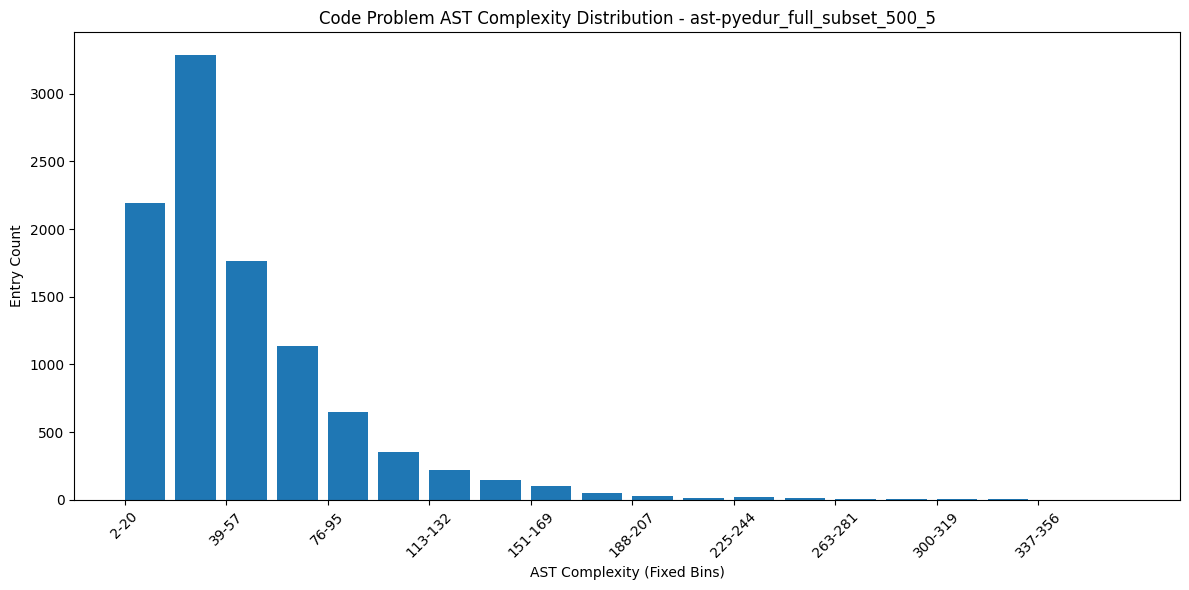

AST complexity statistics for ast-pyedur_full_subset_500_5:
  mean: 47.52
  median: 36.00
  std_dev: 38.21
  min: 2
  max: 375
  total: 10000
Evenness metrics for ast-pyedur_full_subset_500_5:
  coefficient_of_variation: 1.7690
  gini_coefficient: 0.7670
  shannon_entropy: 2.6416
  max_entropy: 4.3219
  normalized_entropy: 0.6112

Analyzing ast-pyedur_full_subset with AST-based complexity...


Calculating AST complexity for ast-pyedur_full_subset: 10000it [00:05, 1883.44it/s]


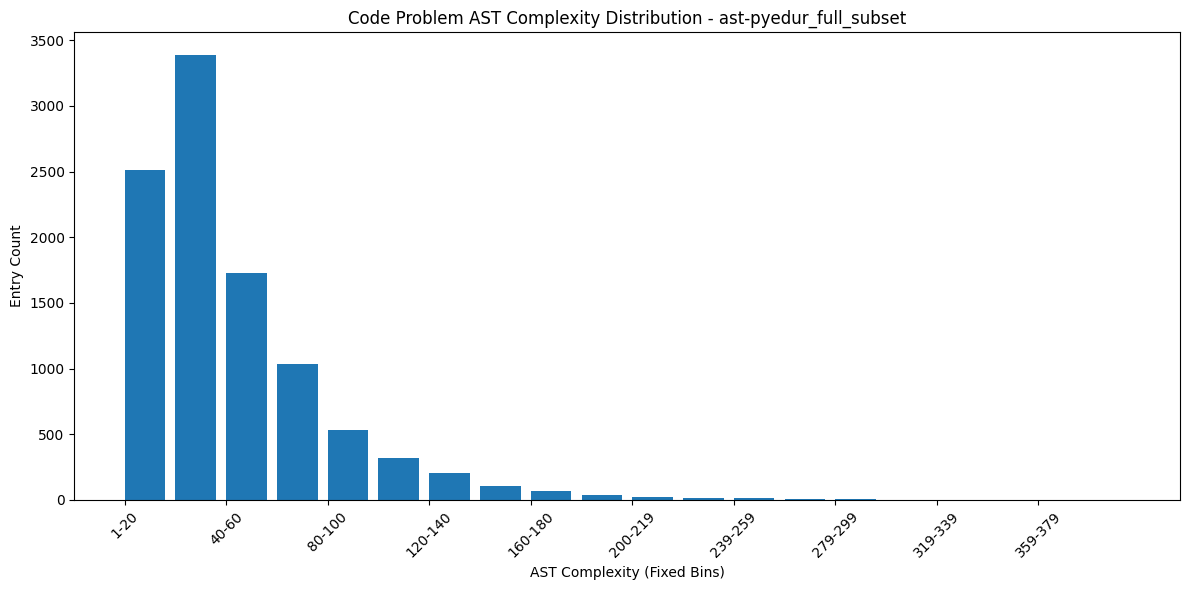

AST complexity statistics for ast-pyedur_full_subset:
  mean: 45.38
  median: 34.00
  std_dev: 37.78
  min: 1
  max: 399
  total: 10000
Evenness metrics for ast-pyedur_full_subset:
  coefficient_of_variation: 1.8598
  gini_coefficient: 0.7850
  shannon_entropy: 2.5234
  max_entropy: 4.3219
  normalized_entropy: 0.5839

Analyzing ast-pyedur_full_subset_elbow with AST-based complexity...


Calculating AST complexity for ast-pyedur_full_subset_elbow: 10000it [00:05, 1879.69it/s]


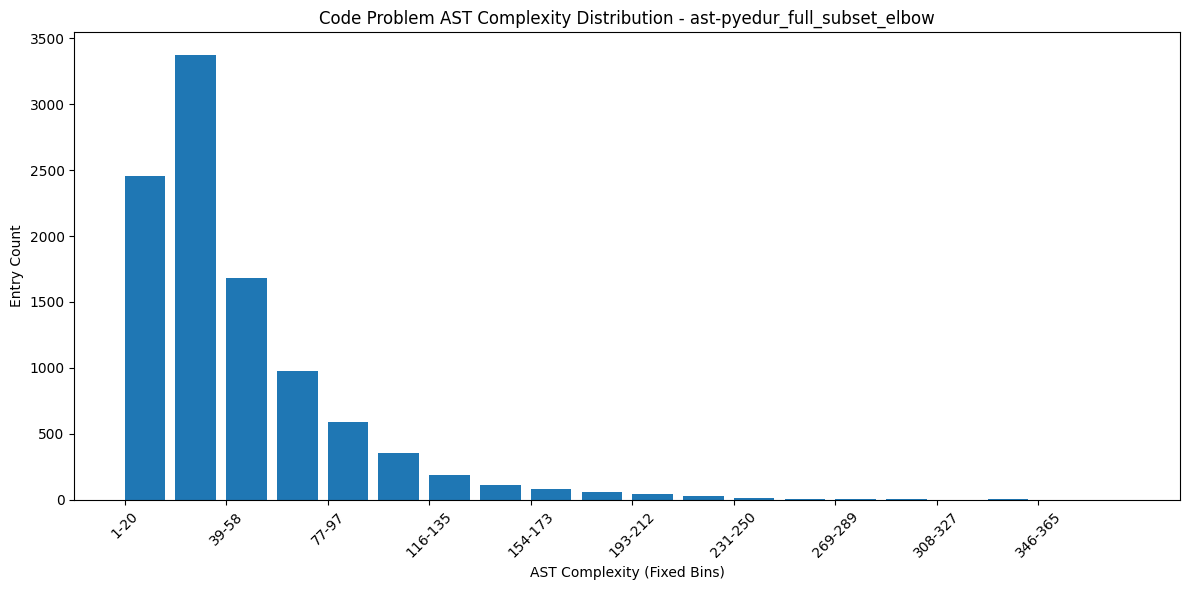

AST complexity statistics for ast-pyedur_full_subset_elbow:
  mean: 46.03
  median: 34.00
  std_dev: 39.27
  min: 1
  max: 385
  total: 10000
Evenness metrics for ast-pyedur_full_subset_elbow:
  coefficient_of_variation: 1.8297
  gini_coefficient: 0.7761
  shannon_entropy: 2.5866
  max_entropy: 4.3219
  normalized_entropy: 0.5985

Analyzing ast-pyedur_full_subset_elbow_2000 with AST-based complexity...


Calculating AST complexity for ast-pyedur_full_subset_elbow_2000: 2000it [00:01, 1896.20it/s]


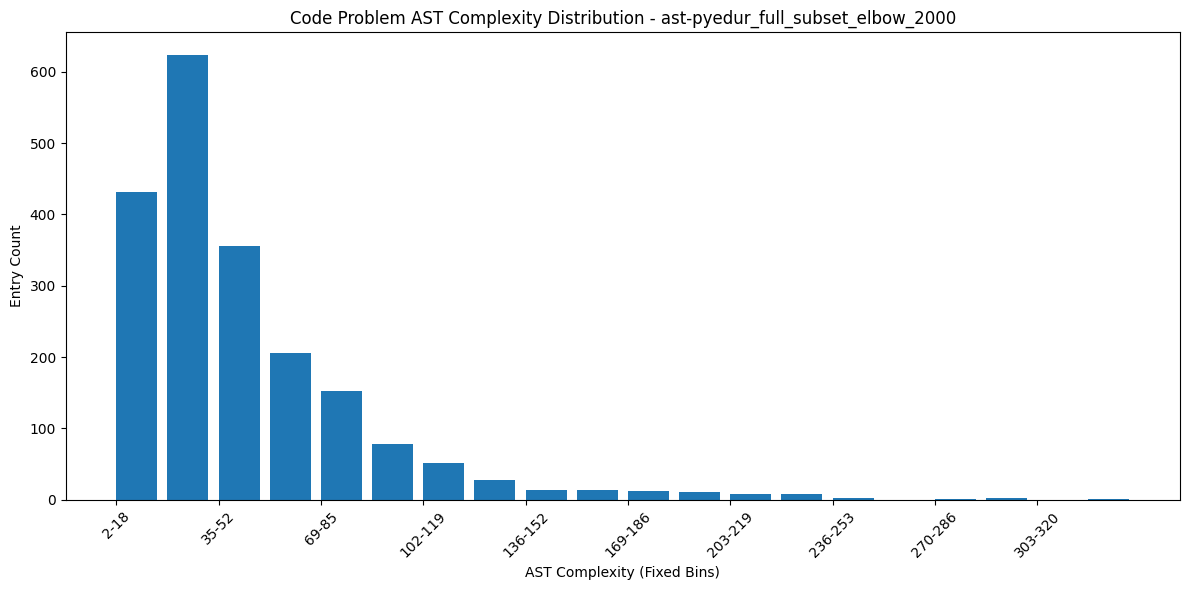

AST complexity statistics for ast-pyedur_full_subset_elbow_2000:
  mean: 46.03
  median: 34.00
  std_dev: 39.90
  min: 2
  max: 337
  total: 2000
Evenness metrics for ast-pyedur_full_subset_elbow_2000:
  coefficient_of_variation: 1.6990
  gini_coefficient: 0.7473
  shannon_entropy: 2.7555
  max_entropy: 4.3219
  normalized_entropy: 0.6376

Analyzing ast-pyedur_full_subset_100_5 with AST-based complexity...


Calculating AST complexity for ast-pyedur_full_subset_100_5: 10000it [00:05, 1914.84it/s]


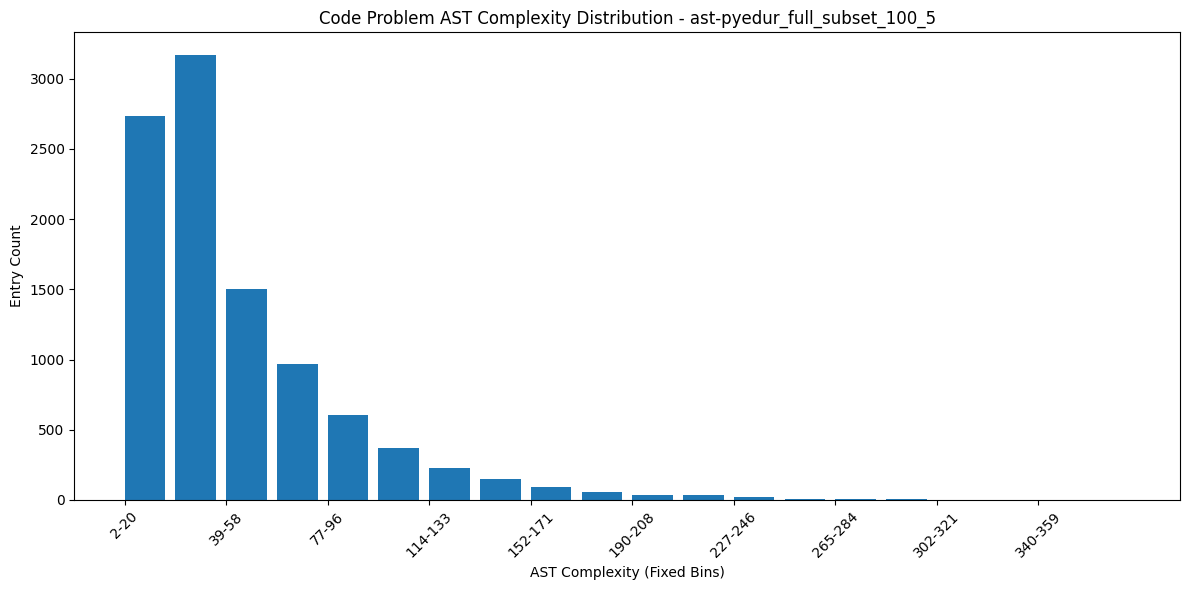

AST complexity statistics for ast-pyedur_full_subset_100_5:
  mean: 45.79
  median: 32.00
  std_dev: 40.03
  min: 2
  max: 378
  total: 10000
Evenness metrics for ast-pyedur_full_subset_100_5:
  coefficient_of_variation: 1.8072
  gini_coefficient: 0.7704
  shannon_entropy: 2.6197
  max_entropy: 4.3219
  normalized_entropy: 0.6061

Analyzing ast-pyedur_full_subset_100_5_2000 with AST-based complexity...


Calculating AST complexity for ast-pyedur_full_subset_100_5_2000: 2000it [00:01, 1908.13it/s]


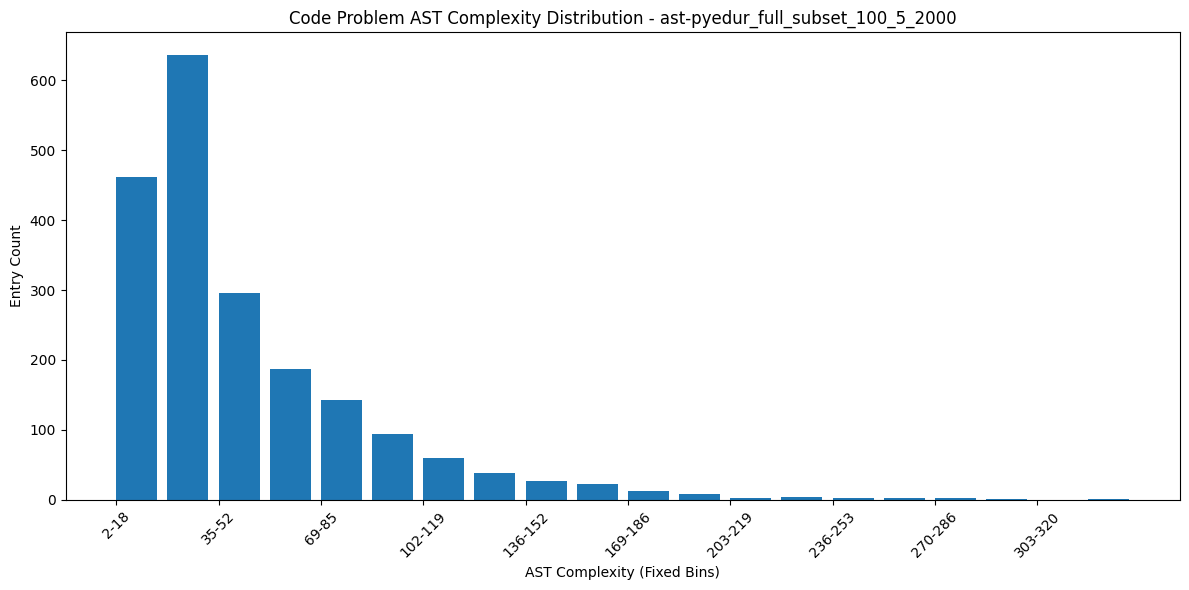

AST complexity statistics for ast-pyedur_full_subset_100_5_2000:
  mean: 46.00
  median: 32.00
  std_dev: 40.27
  min: 2
  max: 337
  total: 2000
Evenness metrics for ast-pyedur_full_subset_100_5_2000:
  coefficient_of_variation: 1.6994
  gini_coefficient: 0.7448
  shannon_entropy: 2.7819
  max_entropy: 4.3219
  normalized_entropy: 0.6437


In [28]:
# Import required libraries (if not already imported)
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define datasets to analyze
datasets = [
    'ast-pyedur_full_subset_500_5.jsonl',
    'ast-pyedur_full_subset.jsonl',
    'ast-pyedur_full_subset_elbow.jsonl',
    'ast-pyedur_full_subset_elbow_2000.jsonl',
    'ast-pyedur_full_subset_100_5.jsonl',
    'ast-pyedur_full_subset_100_5_2000.jsonl',
    # 'ast-pyedur_full.jsonl'
]

# Analyze all datasets using AST complexity with fixed bins
ast_results = analyze_ast_complexity(datasets, use_fixed_bins=True)

AST complexity statistics for ast-pyedur_full_subset_elbow_2000:
  mean: 46.03
  median: 34.00
  std_dev: 39.90
  min: 2
  max: 337
  total: 2000
Evenness metrics for ast-pyedur_full_subset_elbow_2000:
  coefficient_of_variation: 1.6990
  gini_coefficient: 0.7473
  shannon_entropy: 2.7555
  max_entropy: 4.3219
  normalized_entropy: 0.6376

AST complexity statistics for ast-pyedur_full_subset_elbow:
  mean: 46.03
  median: 34.00
  std_dev: 39.27
  min: 1
  max: 385
  total: 10000
Evenness metrics for ast-pyedur_full_subset_elbow:
  coefficient_of_variation: 1.8297
  gini_coefficient: 0.7761
  shannon_entropy: 2.5866
  max_entropy: 4.3219
  normalized_entropy: 0.5985



### Complexity based on lines of code

In [30]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import entropy

def analyze_complexity_by_loc(jsonl_paths, num_buckets=20, use_percentiles=False):
    """
    Analyze code complexity by lines of code for multiple datasets.
    
    Parameters:
    jsonl_paths (list): List of paths to jsonl files to analyze
    num_buckets (int): Number of complexity buckets to use
    use_percentiles (bool): If True, use percentiles for bucketing; otherwise, use fixed-width bins
    
    Returns:
    dict: Results for each dataset including complexity distributions and metrics
    """
    results = {}
    
    # Process each dataset
    for path in jsonl_paths:
        dataset_name = path.split('/')[-1].split('.')[0]
        print(f"\nAnalyzing {dataset_name}...")
        
        # Calculate complexities by counting lines of code
        complexities = []
        try:
            with open(path) as f:
                for line in tqdm(f, desc=f"Calculating LOC for {dataset_name}"):
                    try:
                        entry = json.loads(line)
                        # Split code into lines and count non-empty lines
                        code_lines = [l.strip() for l in entry['code'].split('\n') if l.strip()]
                        complexities.append(len(code_lines))
                    except (json.JSONDecodeError, KeyError) as e:
                        continue  # Skip invalid entries
        except FileNotFoundError:
            print(f"Error: File '{path}' not found")
            continue
            
        # Handle empty dataset case
        if not complexities:
            print(f"Error: No valid entries found in '{path}'")
            continue
        
        # Calculate statistics
        stats = {
            'mean': np.mean(complexities),
            'median': np.median(complexities),
            'std_dev': np.std(complexities),
            'min': min(complexities),
            'max': max(complexities),
            'total': len(complexities)
        }
        
        # Create complexity buckets - either percentile-based or fixed-width
        if use_percentiles:
            # Original percentile-based approach
            percentiles = np.unique(np.percentile(complexities, np.linspace(0, 100, num_buckets+1)))
        else:
            # Fixed-width bins based on min/max values
            min_complexity = min(complexities)
            max_complexity = max(complexities)
            bin_width = (max_complexity - min_complexity) / num_buckets
            percentiles = np.array([min_complexity + i * bin_width for i in range(num_buckets+1)])
        
        actual_buckets = len(percentiles) - 1
        bucket_counts = {i: 0 for i in range(actual_buckets)}
        
        # Assign entries to buckets
        for c in complexities:
            bucket = np.searchsorted(percentiles, c, side='right') - 1
            bucket = min(max(bucket, 0), actual_buckets-1)
            bucket_counts[bucket] += 1
            
        # Calculate evenness metrics
        metrics = calculate_evenness_metrics(bucket_counts)
        
        # Store results
        results[dataset_name] = {
            'percentiles': percentiles.tolist(),
            'counts': bucket_counts,
            'statistics': stats,
            'evenness_metrics': metrics
        }
        
        # Plot distribution
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(bucket_counts)), list(bucket_counts.values()))
        plt.xlabel('Code Complexity (Lines of Code) - Percentile Buckets')
        plt.ylabel('Entry Count')
        plt.title(f'Code Problem Complexity Distribution - {dataset_name}')
        
        if len(percentiles) > 1:
            plt.xticks(ticks=range(len(percentiles)-1),
                      labels=[f"{int(percentiles[i])}-{int(percentiles[i+1])}"
                              for i in range(len(percentiles)-1)],
                      rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print(f"Complexity statistics for {dataset_name}:")
        for stat, value in stats.items():
            if stat in ['mean', 'median', 'std_dev']:
                print(f"  {stat}: {value:.2f}")
            else:
                print(f"  {stat}: {value}")
                
        print(f"Evenness metrics for {dataset_name}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
    
    return results

def calculate_evenness_metrics(bucket_counts):
    """
    Calculate evenness metrics for the distribution.
    
    Parameters:
    bucket_counts (dict): Counts of entries in each bucket
    
    Returns:
    dict: Dictionary of evenness metrics
    """
    counts = np.array(list(bucket_counts.values()))
    total = sum(counts)
    
    # Skip empty distributions
    if total == 0:
        return {'shannon_evenness': 0, 'pielou_evenness': 0, 'simpson_evenness': 0}
    
    # Calculate proportions
    proportions = counts / total
    
    # Remove zero values to avoid log(0) issues
    proportions = proportions[proportions > 0]
    
    # Shannon entropy
    shannon = -np.sum(proportions * np.log(proportions))
    
    # Pielou's evenness (normalized Shannon entropy)
    max_shannon = np.log(len(bucket_counts))
    pielou = shannon / max_shannon if max_shannon > 0 else 0
    
    # Simpson's evenness
    simpson = 1 / np.sum(proportions**2)
    simpson_normalized = (simpson - 1) / (len(bucket_counts) - 1) if len(bucket_counts) > 1 else 0
    
    return {
        'shannon_evenness': shannon,
        'pielou_evenness': pielou,
        'simpson_evenness': simpson_normalized
    }


Analyzing ast-pyedur_full_subset_500_5...


Calculating LOC for ast-pyedur_full_subset_500_5: 10000it [00:01, 9845.93it/s]


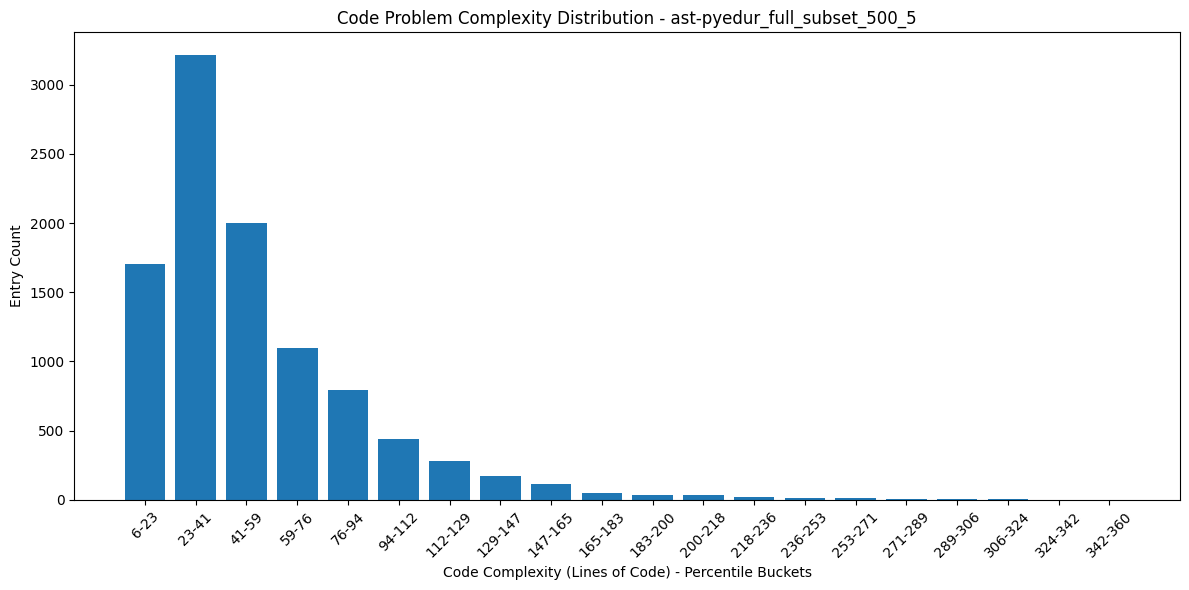

Complexity statistics for ast-pyedur_full_subset_500_5:
  mean: 53.18
  median: 42.00
  std_dev: 37.54
  min: 6
  max: 360
  total: 10000
Evenness metrics for ast-pyedur_full_subset_500_5:
  shannon_evenness: 1.8955
  pielou_evenness: 0.6327
  simpson_evenness: 0.2185

Analyzing ast-pyedur_full_subset...


Calculating LOC for ast-pyedur_full_subset: 10000it [00:00, 10302.66it/s]


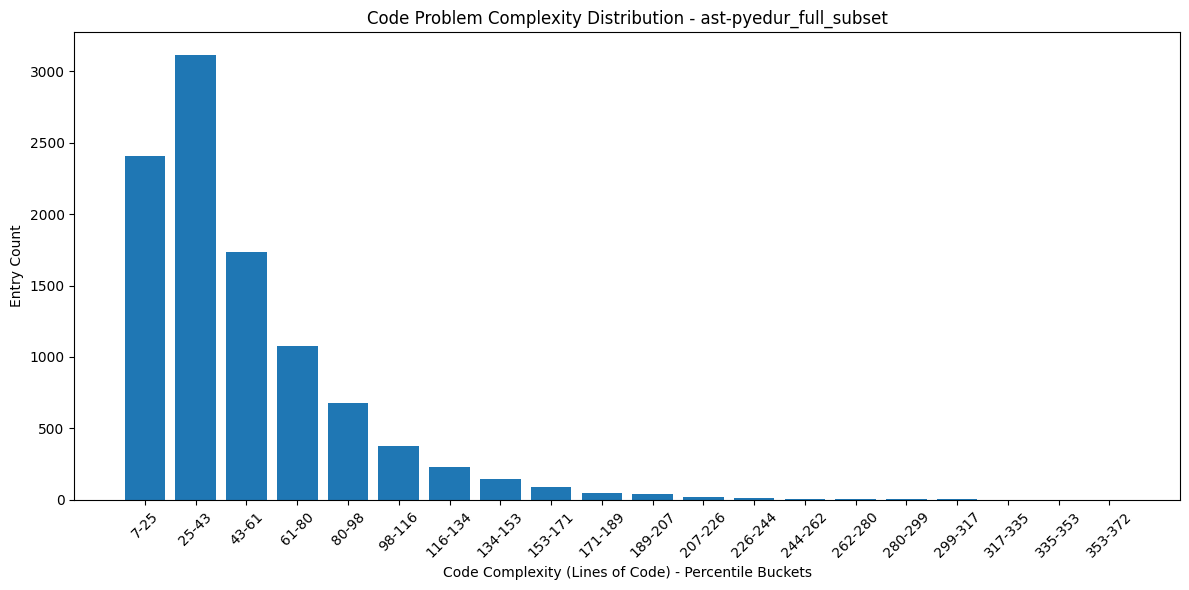

Complexity statistics for ast-pyedur_full_subset:
  mean: 50.98
  median: 39.00
  std_dev: 37.12
  min: 7
  max: 372
  total: 10000
Evenness metrics for ast-pyedur_full_subset:
  shannon_evenness: 1.8332
  pielou_evenness: 0.6119
  simpson_evenness: 0.2056

Analyzing ast-pyedur_full_subset_elbow...


Calculating LOC for ast-pyedur_full_subset_elbow: 10000it [00:00, 11169.68it/s]


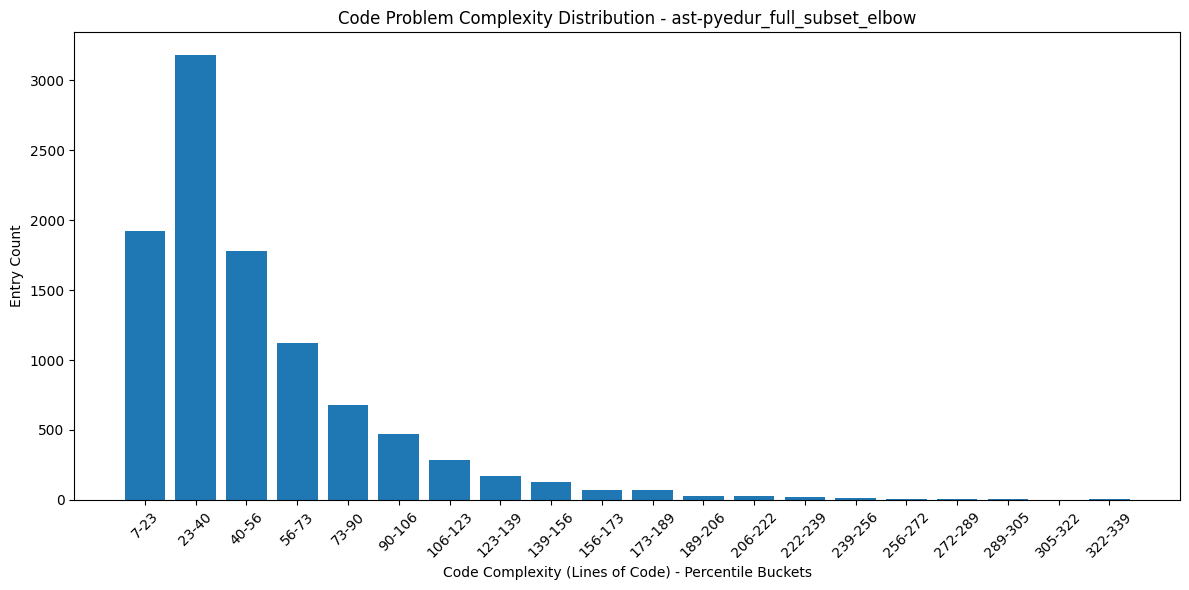

Complexity statistics for ast-pyedur_full_subset_elbow:
  mean: 51.85
  median: 40.00
  std_dev: 38.73
  min: 7
  max: 339
  total: 10000
Evenness metrics for ast-pyedur_full_subset_elbow:
  shannon_evenness: 1.9313
  pielou_evenness: 0.6447
  simpson_evenness: 0.2231

Analyzing ast-pyedur_full_subset_elbow_2000...


Calculating LOC for ast-pyedur_full_subset_elbow_2000: 2000it [00:00, 11126.17it/s]


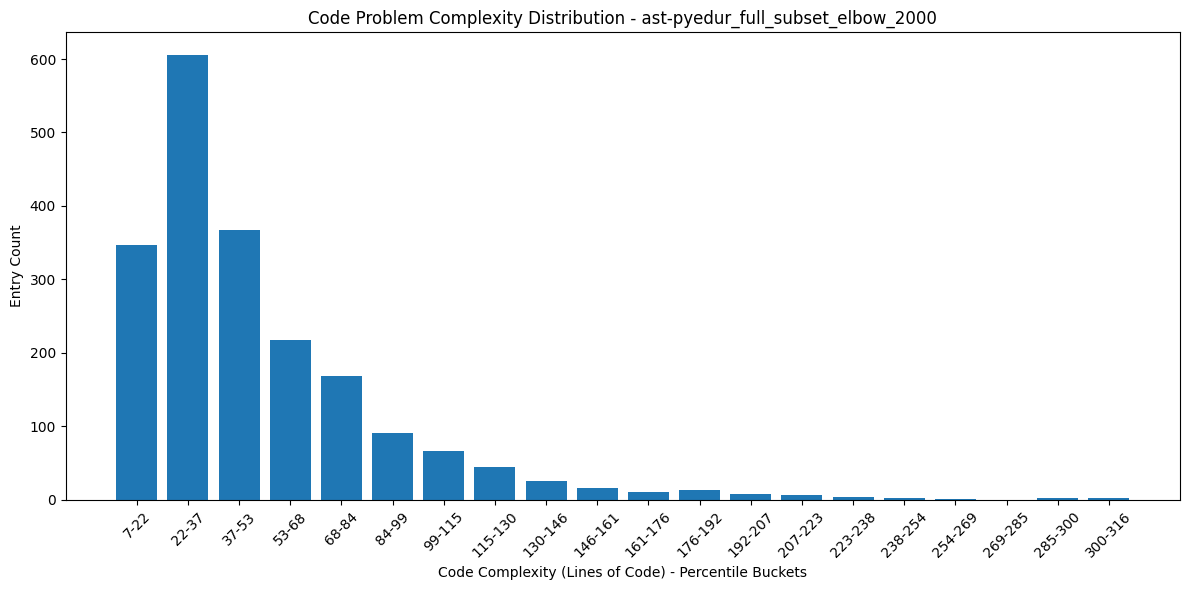

Complexity statistics for ast-pyedur_full_subset_elbow_2000:
  mean: 51.62
  median: 39.00
  std_dev: 39.29
  min: 7
  max: 316
  total: 2000
Evenness metrics for ast-pyedur_full_subset_elbow_2000:
  shannon_evenness: 2.0017
  pielou_evenness: 0.6682
  simpson_evenness: 0.2422

Analyzing ast-pyedur_full_subset_100_5...


Calculating LOC for ast-pyedur_full_subset_100_5: 10000it [00:00, 11002.42it/s]


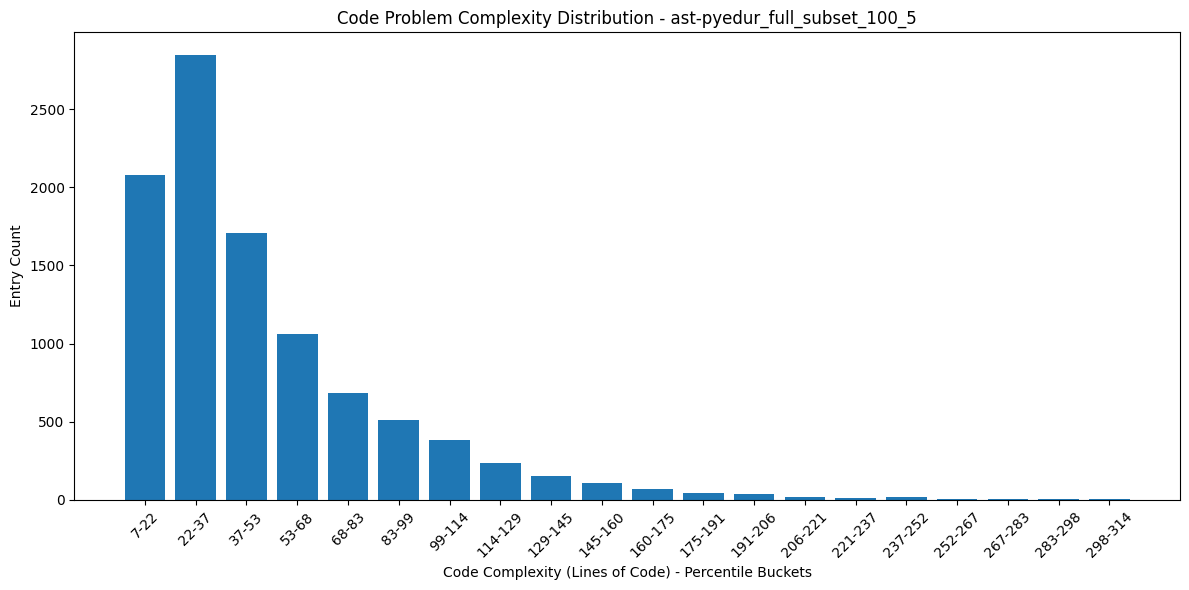

Complexity statistics for ast-pyedur_full_subset_100_5:
  mean: 50.94
  median: 38.00
  std_dev: 39.25
  min: 7
  max: 314
  total: 10000
Evenness metrics for ast-pyedur_full_subset_100_5:
  shannon_evenness: 2.0154
  pielou_evenness: 0.6727
  simpson_evenness: 0.2487

Analyzing ast-pyedur_full_subset_100_5_2000...


Calculating LOC for ast-pyedur_full_subset_100_5_2000: 2000it [00:00, 11412.02it/s]


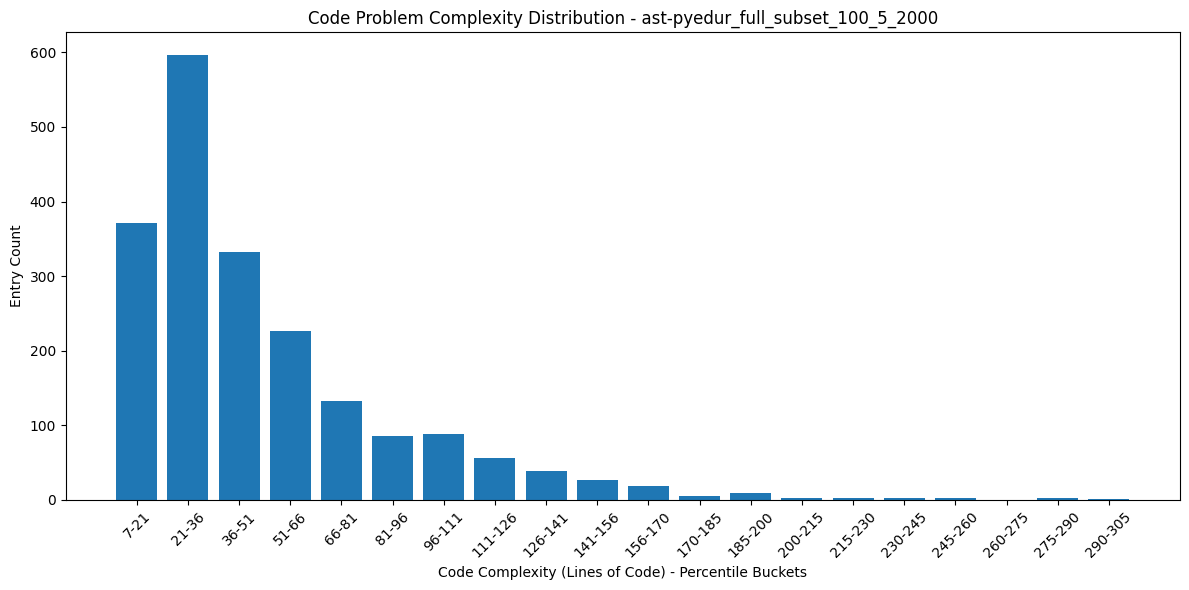

Complexity statistics for ast-pyedur_full_subset_100_5_2000:
  mean: 50.93
  median: 38.00
  std_dev: 39.19
  min: 7
  max: 305
  total: 2000
Evenness metrics for ast-pyedur_full_subset_100_5_2000:
  shannon_evenness: 2.0323
  pielou_evenness: 0.6784
  simpson_evenness: 0.2506


In [31]:
# Import required libraries (if not already imported)
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import entropy

# Define datasets to analyze
datasets = [
    'ast-pyedur_full_subset_500_5.jsonl',
    'ast-pyedur_full_subset.jsonl',
    'ast-pyedur_full_subset_elbow.jsonl',
    'ast-pyedur_full_subset_elbow_2000.jsonl',
    'ast-pyedur_full_subset_100_5.jsonl',
    'ast-pyedur_full_subset_100_5_2000.jsonl',
    # 'ast-pyedur_full.jsonl'
]

# Analyze all datasets
results = analyze_complexity_by_loc(datasets)

Complexity statistics for ast-pyedur_full_subset_elbow:
  mean: 51.85
  median: 40.00
  std_dev: 38.73
  min: 7
  max: 339
  total: 10000
Evenness metrics for ast-pyedur_full_subset_elbow:
  shannon_evenness: 1.9313
  pielou_evenness: 0.6447
  simpson_evenness: 0.2231

Analyzing ast-pyedur_full...
Calculating LOC for ast-pyedur_full: 1630607it [02:26, 11164.64it/s]
  
Complexity statistics for ast-pyedur_full_subset_elbow_2000:
  mean: 51.62
  median: 39.00
  std_dev: 39.29
  min: 7
  max: 316
  total: 2000
Evenness metrics for ast-pyedur_full_subset_elbow_2000:
  coefficient_of_variation: 1.6032
  gini_coefficient: 0.7239
  shannon_entropy: 2.8879
  max_entropy: 4.3219
  normalized_entropy: 0.6682


Analyzing ast-pyedur_full_subset_elbow_2000...


Calculating LOC for ast-pyedur_full_subset_elbow_2000: 2000it [00:00, 11422.18it/s]


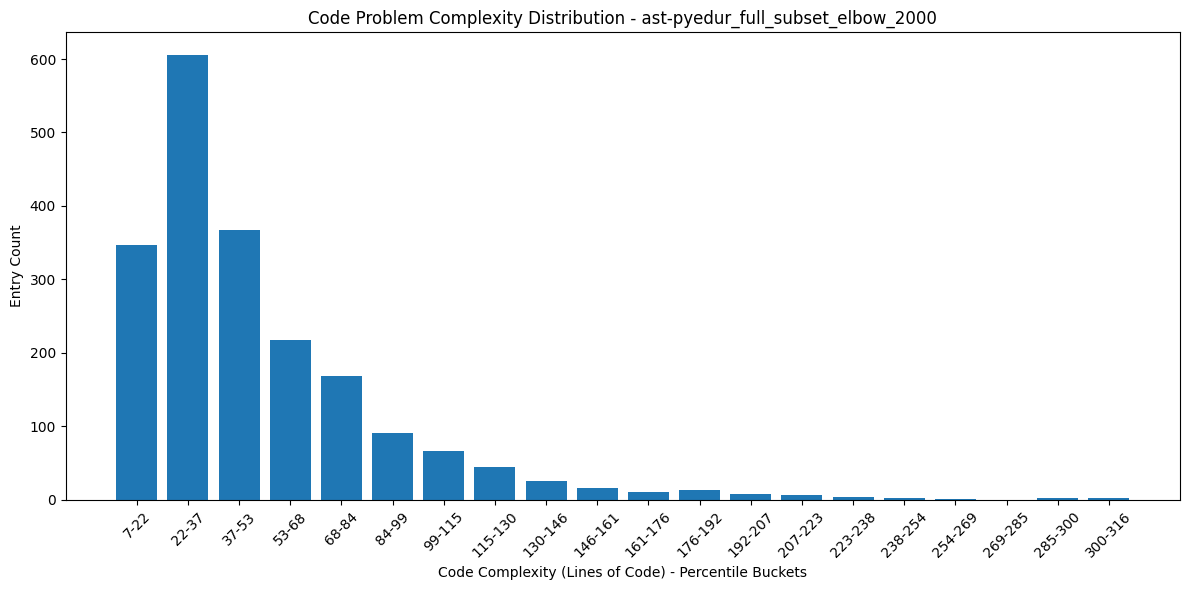

Complexity statistics for ast-pyedur_full_subset_elbow_2000:
  mean: 51.62
  median: 39.00
  std_dev: 39.29
  min: 7
  max: 316
  total: 2000
Evenness metrics for ast-pyedur_full_subset_elbow_2000:
  coefficient_of_variation: 1.6032
  gini_coefficient: 0.7239
  shannon_entropy: 2.8879
  max_entropy: 4.3219
  normalized_entropy: 0.6682


In [31]:
# Import required libraries (if not already imported)
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import entropy

# Define datasets to analyze
datasets = [
    # 'ast-pyedur_full_subset_500_5.jsonl',
    # 'ast-pyedur_full_subset.jsonl',
    'ast-pyedur_full_subset_elbow_2000.jsonl',
    # 'ast-pyedur_full.jsonl'
]

# Analyze all datasets
results = analyze_complexity_by_loc(datasets)

## Go away for now

In [20]:
np.save('hdbscan_labels_2.npy', labels)

# # Save the probabilities to a file
np.save('hdbscan_probabilities_2.npy', probabilities)

In [5]:

# # Save the cluster labels to a file
# np.save('hdbscan_labels.npy', labels)

# # Save the probabilities to a file
# np.save('hdbscan_probabilities.npy', probabilities)

# To load them later:
loaded_labels = np.load('hdbscan_labels.npy')
loaded_probabilities = np.load('hdbscan_probabilities.npy')

In [ ]:
np.save('hdbscan_labels_reduced10_normalized.npy', labels_reduced10_normalized)

# # Save the probabilities to a file
np.save('hdbscan_probabilities_reduced10_normalized.npy', probabilities_reduced10_normalized)

Number of points: 1630607
Number of clusters: 137263
Number of noise points: 5905 (0.36%)
Total clusters: 6000
Non-empty clusters: 137264
Largest cluster: 5905 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


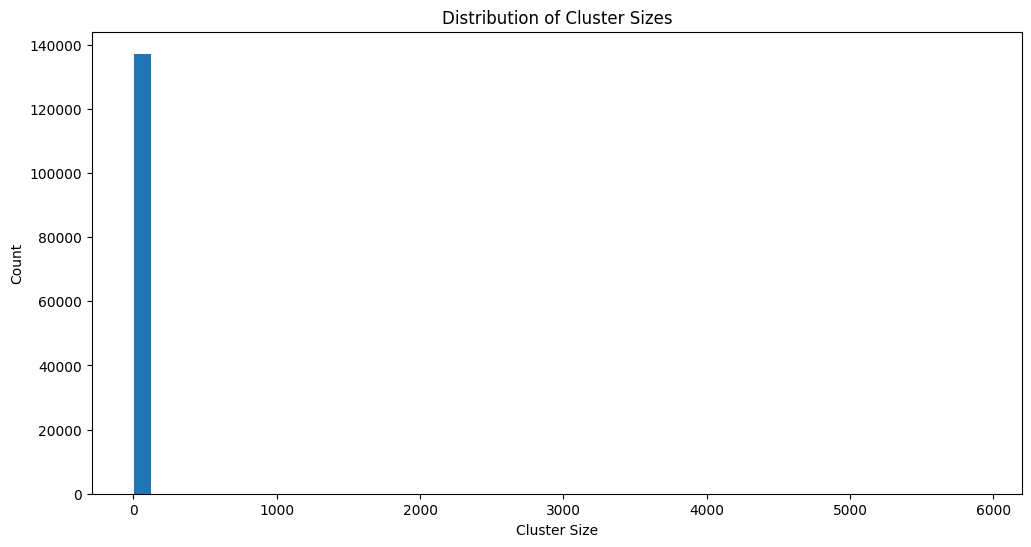

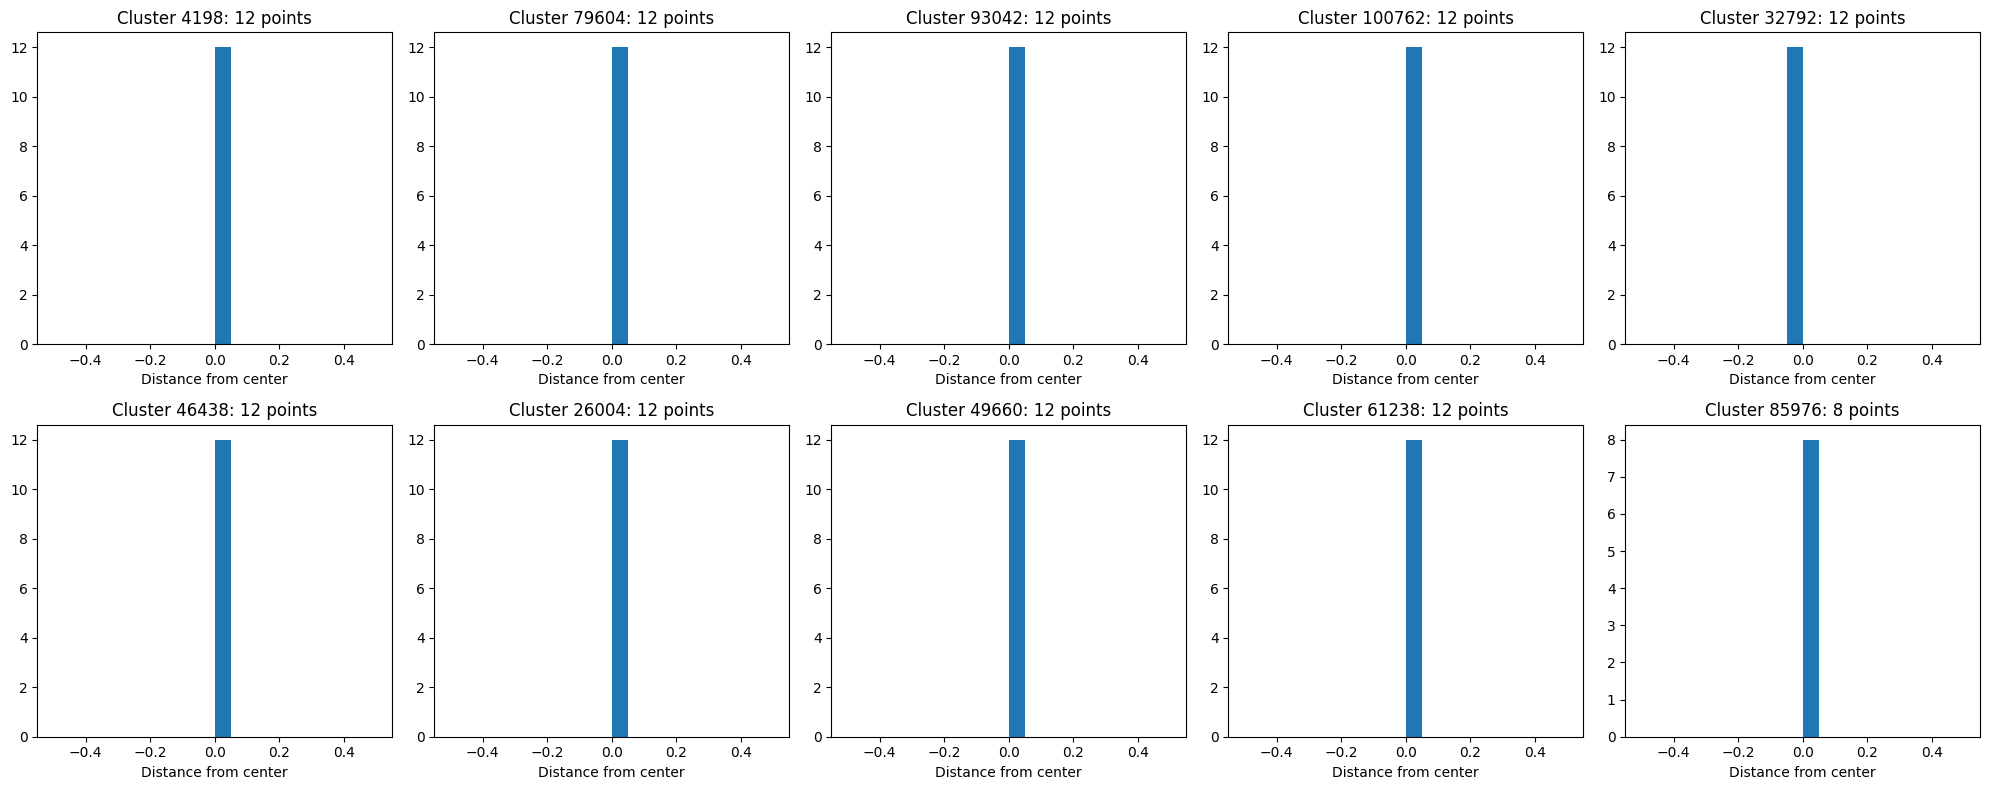

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0664
Calinski-Harabasz Score: 105.31


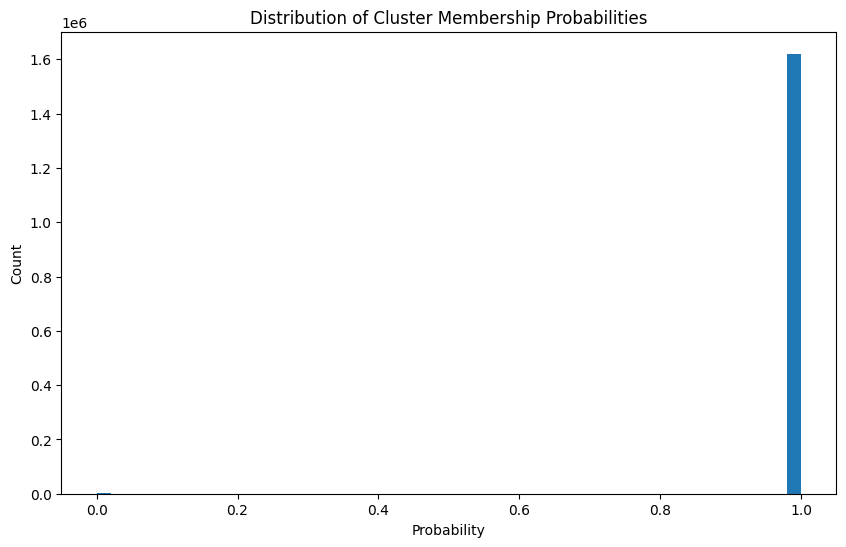

In [23]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(labels)}")
print(f"Number of clusters: {len(np.unique(labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(labels == -1)} ({np.sum(labels == -1)/len(labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(probabilities[labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

In [ ]:
np.save('hdbscan_labels_reduced10_normalized.npy', labels_reduced10_normalized)

# # Save the probabilities to a file
np.save('hdbscan_probabilities_reduced10_normalized.npy', probabilities_reduced10_normalized)

In [ ]:
np.save('hdbscan_labels_reduced10_normalized.npy', labels_reduced10_normalized)

# # Save the probabilities to a file
np.save('hdbscan_probabilities_reduced10_normalized.npy', probabilities_reduced10_normalized)

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


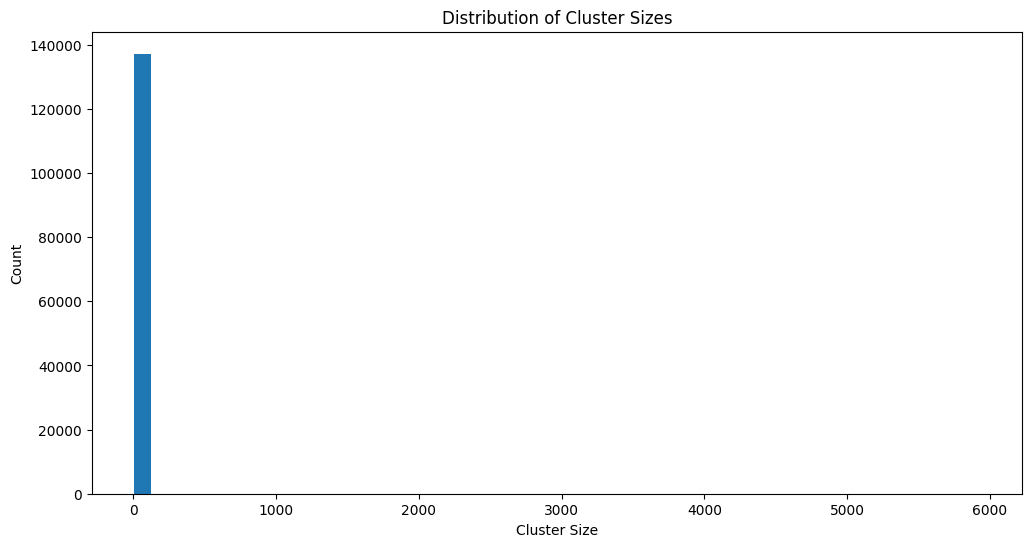

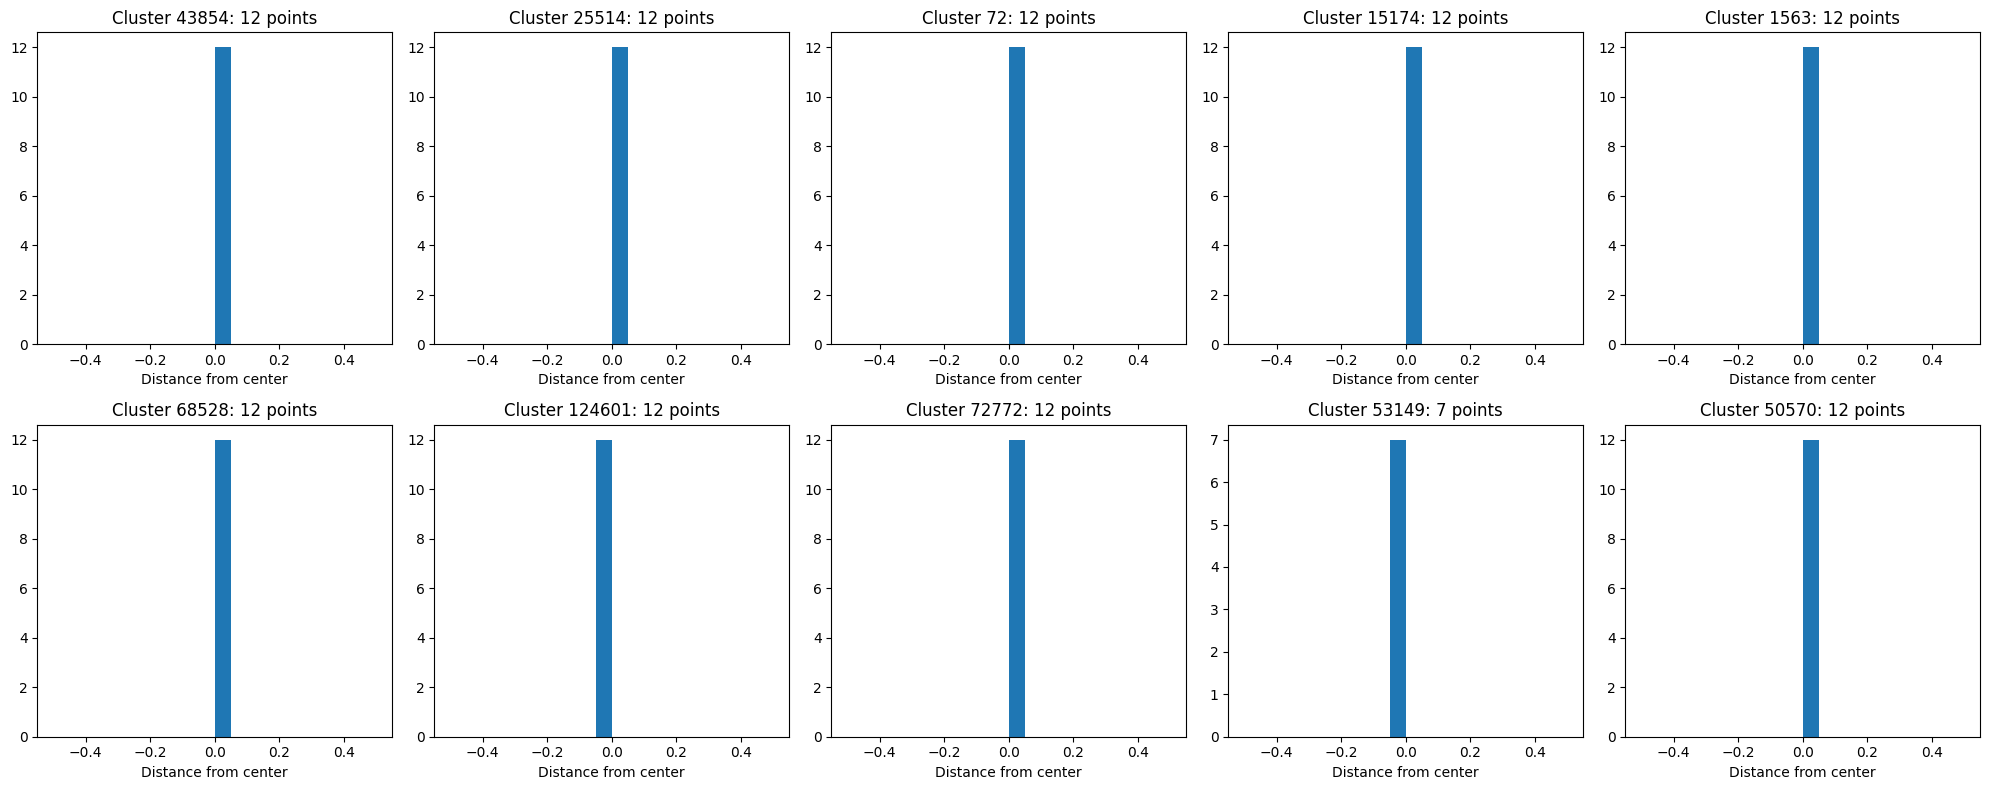

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


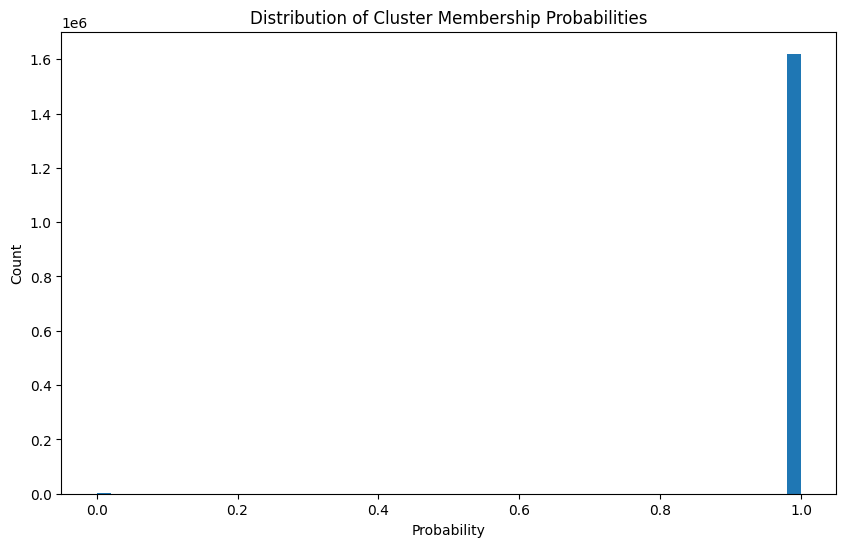

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


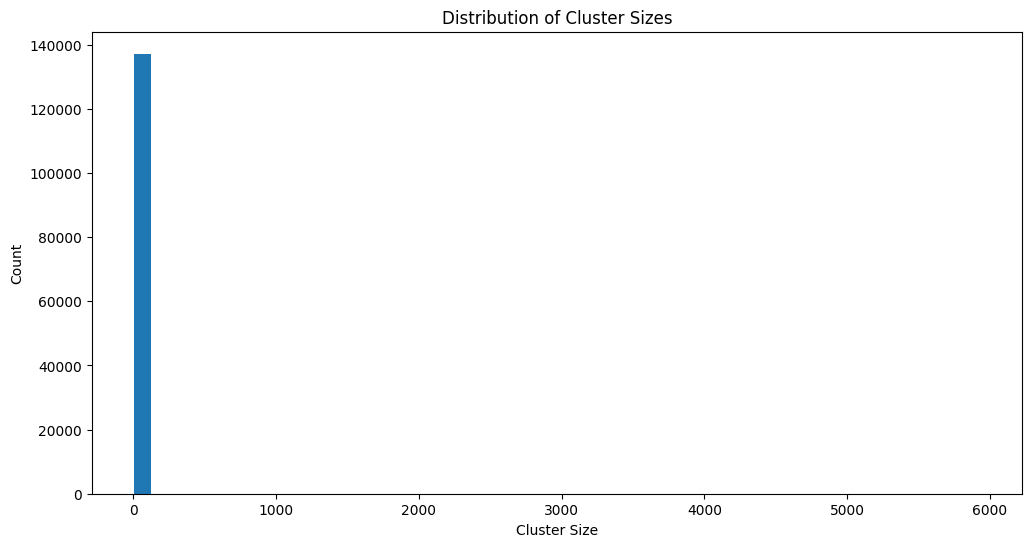

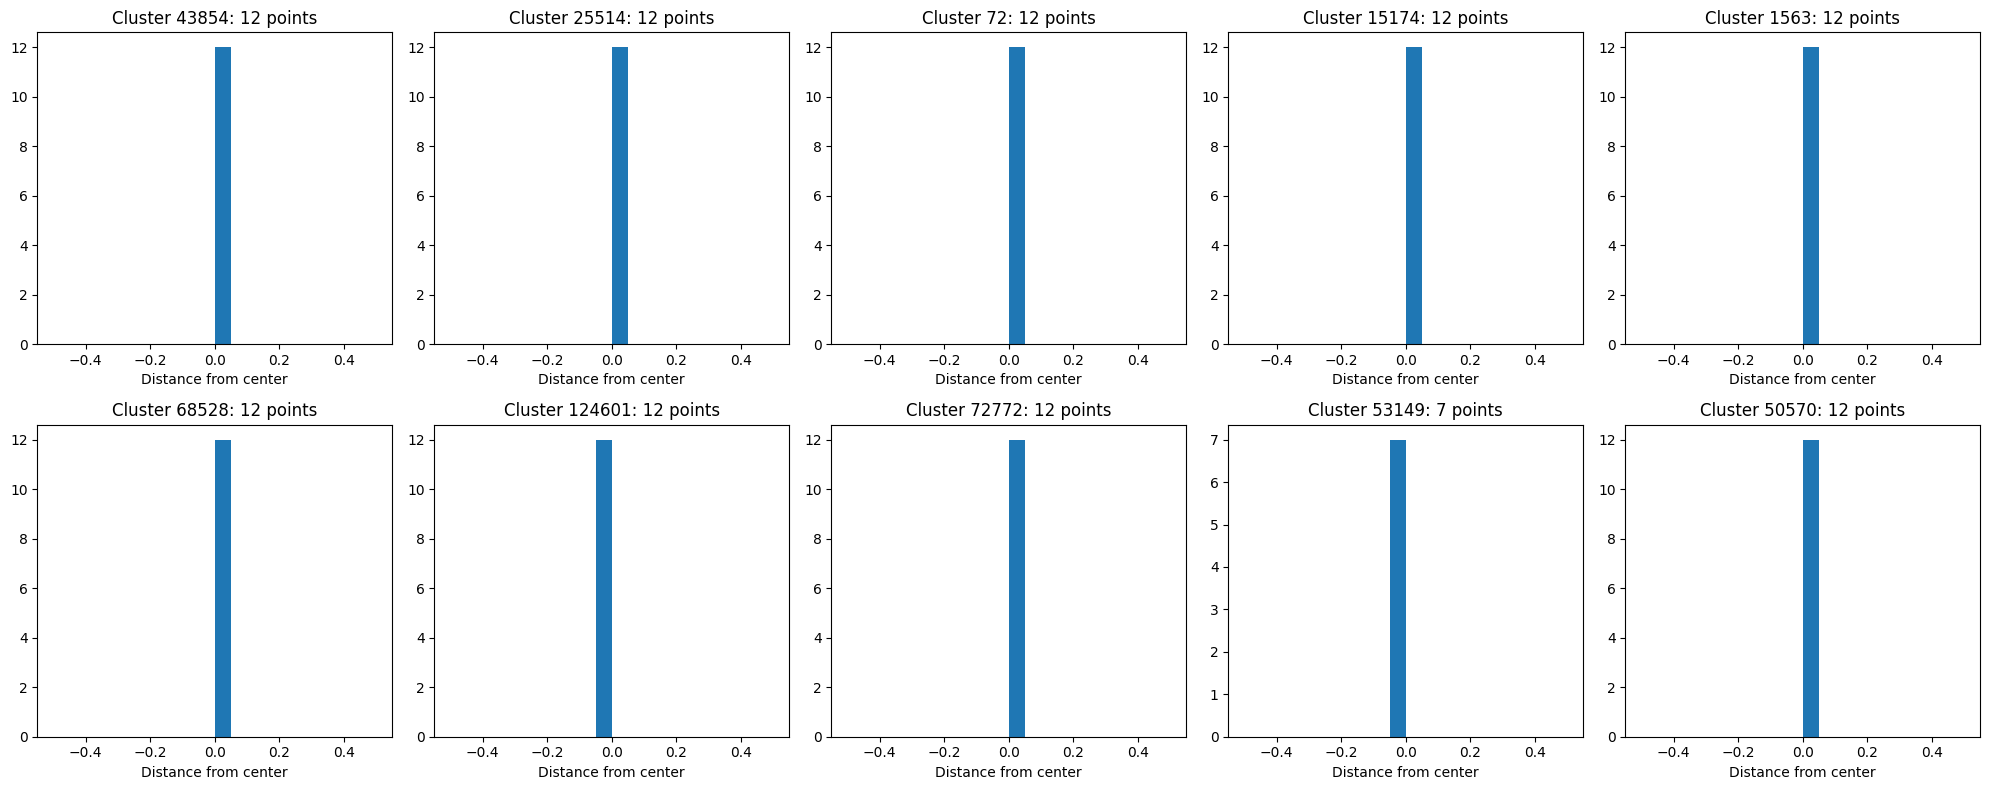

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


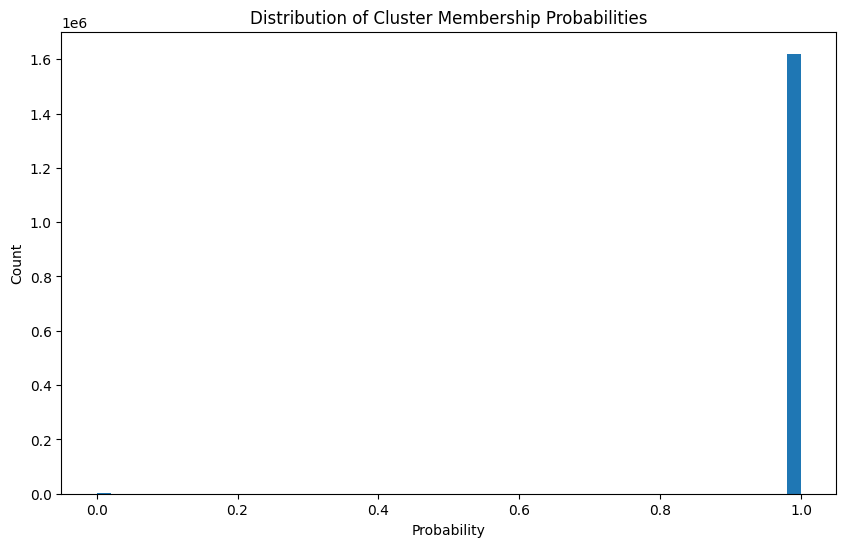

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


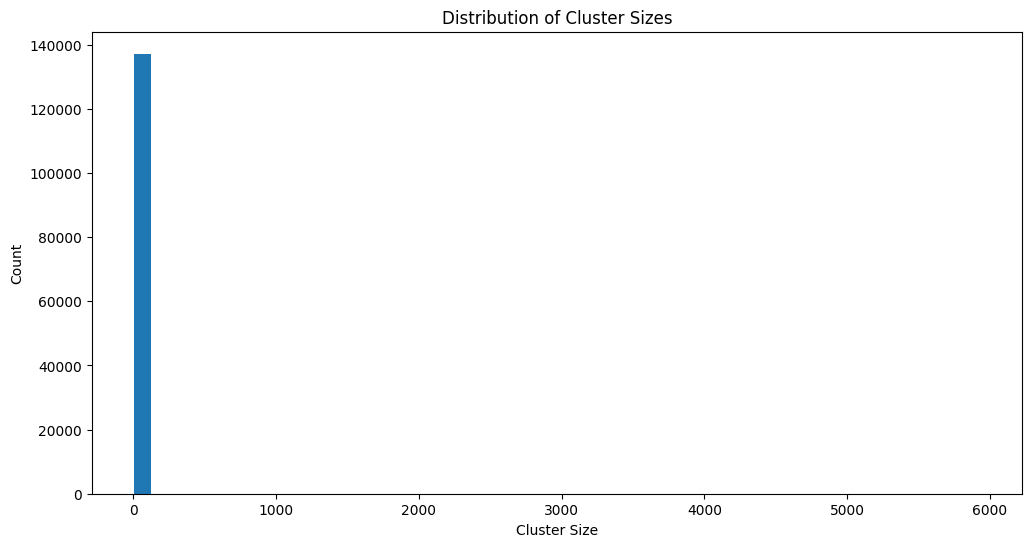

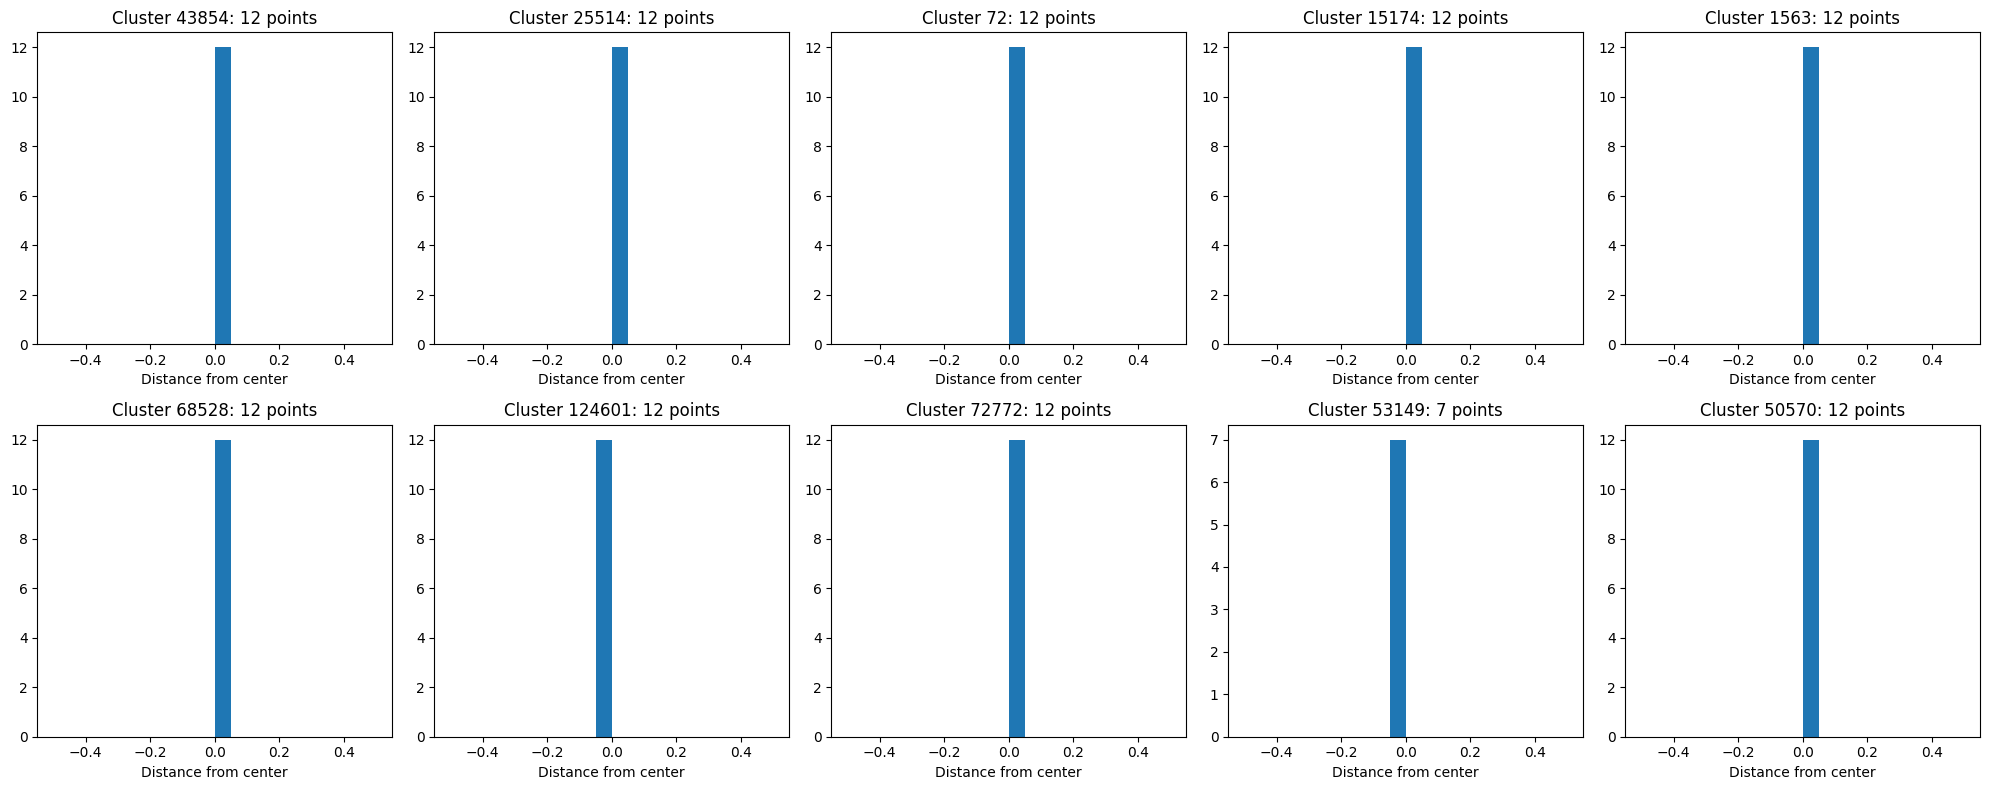

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


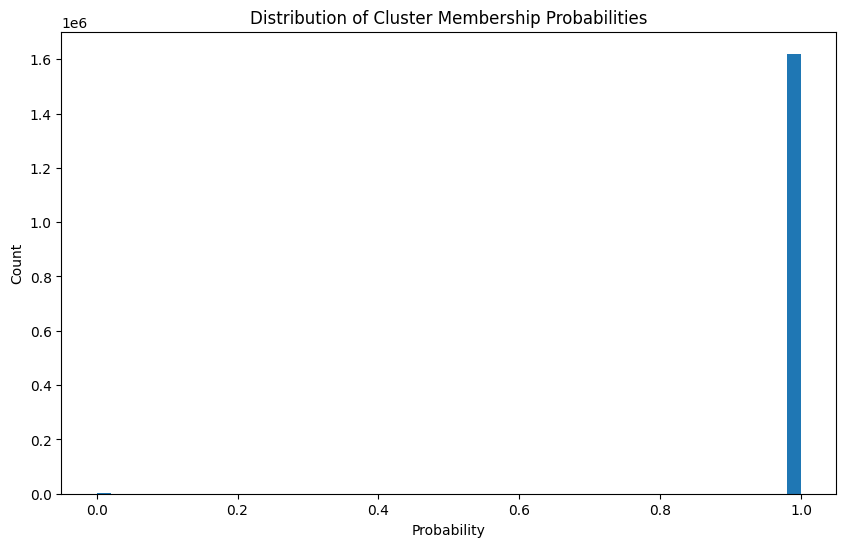

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


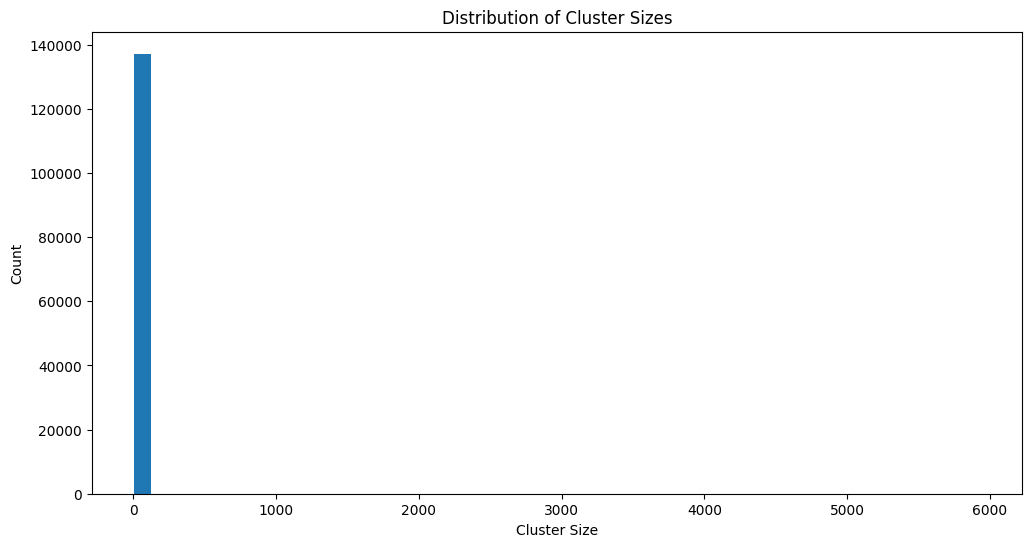

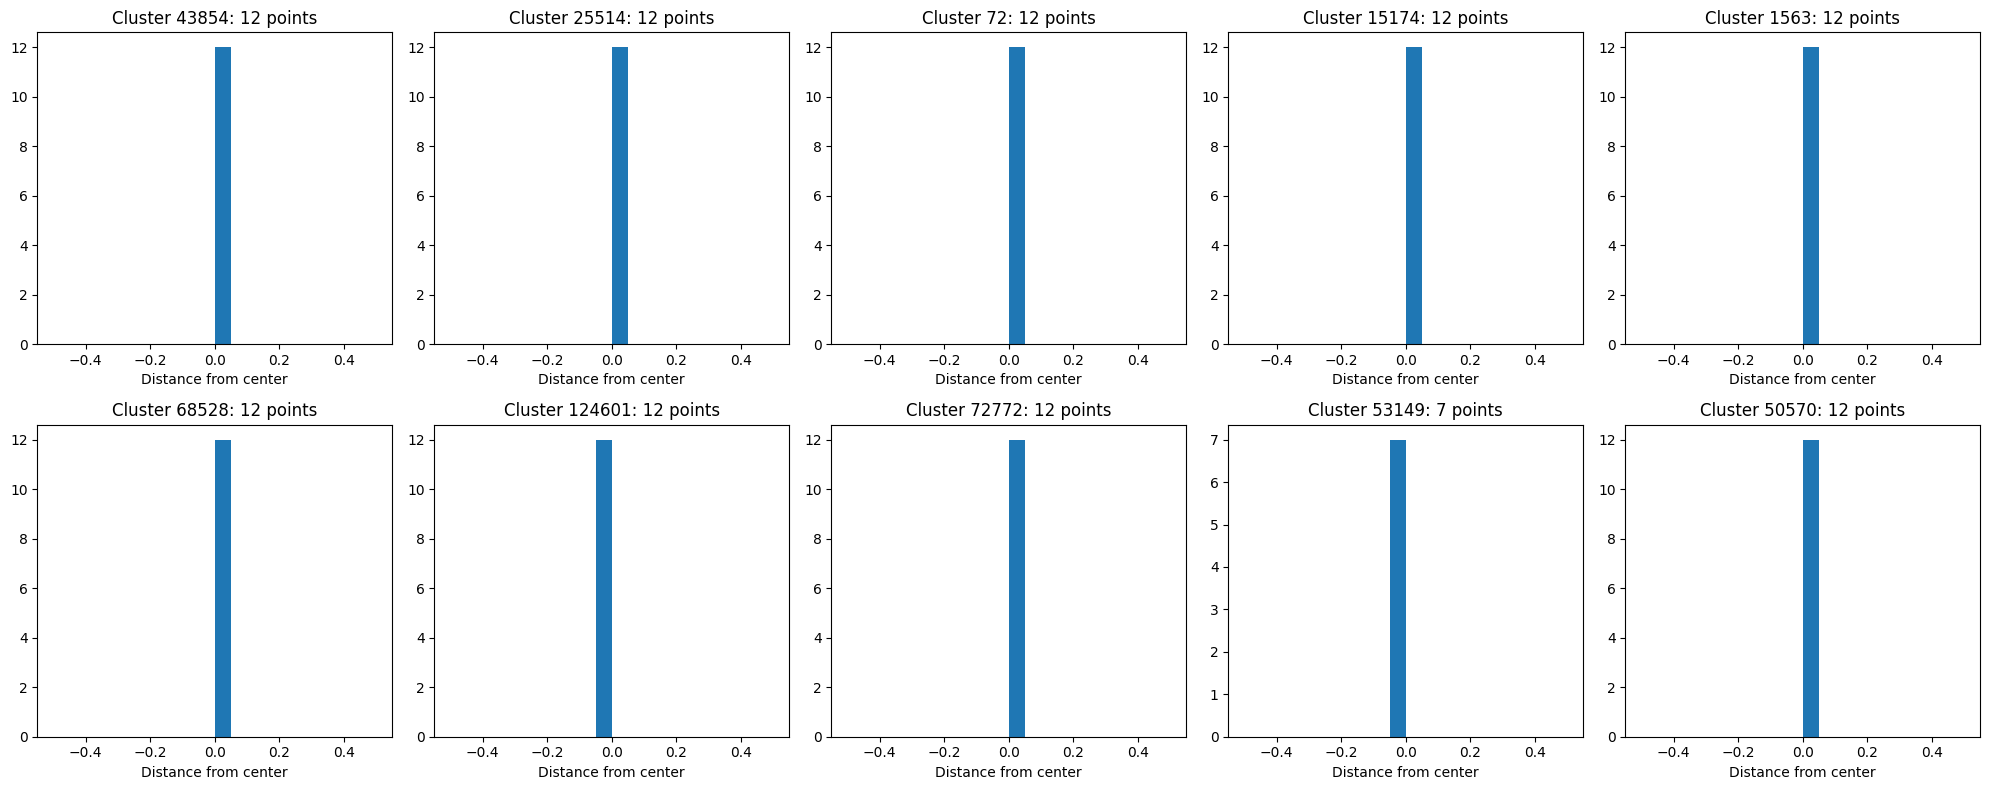

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


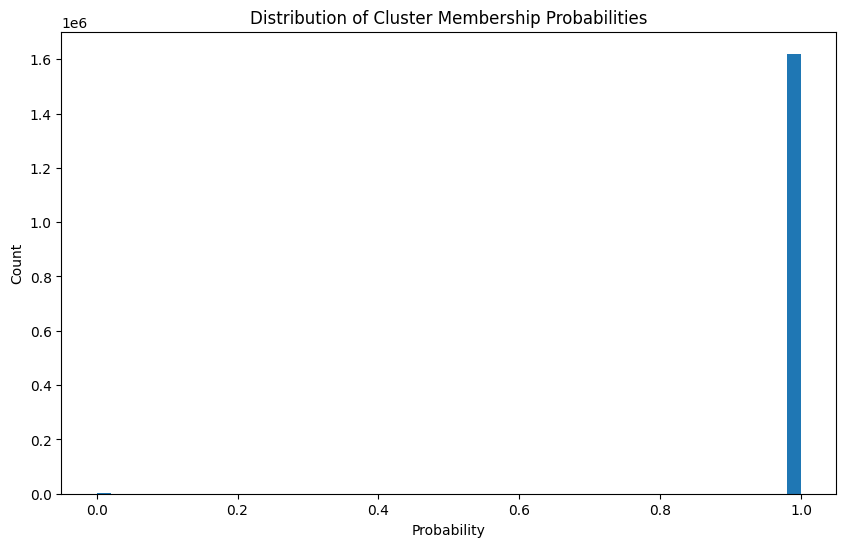

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


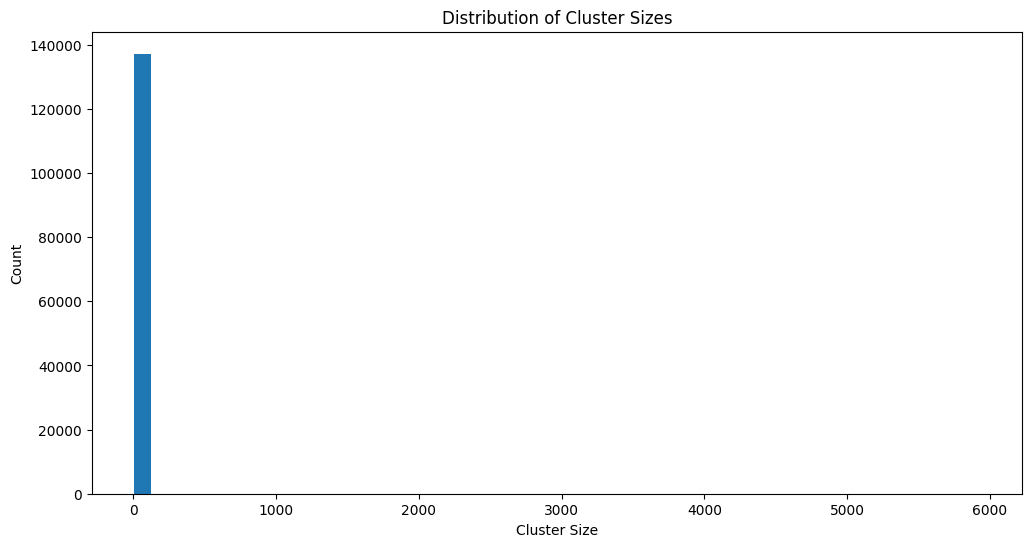

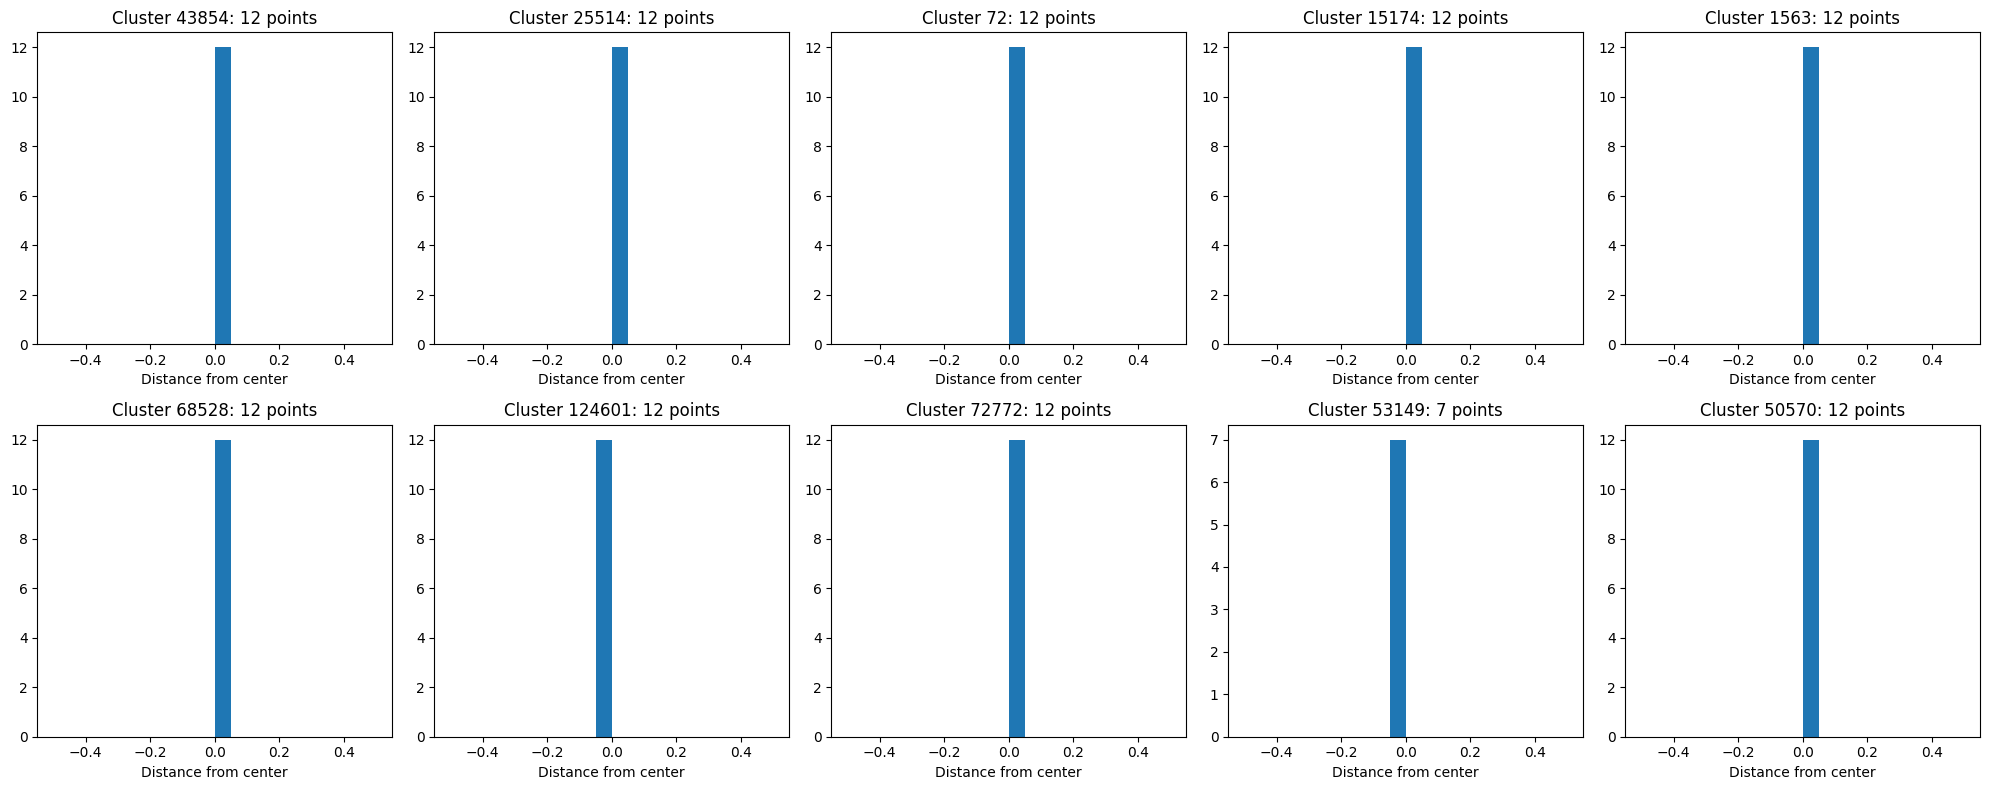

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


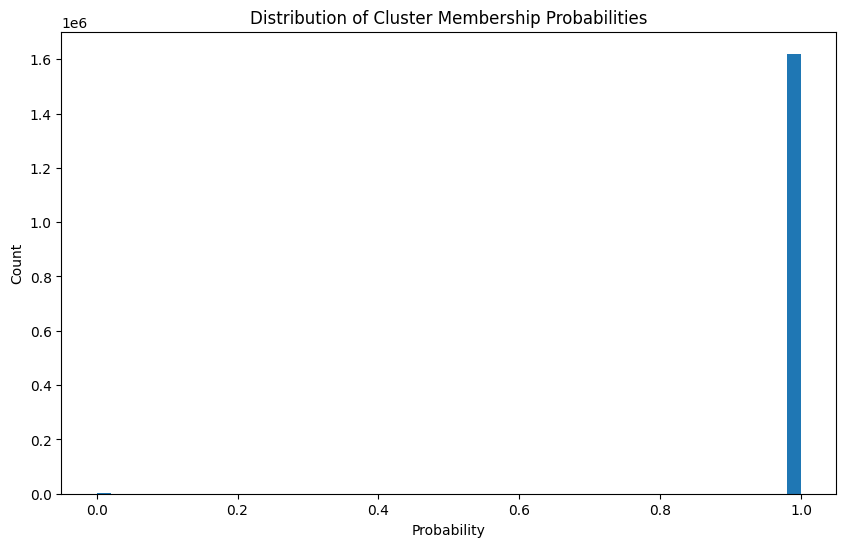

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


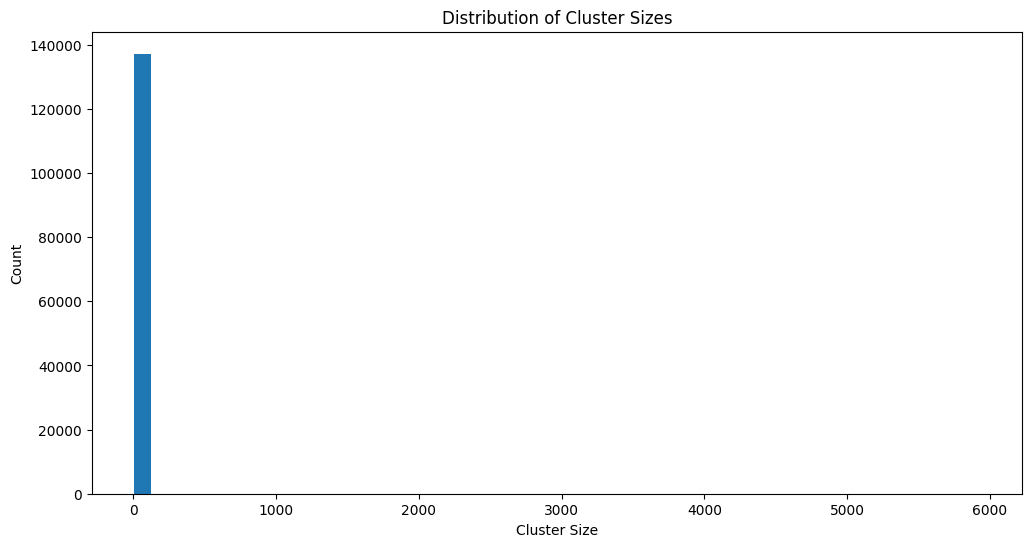

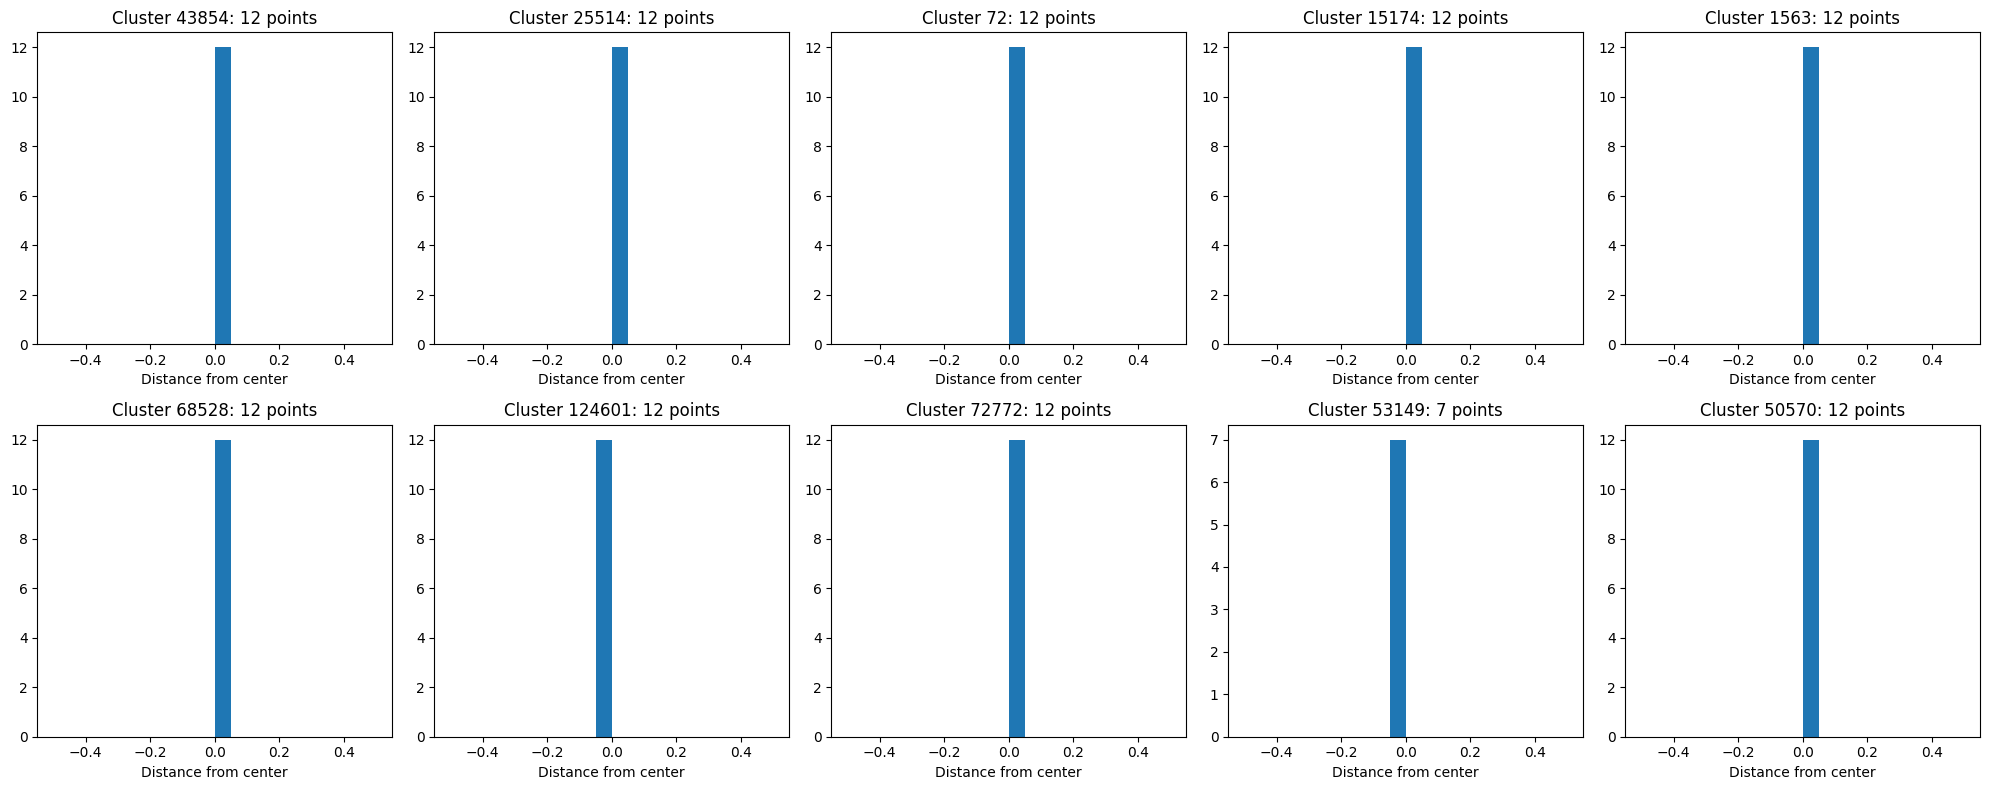

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


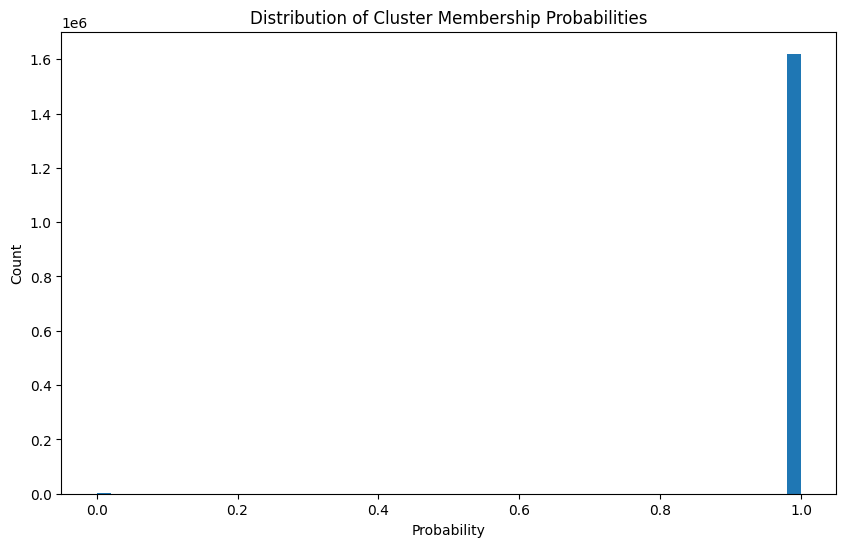

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

## Subsample Clustering Test

In [7]:
import numpy as np
from sklearn.cluster import HDBSCAN
from joblib import Memory

# Set random seed for reproducibility
np.random.seed(42)

# Create a subsample of your data (100K points)
sample_size = 100000
sample_indices = np.random.choice(len(reduced_normalized_embeddings_10), sample_size, replace=False)
sample_data = reduced_normalized_embeddings_10[sample_indices]

# Save the sample indices for later reference
# np.save('sample_indices.npy', sample_indices)

In [19]:
memory = Memory(location='./hdbscan_cache', verbose=0)

In [35]:
import numpy as np
import hdbscan
from joblib import Memory
from tqdm import tqdm
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

def evaluate_clustering(data, labels):
    """
    Calculate various clustering quality metrics
    """
    # Filter out noise points for metric calculation
    mask = labels != -1
    if len(np.unique(labels[mask])) < 2:
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None,
            'relative_validity': None
        }
    
    try:
        # Silhouette Score: Range [-1, 1], higher is better
        # Measures how similar a point is to its own cluster compared to other clusters
        silhouette = silhouette_score(data[mask], labels[mask], sample_size=10000)
        
        # Calinski-Harabasz Index: Higher is better
        # Ratio of between-cluster dispersion and within-cluster dispersion
        calinski = calinski_harabasz_score(data[mask], labels[mask])
        
        # Davies-Bouldin Index: Lower is better
        # Average similarity measure of each cluster with its most similar cluster
        davies = davies_bouldin_score(data[mask], labels[mask])
        
        # HDBSCAN's relative validity metric
        relative_validity = np.mean(clusterer.relative_validity_)
        
        return {
            'silhouette': silhouette,
            'calinski_harabasz': calinski,
            'davies_bouldin': davies,
            'relative_validity': relative_validity
        }
    except:
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None,
            'relative_validity': None
        }


In [9]:
import hdbscan
import numpy as np
from joblib import Memory
from time import time
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm

# Test combinations focusing on min_samples 10 and 20 with different epsilon values
param_combinations = [
    # Baseline with min_samples=10
    {'min_cluster_size': 20, 'min_samples': 10, 'cluster_selection_epsilon': 0.0},
    
    # Testing different epsilon values with min_samples=10
    {'min_cluster_size': 20, 'min_samples': 10, 'cluster_selection_epsilon': 0.01},
    {'min_cluster_size': 20, 'min_samples': 10, 'cluster_selection_epsilon': 0.05},
    {'min_cluster_size': 20, 'min_samples': 10, 'cluster_selection_epsilon': 0.1},
    
    # Baseline with min_samples=20
    {'min_cluster_size': 20, 'min_samples': 20, 'cluster_selection_epsilon': 0.0},
    
    # Testing different epsilon values with min_samples=20
    {'min_cluster_size': 20, 'min_samples': 20, 'cluster_selection_epsilon': 0.01},
    {'min_cluster_size': 20, 'min_samples': 20, 'cluster_selection_epsilon': 0.05},
    {'min_cluster_size': 20, 'min_samples': 20, 'cluster_selection_epsilon': 0.1},
]

# Store results
results = {}

# Run tests with progress bar
print("Testing parameter combinations on sample data...")
for params in tqdm(param_combinations):
    key = f"mcs_{params['min_cluster_size']}_ms_{params['min_samples']}_eps_{params['cluster_selection_epsilon']}"
    labels, metrics = test_hdbscan_params(
        sample_data, 
        min_cluster_size=params['min_cluster_size'],
        min_samples=params['min_samples'],
        cluster_selection_epsilon=params['cluster_selection_epsilon']
    )
    
    results[key] = {
        'labels': labels,
        'metrics': metrics,
        'params': params
    }

# Analyze and compare results
print("\nSummary of Best Parameters:")
metric_rankings = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

for key, result in results.items():
    metrics = result['metrics']
    if metrics['silhouette'] is not None:
        metric_rankings['silhouette'].append((metrics['silhouette'], key))
    if metrics['calinski_harabasz'] is not None:
        metric_rankings['calinski_harabasz'].append((metrics['calinski_harabasz'], key))
    if metrics['davies_bouldin'] is not None:
        metric_rankings['davies_bouldin'].append((metrics['davies_bouldin'], key))

print("\nNoise Ratio Comparison:")
for key, result in results.items():
    labels = result['labels']
    noise_ratio = np.sum(labels == -1) / len(labels)
    print(f"{key}: {noise_ratio:.2%} noise")

print("\nBest parameters according to different metrics:")
print("\nSilhouette Score (higher is better):")
for score, key in sorted(metric_rankings['silhouette'], reverse=True)[:3]:
    print(f"{key}: {score:.3f}")

print("\nCalinski-Harabasz Score (higher is better):")
for score, key in sorted(metric_rankings['calinski_harabasz'], reverse=True)[:3]:
    print(f"{key}: {score:.1f}")

print("\nDavies-Bouldin Score (lower is better):")
for score, key in sorted(metric_rankings['davies_bouldin'])[:3]:
    print(f"{key}: {score:.3f}")

Testing parameter combinations on sample data...


  0%|          | 0/8 [00:00<?, ?it/s]


Results for min_cluster_size=20, min_samples=10
Number of points: 100000
Number of clusters: 2
Noise points: 18623 (18.62%)
Largest cluster: 81326 points
Smallest cluster: 51 points
Average cluster size: 40688.5 points


 12%|█▎        | 1/8 [00:59<06:55, 59.40s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5140150785446167
Calinski-Harabasz Score: 373.5559997558594
Davies-Bouldin Score: 0.4593791508810631
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=10
Number of points: 100000
Number of clusters: 2
Noise points: 18623 (18.62%)
Largest cluster: 81326 points
Smallest cluster: 51 points
Average cluster size: 40688.5 points


 25%|██▌       | 2/8 [01:44<05:06, 51.16s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5160479545593262
Calinski-Harabasz Score: 373.5559997558594
Davies-Bouldin Score: 0.4593791508810631
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=10
Number of points: 100000
Number of clusters: 2
Noise points: 18623 (18.62%)
Largest cluster: 81326 points
Smallest cluster: 51 points
Average cluster size: 40688.5 points


 38%|███▊      | 3/8 [02:28<03:59, 47.81s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5054219961166382
Calinski-Harabasz Score: 373.5559997558594
Davies-Bouldin Score: 0.4593791508810631
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=10
Number of points: 100000
Number of clusters: 2
Noise points: 18623 (18.62%)
Largest cluster: 81326 points
Smallest cluster: 51 points
Average cluster size: 40688.5 points


 50%|█████     | 4/8 [03:10<03:01, 45.35s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5297913551330566
Calinski-Harabasz Score: 373.5559997558594
Davies-Bouldin Score: 0.4593791508810631
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=20
Number of points: 100000
Number of clusters: 2
Noise points: 23064 (23.06%)
Largest cluster: 76909 points
Smallest cluster: 27 points
Average cluster size: 38468.0 points


 62%|██████▎   | 5/8 [03:50<02:10, 43.47s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5494856238365173
Calinski-Harabasz Score: 213.904296875
Davies-Bouldin Score: 0.41194302623946516
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=20
Number of points: 100000
Number of clusters: 2
Noise points: 23064 (23.06%)
Largest cluster: 76909 points
Smallest cluster: 27 points
Average cluster size: 38468.0 points


 75%|███████▌  | 6/8 [04:31<01:25, 42.72s/it]


Clustering Quality Metrics:
Silhouette Score: 0.539298415184021
Calinski-Harabasz Score: 213.904296875
Davies-Bouldin Score: 0.41194302623946516
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=20
Number of points: 100000
Number of clusters: 2
Noise points: 23064 (23.06%)
Largest cluster: 76909 points
Smallest cluster: 27 points
Average cluster size: 38468.0 points


 88%|████████▊ | 7/8 [05:14<00:42, 42.75s/it]


Clustering Quality Metrics:
Silhouette Score: 0.540594220161438
Calinski-Harabasz Score: 213.904296875
Davies-Bouldin Score: 0.41194302623946516
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=20
Number of points: 100000
Number of clusters: 2
Noise points: 23064 (23.06%)
Largest cluster: 76909 points
Smallest cluster: 27 points
Average cluster size: 38468.0 points


100%|██████████| 8/8 [05:55<00:00, 44.45s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5441105961799622
Calinski-Harabasz Score: 213.904296875
Davies-Bouldin Score: 0.41194302623946516
HDBSCAN Relative Validity: None
--------------------------------------------------

Summary of Best Parameters:

Noise Ratio Comparison:
mcs_20_ms_10_eps_0.0: 18.62% noise
mcs_20_ms_10_eps_0.01: 18.62% noise
mcs_20_ms_10_eps_0.05: 18.62% noise
mcs_20_ms_10_eps_0.1: 18.62% noise
mcs_20_ms_20_eps_0.0: 23.06% noise
mcs_20_ms_20_eps_0.01: 23.06% noise
mcs_20_ms_20_eps_0.05: 23.06% noise
mcs_20_ms_20_eps_0.1: 23.06% noise

Best parameters according to different metrics:

Silhouette Score (higher is better):
mcs_20_ms_20_eps_0.0: 0.549
mcs_20_ms_20_eps_0.1: 0.544
mcs_20_ms_20_eps_0.05: 0.541

Calinski-Harabasz Score (higher is better):
mcs_20_ms_10_eps_0.1: 373.6
mcs_20_ms_10_eps_0.05: 373.6
mcs_20_ms_10_eps_0.01: 373.6

Davies-Bouldin Score (lower is better):
mcs_20_ms_20_eps_0.0: 0.412
mcs_20_ms_20_eps_0.01: 0.412
mcs_20_ms_20_eps_0.05: 0.412


In [10]:
# Test combinations focusing on different min_samples values
param_combinations_min_samples = [
    # Testing range of min_samples with fixed min_cluster_size=20
    {'min_cluster_size': 20, 'min_samples': 2, 'cluster_selection_epsilon': 0.0},
    {'min_cluster_size': 20, 'min_samples': 5, 'cluster_selection_epsilon': 0.0},
    {'min_cluster_size': 20, 'min_samples': 10, 'cluster_selection_epsilon': 0.0},
    {'min_cluster_size': 20, 'min_samples': 15, 'cluster_selection_epsilon': 0.0},
    {'min_cluster_size': 20, 'min_samples': 20, 'cluster_selection_epsilon': 0.0},
    {'min_cluster_size': 20, 'min_samples': 30, 'cluster_selection_epsilon': 0.0},
    {'min_cluster_size': 20, 'min_samples': 50, 'cluster_selection_epsilon': 0.0},
    
    # Testing min_samples < min_cluster_size with epsilon for comparison
    {'min_cluster_size': 20, 'min_samples': 5, 'cluster_selection_epsilon': 0.05},
    {'min_cluster_size': 20, 'min_samples': 10, 'cluster_selection_epsilon': 0.05}
]

# Store results
results_min_samples = {}

# Run tests with progress bar
print("Testing min_samples impact on clustering...")
for params in tqdm(param_combinations_min_samples):
    key = f"mcs_{params['min_cluster_size']}_ms_{params['min_samples']}_eps_{params['cluster_selection_epsilon']}"
    labels, metrics = test_hdbscan_params(
        sample_data, 
        min_cluster_size=params['min_cluster_size'],
        min_samples=params['min_samples'],
        cluster_selection_epsilon=params['cluster_selection_epsilon']
    )
    
    results_min_samples[key] = {
        'labels': labels,
        'metrics': metrics,
        'params': params
    }

# Analyze and compare results
print("\nSummary of min_samples Impact:")
metric_rankings_ms = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

for key, result in results_min_samples.items():
    metrics = result['metrics']
    if metrics['silhouette'] is not None:
        metric_rankings_ms['silhouette'].append((metrics['silhouette'], key))
    if metrics['calinski_harabasz'] is not None:
        metric_rankings_ms['calinski_harabasz'].append((metrics['calinski_harabasz'], key))
    if metrics['davies_bouldin'] is not None:
        metric_rankings_ms['davies_bouldin'].append((metrics['davies_bouldin'], key))

print("\nNoise Ratio Comparison:")
for key, result in results_min_samples.items():
    labels = result['labels']
    noise_ratio = np.sum(labels == -1) / len(labels)
    n_clusters = len(np.unique(labels)) - 1
    print(f"{key}: {noise_ratio:.2%} noise, {n_clusters} clusters")

print("\nBest parameters according to different metrics:")
print("\nSilhouette Score (higher is better):")
for score, key in sorted(metric_rankings_ms['silhouette'], reverse=True)[:3]:
    print(f"{key}: {score:.3f}")

print("\nCalinski-Harabasz Score (higher is better):")
for score, key in sorted(metric_rankings_ms['calinski_harabasz'], reverse=True)[:3]:
    print(f"{key}: {score:.1f}")

print("\nDavies-Bouldin Score (lower is better):")
for score, key in sorted(metric_rankings_ms['davies_bouldin'])[:3]:
    print(f"{key}: {score:.3f}")

# Create a comparison of cluster count and noise percentage
comparison = []
for key, result in results_min_samples.items():
    labels = result['labels']
    noise_ratio = np.sum(labels == -1) / len(labels)
    n_clusters = len(np.unique(labels)) - 1
    
    silhouette = result['metrics'].get('silhouette')
    if silhouette is not None:
        silhouette_val = f"{silhouette:.3f}"
    else:
        silhouette_val = "N/A"
    
    params = result['params']
    min_samples = params['min_samples']
    epsilon = params['cluster_selection_epsilon']
    
    comparison.append({
        'min_samples': min_samples,
        'epsilon': epsilon,
        'clusters': n_clusters,
        'noise_ratio': noise_ratio,
        'silhouette': silhouette_val
    })

# Print comparison in a table format
print("\nComparison Table (sorted by noise ratio):")
print(f"{'min_samples':<12} {'epsilon':<10} {'clusters':<10} {'noise %':<10} {'silhouette':<10}")
print("-" * 55)

for item in sorted(comparison, key=lambda x: x['noise_ratio']):
    print(f"{item['min_samples']:<12} {item['epsilon']:<10.3f} {item['clusters']:<10} {item['noise_ratio']:<10.2%} {item['silhouette']:<10}")

Testing min_samples impact on clustering...


  0%|          | 0/9 [00:00<?, ?it/s]


Results for min_cluster_size=20, min_samples=2
Number of points: 100000
Number of clusters: 2
Noise points: 4839 (4.84%)
Largest cluster: 95141 points
Smallest cluster: 20 points
Average cluster size: 47580.5 points


 11%|█         | 1/9 [00:53<07:05, 53.20s/it]


Clustering Quality Metrics:
Silhouette Score: 0.4229293465614319
Calinski-Harabasz Score: 97.56239318847656
Davies-Bouldin Score: 0.5486515941844279
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=5
Number of points: 100000
Number of clusters: 5
Noise points: 24457 (24.46%)
Largest cluster: 75406 points
Smallest cluster: 23 points
Average cluster size: 15108.6 points


 22%|██▏       | 2/9 [01:37<05:35, 47.91s/it]


Clustering Quality Metrics:
Silhouette Score: 0.39533817768096924
Calinski-Harabasz Score: 236.179443359375
Davies-Bouldin Score: 0.9461805749879255
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=10
Number of points: 100000
Number of clusters: 2
Noise points: 18623 (18.62%)
Largest cluster: 81326 points
Smallest cluster: 51 points
Average cluster size: 40688.5 points


 33%|███▎      | 3/9 [02:18<04:29, 44.94s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5287222862243652
Calinski-Harabasz Score: 373.5559997558594
Davies-Bouldin Score: 0.4593791508810631
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=15
Number of points: 100000
Number of clusters: 2
Noise points: 20850 (20.85%)
Largest cluster: 79114 points
Smallest cluster: 36 points
Average cluster size: 39575.0 points


 44%|████▍     | 4/9 [02:57<03:33, 42.66s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5372840762138367
Calinski-Harabasz Score: 272.6187438964844
Davies-Bouldin Score: 0.4335674583242656
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=20
Number of points: 100000
Number of clusters: 2
Noise points: 23064 (23.06%)
Largest cluster: 76909 points
Smallest cluster: 27 points
Average cluster size: 38468.0 points


 56%|█████▌    | 5/9 [03:37<02:46, 41.64s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5333594679832458
Calinski-Harabasz Score: 213.904296875
Davies-Bouldin Score: 0.41194302623946516
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=30
Number of points: 100000
Number of clusters: 2
Noise points: 20255 (20.26%)
Largest cluster: 79719 points
Smallest cluster: 26 points
Average cluster size: 39872.5 points


 67%|██████▋   | 6/9 [04:18<02:03, 41.16s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5383329391479492
Calinski-Harabasz Score: 204.93141174316406
Davies-Bouldin Score: 0.4101953583644426
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=50
Number of points: 100000
Number of clusters: 2
Noise points: 56673 (56.67%)
Largest cluster: 42984 points
Smallest cluster: 343 points
Average cluster size: 21663.5 points


 78%|███████▊  | 7/9 [04:57<01:20, 40.48s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5401536822319031
Calinski-Harabasz Score: 2554.130859375
Davies-Bouldin Score: 0.48191837142396365
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=5
Number of points: 100000
Number of clusters: 2
Noise points: 18526 (18.53%)
Largest cluster: 81450 points
Smallest cluster: 24 points
Average cluster size: 40737.0 points


 89%|████████▉ | 8/9 [05:41<00:41, 41.71s/it]


Clustering Quality Metrics:
Silhouette Score: 0.4142834544181824
Calinski-Harabasz Score: 102.95816040039062
Davies-Bouldin Score: 0.569815592294427
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=10
Number of points: 100000
Number of clusters: 2
Noise points: 18623 (18.62%)
Largest cluster: 81326 points
Smallest cluster: 51 points
Average cluster size: 40688.5 points


100%|██████████| 9/9 [06:22<00:00, 42.45s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5220625996589661
Calinski-Harabasz Score: 373.5559997558594
Davies-Bouldin Score: 0.4593791508810631
HDBSCAN Relative Validity: None
--------------------------------------------------

Summary of min_samples Impact:

Noise Ratio Comparison:
mcs_20_ms_2_eps_0.0: 4.84% noise, 2 clusters
mcs_20_ms_5_eps_0.0: 24.46% noise, 5 clusters
mcs_20_ms_10_eps_0.0: 18.62% noise, 2 clusters
mcs_20_ms_15_eps_0.0: 20.85% noise, 2 clusters
mcs_20_ms_20_eps_0.0: 23.06% noise, 2 clusters
mcs_20_ms_30_eps_0.0: 20.26% noise, 2 clusters
mcs_20_ms_50_eps_0.0: 56.67% noise, 2 clusters
mcs_20_ms_5_eps_0.05: 18.53% noise, 2 clusters
mcs_20_ms_10_eps_0.05: 18.62% noise, 2 clusters

Best parameters according to different metrics:

Silhouette Score (higher is better):
mcs_20_ms_50_eps_0.0: 0.540
mcs_20_ms_30_eps_0.0: 0.538
mcs_20_ms_15_eps_0.0: 0.537

Calinski-Harabasz Score (higher is better):
mcs_20_ms_50_eps_0.0: 2554.1
mcs_20_ms_10_eps_0.05: 373.6
mcs_20_ms_10_ep